## Imports

In [1]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T

from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.train_test import train_test, train_test_mini_batch
from utils.minibatches_split import split_to_minibatches
from utils.visualize import plot_loss, plot_train, plot_val, plot_test, plot_results

/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the corresponsing csv, store the dataset to the DB, preprocess it, and get it as a pytorch graph object

In [3]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    text_features=["title"],
    list_features=[],
    fastRP_features=["fastRP_genres", "fastRP_keywords", "fastRP_cast", "fastRP_crew"],
    numeric_features=["vote_average", "vote_count"],
    node2vec_features=[],
    SAGE_features=[],
)
# path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
# dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

Processing...


Movies have features...
Encoding title...


Batches: 100%|██████████| 565/565 [00:16<00:00, 33.81it/s]


Encoding fastRP_genres...
Encoding fastRP_keywords...
Encoding fastRP_cast...
Encoding fastRP_crew...
Encoding ['vote_average', 'vote_count']...
[torch.Size([18062, 384]), torch.Size([18062, 32]), torch.Size([18062, 32]), torch.Size([18062, 32]), torch.Size([18062, 32]), torch.Size([18062, 2])]


Done!


#### Preprocess the dataset

In [4]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

#### Define and train-test the model

In [6]:
model = Model(
    data,
    layer_name="GIN",
    encoder_num_layers=3,
    encoder_dropout=0.1,
    encoder_skip_connections=True,
    decoder_num_layers=8,
    hidden_channels=16,
    out_channels=16,
).to(device)

# model = GIN_COPY(dim_h=32)

train_batch, train_loader = split_to_minibatches(
    data=train_data,
    batch_size=32,
    num_neighbours=[15, 5],
)
test_batch, test_loader = split_to_minibatches(
    data=test_data,
    batch_size=128,
    num_neighbours=[15, 10],
)
losses = train_test_mini_batch(
    model=model,
    epochs=10,
    train_batch=train_batch,
    train_loader=train_loader,
    test_batch=test_batch,
    test_loader=test_loader,
    lr=0.012,
)

GIN
Aggregation: None


  0%|          | 2/66520 [00:00<2:31:11,  7.33it/s]

		 Train Batch: Loss: 12.6940


  0%|          | 102/66520 [00:10<1:54:28,  9.67it/s]

		 Train Batch: Loss: 4.0000


  0%|          | 202/66520 [00:20<1:53:26,  9.74it/s]

		 Train Batch: Loss: 2.3125


  0%|          | 302/66520 [00:31<1:51:00,  9.94it/s]

		 Train Batch: Loss: 3.8438


  1%|          | 402/66520 [00:41<1:54:13,  9.65it/s]

		 Train Batch: Loss: 3.8750


  1%|          | 501/66520 [00:51<1:48:46, 10.12it/s]

		 Train Batch: Loss: 3.7500


  1%|          | 603/66520 [01:02<1:48:16, 10.15it/s]

		 Train Batch: Loss: 2.8750


  1%|          | 702/66520 [01:12<1:49:00, 10.06it/s]

		 Train Batch: Loss: 2.3125


  1%|          | 802/66520 [01:23<2:08:25,  8.53it/s]

		 Train Batch: Loss: 1.9062


  1%|▏         | 902/66520 [01:35<1:56:32,  9.38it/s]

		 Train Batch: Loss: 4.1875


  2%|▏         | 1002/66520 [01:45<2:03:21,  8.85it/s]

		 Train Batch: Loss: 2.5000


  2%|▏         | 1102/66520 [01:56<1:55:39,  9.43it/s]

		 Train Batch: Loss: 3.8125


  2%|▏         | 1202/66520 [02:07<1:58:18,  9.20it/s]

		 Train Batch: Loss: 2.7500


  2%|▏         | 1302/66520 [02:18<1:56:09,  9.36it/s]

		 Train Batch: Loss: 3.7500


  2%|▏         | 1402/66520 [02:30<2:04:56,  8.69it/s]

		 Train Batch: Loss: 3.5312


  2%|▏         | 1502/66520 [02:41<1:59:54,  9.04it/s]

		 Train Batch: Loss: 3.0312


  2%|▏         | 1602/66520 [02:52<1:59:08,  9.08it/s]

		 Train Batch: Loss: 3.5625


  3%|▎         | 1702/66520 [03:04<1:59:38,  9.03it/s]

		 Train Batch: Loss: 2.7500


  3%|▎         | 1802/66520 [03:15<2:02:22,  8.81it/s]

		 Train Batch: Loss: 3.6250


  3%|▎         | 1902/66520 [03:26<2:02:27,  8.79it/s]

		 Train Batch: Loss: 3.8750


  3%|▎         | 2002/66520 [03:37<1:58:51,  9.05it/s]

		 Train Batch: Loss: 4.0000


  3%|▎         | 2102/66520 [03:48<1:57:03,  9.17it/s]

		 Train Batch: Loss: 2.7500


  3%|▎         | 2202/66520 [03:59<1:54:57,  9.32it/s]

		 Train Batch: Loss: 2.7812


  3%|▎         | 2302/66520 [04:10<1:52:19,  9.53it/s]

		 Train Batch: Loss: 3.8438


  4%|▎         | 2402/66520 [04:20<1:50:05,  9.71it/s]

		 Train Batch: Loss: 4.3125


  4%|▍         | 2502/66520 [04:31<1:51:05,  9.60it/s]

		 Train Batch: Loss: 2.9688


  4%|▍         | 2602/66520 [04:41<1:50:26,  9.65it/s]

		 Train Batch: Loss: 2.7500


  4%|▍         | 2702/66520 [04:52<1:50:15,  9.65it/s]

		 Train Batch: Loss: 2.1875


  4%|▍         | 2802/66520 [05:02<1:47:50,  9.85it/s]

		 Train Batch: Loss: 2.6875


  4%|▍         | 2902/66520 [05:12<1:50:41,  9.58it/s]

		 Train Batch: Loss: 1.9062


  5%|▍         | 3002/66520 [05:23<1:52:25,  9.42it/s]

		 Train Batch: Loss: 2.6250


  5%|▍         | 3102/66520 [05:34<1:49:41,  9.64it/s]

		 Train Batch: Loss: 3.9375


  5%|▍         | 3202/66520 [05:44<1:47:48,  9.79it/s]

		 Train Batch: Loss: 4.5000


  5%|▍         | 3302/66520 [05:54<1:53:13,  9.31it/s]

		 Train Batch: Loss: 3.2812


  5%|▌         | 3402/66520 [06:04<1:46:47,  9.85it/s]

		 Train Batch: Loss: 2.6875


  5%|▌         | 3503/66520 [06:15<1:47:40,  9.75it/s]

		 Train Batch: Loss: 4.1250


  5%|▌         | 3602/66520 [06:25<1:52:49,  9.29it/s]

		 Train Batch: Loss: 4.2188


  6%|▌         | 3702/66520 [06:35<1:45:11,  9.95it/s]

		 Train Batch: Loss: 2.3125


  6%|▌         | 3802/66520 [06:45<1:45:35,  9.90it/s]

		 Train Batch: Loss: 5.0625


  6%|▌         | 3902/66520 [06:55<1:43:17, 10.10it/s]

		 Train Batch: Loss: 4.5625


  6%|▌         | 4003/66520 [07:05<1:44:14, 10.00it/s]

		 Train Batch: Loss: 2.0312


  6%|▌         | 4103/66520 [07:15<1:43:08, 10.09it/s]

		 Train Batch: Loss: 3.4375


  6%|▋         | 4202/66520 [07:25<1:44:10,  9.97it/s]

		 Train Batch: Loss: 2.8750


  6%|▋         | 4303/66520 [07:35<1:43:13, 10.05it/s]

		 Train Batch: Loss: 2.0625


  7%|▋         | 4402/66520 [07:45<1:42:50, 10.07it/s]

		 Train Batch: Loss: 3.4375


  7%|▋         | 4502/66520 [07:55<1:44:31,  9.89it/s]

		 Train Batch: Loss: 4.2188


  7%|▋         | 4603/66520 [08:06<1:43:25,  9.98it/s]

		 Train Batch: Loss: 3.0312


  7%|▋         | 4702/66520 [08:15<1:42:43, 10.03it/s]

		 Train Batch: Loss: 2.5000


  7%|▋         | 4802/66520 [08:26<1:42:52, 10.00it/s]

		 Train Batch: Loss: 5.7812


  7%|▋         | 4903/66520 [08:36<1:42:03, 10.06it/s]

		 Train Batch: Loss: 3.5625


  8%|▊         | 5002/66520 [08:46<1:42:46,  9.98it/s]

		 Train Batch: Loss: 3.6562


  8%|▊         | 5103/66520 [08:56<1:41:55, 10.04it/s]

		 Train Batch: Loss: 2.1875


  8%|▊         | 5202/66520 [09:06<1:41:39, 10.05it/s]

		 Train Batch: Loss: 2.7500


  8%|▊         | 5302/66520 [09:16<1:42:24,  9.96it/s]

		 Train Batch: Loss: 1.6250


  8%|▊         | 5402/66520 [09:26<1:41:30, 10.04it/s]

		 Train Batch: Loss: 3.7188


  8%|▊         | 5503/66520 [09:36<1:40:30, 10.12it/s]

		 Train Batch: Loss: 3.4375


  8%|▊         | 5602/66520 [09:46<1:41:46,  9.98it/s]

		 Train Batch: Loss: 2.6250


  9%|▊         | 5702/66520 [09:56<1:42:59,  9.84it/s]

		 Train Batch: Loss: 3.6250


  9%|▊         | 5802/66520 [10:06<1:42:57,  9.83it/s]

		 Train Batch: Loss: 3.0625


  9%|▉         | 5902/66520 [10:17<1:44:06,  9.70it/s]

		 Train Batch: Loss: 3.3750


  9%|▉         | 6003/66520 [10:27<1:40:23, 10.05it/s]

		 Train Batch: Loss: 3.5312


  9%|▉         | 6102/66520 [10:37<1:41:16,  9.94it/s]

		 Train Batch: Loss: 3.4688


  9%|▉         | 6202/66520 [10:47<1:39:52, 10.07it/s]

		 Train Batch: Loss: 3.5625


  9%|▉         | 6302/66520 [10:57<1:40:23, 10.00it/s]

		 Train Batch: Loss: 2.0312


 10%|▉         | 6402/66520 [11:08<1:41:23,  9.88it/s]

		 Train Batch: Loss: 3.2500


 10%|▉         | 6502/66520 [11:18<1:42:48,  9.73it/s]

		 Train Batch: Loss: 3.6250


 10%|▉         | 6602/66520 [11:28<1:49:11,  9.15it/s]

		 Train Batch: Loss: 1.9375


 10%|█         | 6702/66520 [11:39<1:42:15,  9.75it/s]

		 Train Batch: Loss: 3.5938


 10%|█         | 6802/66520 [11:49<1:39:25, 10.01it/s]

		 Train Batch: Loss: 3.6562


 10%|█         | 6902/66520 [11:59<1:45:29,  9.42it/s]

		 Train Batch: Loss: 3.7188


 11%|█         | 7001/66520 [12:09<1:38:35, 10.06it/s]

		 Train Batch: Loss: 2.3750


 11%|█         | 7101/66520 [12:19<1:41:10,  9.79it/s]

		 Train Batch: Loss: 3.0625


 11%|█         | 7203/66520 [12:30<1:38:15, 10.06it/s]

		 Train Batch: Loss: 4.2812


 11%|█         | 7303/66520 [12:40<1:38:06, 10.06it/s]

		 Train Batch: Loss: 3.3125


 11%|█         | 7402/66520 [12:50<1:38:46,  9.98it/s]

		 Train Batch: Loss: 2.5000


 11%|█▏        | 7502/66520 [13:00<1:43:08,  9.54it/s]

		 Train Batch: Loss: 3.1875


 11%|█▏        | 7602/66520 [13:10<1:38:29,  9.97it/s]

		 Train Batch: Loss: 4.1875


 12%|█▏        | 7702/66520 [13:20<1:37:56, 10.01it/s]

		 Train Batch: Loss: 3.2188


 12%|█▏        | 7803/66520 [13:30<1:37:00, 10.09it/s]

		 Train Batch: Loss: 3.6562


 12%|█▏        | 7901/66520 [13:40<1:37:14, 10.05it/s]

		 Train Batch: Loss: 2.8750


 12%|█▏        | 8003/66520 [13:50<1:37:24, 10.01it/s]

		 Train Batch: Loss: 3.1562


 12%|█▏        | 8102/66520 [14:00<1:36:51, 10.05it/s]

		 Train Batch: Loss: 3.4375


 12%|█▏        | 8201/66520 [14:10<1:36:41, 10.05it/s]

		 Train Batch: Loss: 4.4375


 12%|█▏        | 8302/66520 [14:20<1:37:02, 10.00it/s]

		 Train Batch: Loss: 3.6250


 13%|█▎        | 8403/66520 [14:30<1:36:25, 10.04it/s]

		 Train Batch: Loss: 3.2188


 13%|█▎        | 8503/66520 [14:40<1:35:52, 10.09it/s]

		 Train Batch: Loss: 3.2188


 13%|█▎        | 8602/66520 [14:50<1:38:36,  9.79it/s]

		 Train Batch: Loss: 2.5938


 13%|█▎        | 8703/66520 [15:00<1:35:36, 10.08it/s]

		 Train Batch: Loss: 4.2500


 13%|█▎        | 8802/66520 [15:10<1:38:25,  9.77it/s]

		 Train Batch: Loss: 3.6562


 13%|█▎        | 8901/66520 [15:20<1:35:38, 10.04it/s]

		 Train Batch: Loss: 3.2812


 14%|█▎        | 9003/66520 [15:30<1:35:39, 10.02it/s]

		 Train Batch: Loss: 2.9688


 14%|█▎        | 9103/66520 [15:40<1:34:39, 10.11it/s]

		 Train Batch: Loss: 2.5000


 14%|█▍        | 9203/66520 [15:50<1:35:22, 10.02it/s]

		 Train Batch: Loss: 3.1562


 14%|█▍        | 9301/66520 [16:00<1:35:06, 10.03it/s]

		 Train Batch: Loss: 2.4062


 14%|█▍        | 9402/66520 [16:10<1:34:30, 10.07it/s]

		 Train Batch: Loss: 4.0000


 14%|█▍        | 9503/66520 [16:20<1:37:15,  9.77it/s]

		 Train Batch: Loss: 3.6875


 14%|█▍        | 9603/66520 [16:30<1:34:44, 10.01it/s]

		 Train Batch: Loss: 1.9375


 15%|█▍        | 9702/66520 [16:40<1:33:47, 10.10it/s]

		 Train Batch: Loss: 2.9688


 15%|█▍        | 9803/66520 [16:50<1:34:37,  9.99it/s]

		 Train Batch: Loss: 3.0312


 15%|█▍        | 9903/66520 [17:00<1:33:27, 10.10it/s]

		 Train Batch: Loss: 3.6875


 15%|█▌        | 10002/66520 [17:10<1:36:17,  9.78it/s]

		 Train Batch: Loss: 3.3125


 15%|█▌        | 10101/66520 [17:20<1:33:24, 10.07it/s]

		 Train Batch: Loss: 4.0312


 15%|█▌        | 10203/66520 [17:30<1:33:17, 10.06it/s]

		 Train Batch: Loss: 3.3125


 15%|█▌        | 10302/66520 [17:40<1:33:00, 10.07it/s]

		 Train Batch: Loss: 2.0625


 16%|█▌        | 10402/66520 [17:50<1:32:46, 10.08it/s]

		 Train Batch: Loss: 2.3438


 16%|█▌        | 10502/66520 [18:00<1:32:41, 10.07it/s]

		 Train Batch: Loss: 2.2500


 16%|█▌        | 10602/66520 [18:10<1:33:03, 10.02it/s]

		 Train Batch: Loss: 3.6562


 16%|█▌        | 10703/66520 [18:20<1:32:01, 10.11it/s]

		 Train Batch: Loss: 4.3750


 16%|█▌        | 10802/66520 [18:31<1:46:40,  8.71it/s]

		 Train Batch: Loss: 2.9062


 16%|█▋        | 10902/66520 [18:42<1:36:26,  9.61it/s]

		 Train Batch: Loss: 3.0938


 17%|█▋        | 11002/66520 [18:52<1:35:52,  9.65it/s]

		 Train Batch: Loss: 3.0625


 17%|█▋        | 11102/66520 [19:03<1:37:43,  9.45it/s]

		 Train Batch: Loss: 4.0312


 17%|█▋        | 11202/66520 [19:13<1:37:39,  9.44it/s]

		 Train Batch: Loss: 3.9375


 17%|█▋        | 11302/66520 [19:24<1:36:59,  9.49it/s]

		 Train Batch: Loss: 3.3438


 17%|█▋        | 11402/66520 [19:34<1:35:12,  9.65it/s]

		 Train Batch: Loss: 3.8438


 17%|█▋        | 11502/66520 [19:45<1:35:46,  9.57it/s]

		 Train Batch: Loss: 3.2188


 17%|█▋        | 11602/66520 [19:55<1:34:38,  9.67it/s]

		 Train Batch: Loss: 2.6562


 18%|█▊        | 11702/66520 [20:06<1:35:20,  9.58it/s]

		 Train Batch: Loss: 5.2812


 18%|█▊        | 11802/66520 [20:16<1:35:37,  9.54it/s]

		 Train Batch: Loss: 3.1875


 18%|█▊        | 11902/66520 [20:27<1:35:11,  9.56it/s]

		 Train Batch: Loss: 2.9375


 18%|█▊        | 12002/66520 [20:37<1:34:05,  9.66it/s]

		 Train Batch: Loss: 2.5938


 18%|█▊        | 12102/66520 [20:47<1:35:10,  9.53it/s]

		 Train Batch: Loss: 3.4688


 18%|█▊        | 12202/66520 [20:58<1:33:03,  9.73it/s]

		 Train Batch: Loss: 2.4375


 18%|█▊        | 12302/66520 [21:08<1:34:05,  9.60it/s]

		 Train Batch: Loss: 2.6562


 19%|█▊        | 12402/66520 [21:19<1:33:53,  9.61it/s]

		 Train Batch: Loss: 2.1875


 19%|█▉        | 12502/66520 [21:29<1:35:02,  9.47it/s]

		 Train Batch: Loss: 3.1562


 19%|█▉        | 12602/66520 [21:40<1:38:31,  9.12it/s]

		 Train Batch: Loss: 3.6250


 19%|█▉        | 12702/66520 [21:50<1:33:43,  9.57it/s]

		 Train Batch: Loss: 2.9688


 19%|█▉        | 12802/66520 [22:01<1:33:10,  9.61it/s]

		 Train Batch: Loss: 2.5000


 19%|█▉        | 12902/66520 [22:11<1:33:26,  9.56it/s]

		 Train Batch: Loss: 2.7812


 20%|█▉        | 13002/66520 [22:22<1:35:08,  9.38it/s]

		 Train Batch: Loss: 5.1250


 20%|█▉        | 13102/66520 [22:32<1:32:45,  9.60it/s]

		 Train Batch: Loss: 2.8438


 20%|█▉        | 13202/66520 [22:43<1:32:31,  9.60it/s]

		 Train Batch: Loss: 3.1875


 20%|█▉        | 13302/66520 [22:53<1:33:22,  9.50it/s]

		 Train Batch: Loss: 3.2500


 20%|██        | 13402/66520 [23:04<1:31:19,  9.69it/s]

		 Train Batch: Loss: 4.4688


 20%|██        | 13502/66520 [23:14<1:31:51,  9.62it/s]

		 Train Batch: Loss: 2.9062


 20%|██        | 13602/66520 [23:25<1:33:07,  9.47it/s]

		 Train Batch: Loss: 3.6250


 21%|██        | 13702/66520 [23:35<1:31:38,  9.61it/s]

		 Train Batch: Loss: 3.3750


 21%|██        | 13802/66520 [23:46<1:31:51,  9.56it/s]

		 Train Batch: Loss: 3.8750


 21%|██        | 13902/66520 [23:56<1:30:48,  9.66it/s]

		 Train Batch: Loss: 5.5938


 21%|██        | 14002/66520 [24:06<1:30:37,  9.66it/s]

		 Train Batch: Loss: 4.2500


 21%|██        | 14101/66520 [24:17<1:31:40,  9.53it/s]

		 Train Batch: Loss: 3.5312


 21%|██▏       | 14202/66520 [24:27<1:30:25,  9.64it/s]

		 Train Batch: Loss: 4.4688


 22%|██▏       | 14302/66520 [24:38<1:30:48,  9.58it/s]

		 Train Batch: Loss: 2.6562


 22%|██▏       | 14402/66520 [24:48<1:32:33,  9.38it/s]

		 Train Batch: Loss: 3.4688


 22%|██▏       | 14502/66520 [24:59<1:33:04,  9.32it/s]

		 Train Batch: Loss: 3.8438


 22%|██▏       | 14602/66520 [25:09<1:28:36,  9.77it/s]

		 Train Batch: Loss: 2.5938


 22%|██▏       | 14702/66520 [25:20<1:31:59,  9.39it/s]

		 Train Batch: Loss: 5.0312


 22%|██▏       | 14802/66520 [25:30<1:29:05,  9.68it/s]

		 Train Batch: Loss: 4.7188


 22%|██▏       | 14902/66520 [25:41<1:29:40,  9.59it/s]

		 Train Batch: Loss: 4.9062


 23%|██▎       | 15002/66520 [25:51<1:30:17,  9.51it/s]

		 Train Batch: Loss: 3.2500


 23%|██▎       | 15102/66520 [26:02<1:28:56,  9.64it/s]

		 Train Batch: Loss: 4.0000


 23%|██▎       | 15202/66520 [26:12<1:34:45,  9.03it/s]

		 Train Batch: Loss: 3.4062


 23%|██▎       | 15302/66520 [26:23<1:30:08,  9.47it/s]

		 Train Batch: Loss: 3.7812


 23%|██▎       | 15402/66520 [26:33<1:35:55,  8.88it/s]

		 Train Batch: Loss: 4.5000


 23%|██▎       | 15502/66520 [26:44<1:28:45,  9.58it/s]

		 Train Batch: Loss: 5.9375


 23%|██▎       | 15602/66520 [26:54<1:28:03,  9.64it/s]

		 Train Batch: Loss: 4.8125


 24%|██▎       | 15702/66520 [27:05<1:28:18,  9.59it/s]

		 Train Batch: Loss: 3.6875


 24%|██▍       | 15802/66520 [27:15<1:29:01,  9.50it/s]

		 Train Batch: Loss: 4.8125


 24%|██▍       | 15902/66520 [27:26<1:28:19,  9.55it/s]

		 Train Batch: Loss: 2.8438


 24%|██▍       | 16002/66520 [27:36<1:27:29,  9.62it/s]

		 Train Batch: Loss: 2.9062


 24%|██▍       | 16102/66520 [27:47<1:26:37,  9.70it/s]

		 Train Batch: Loss: 2.5312


 24%|██▍       | 16202/66520 [27:57<1:27:48,  9.55it/s]

		 Train Batch: Loss: 2.8438


 25%|██▍       | 16302/66520 [28:08<1:27:32,  9.56it/s]

		 Train Batch: Loss: 3.7812


 25%|██▍       | 16402/66520 [28:18<1:28:42,  9.42it/s]

		 Train Batch: Loss: 3.1875


 25%|██▍       | 16502/66520 [28:29<1:27:10,  9.56it/s]

		 Train Batch: Loss: 2.3125


 25%|██▍       | 16602/66520 [28:39<1:28:56,  9.35it/s]

		 Train Batch: Loss: 2.9688


 25%|██▌       | 16702/66520 [28:50<1:28:12,  9.41it/s]

		 Train Batch: Loss: 2.5625


 25%|██▌       | 16802/66520 [29:00<1:26:37,  9.57it/s]

		 Train Batch: Loss: 1.7188


 25%|██▌       | 16902/66520 [29:11<1:25:21,  9.69it/s]

		 Train Batch: Loss: 4.3750


 26%|██▌       | 17002/66520 [29:21<1:27:14,  9.46it/s]

		 Train Batch: Loss: 3.7188


 26%|██▌       | 17102/66520 [29:32<1:25:47,  9.60it/s]

		 Train Batch: Loss: 4.0625


 26%|██▌       | 17202/66520 [29:42<1:25:55,  9.57it/s]

		 Train Batch: Loss: 4.5938


 26%|██▌       | 17302/66520 [29:53<1:25:37,  9.58it/s]

		 Train Batch: Loss: 3.7500


 26%|██▌       | 17402/66520 [30:03<1:25:30,  9.57it/s]

		 Train Batch: Loss: 3.4375


 26%|██▋       | 17502/66520 [30:14<1:25:43,  9.53it/s]

		 Train Batch: Loss: 4.0312


 26%|██▋       | 17602/66520 [30:24<1:25:44,  9.51it/s]

		 Train Batch: Loss: 2.1875


 27%|██▋       | 17702/66520 [30:35<1:25:29,  9.52it/s]

		 Train Batch: Loss: 3.0625


 27%|██▋       | 17802/66520 [30:45<1:25:21,  9.51it/s]

		 Train Batch: Loss: 3.2188


 27%|██▋       | 17902/66520 [30:56<1:25:19,  9.50it/s]

		 Train Batch: Loss: 2.4062


 27%|██▋       | 18002/66520 [31:06<1:24:32,  9.57it/s]

		 Train Batch: Loss: 2.8438


 27%|██▋       | 18102/66520 [31:17<1:25:47,  9.41it/s]

		 Train Batch: Loss: 2.6562


 27%|██▋       | 18202/66520 [31:28<1:23:37,  9.63it/s]

		 Train Batch: Loss: 3.0312


 28%|██▊       | 18302/66520 [31:38<1:24:00,  9.57it/s]

		 Train Batch: Loss: 4.0000


 28%|██▊       | 18402/66520 [31:48<1:27:55,  9.12it/s]

		 Train Batch: Loss: 3.0938


 28%|██▊       | 18502/66520 [31:59<1:23:29,  9.59it/s]

		 Train Batch: Loss: 4.5000


 28%|██▊       | 18602/66520 [32:10<1:29:19,  8.94it/s]

		 Train Batch: Loss: 4.1562


 28%|██▊       | 18702/66520 [32:20<1:23:54,  9.50it/s]

		 Train Batch: Loss: 3.4375


 28%|██▊       | 18802/66520 [32:31<1:23:36,  9.51it/s]

		 Train Batch: Loss: 6.6250


 28%|██▊       | 18902/66520 [32:41<1:21:57,  9.68it/s]

		 Train Batch: Loss: 2.4062


 29%|██▊       | 19002/66520 [32:52<1:22:17,  9.62it/s]

		 Train Batch: Loss: 3.0625


 29%|██▊       | 19102/66520 [33:02<1:22:50,  9.54it/s]

		 Train Batch: Loss: 3.9062


 29%|██▉       | 19202/66520 [33:13<1:22:54,  9.51it/s]

		 Train Batch: Loss: 3.3750


 29%|██▉       | 19302/66520 [33:23<1:21:24,  9.67it/s]

		 Train Batch: Loss: 2.3750


 29%|██▉       | 19402/66520 [33:34<1:21:05,  9.68it/s]

		 Train Batch: Loss: 5.6562


 29%|██▉       | 19502/66520 [33:44<1:21:19,  9.63it/s]

		 Train Batch: Loss: 3.3750


 29%|██▉       | 19601/66520 [33:55<1:21:04,  9.64it/s]

		 Train Batch: Loss: 3.1562


 30%|██▉       | 19702/66520 [34:05<1:21:03,  9.63it/s]

		 Train Batch: Loss: 3.7812


 30%|██▉       | 19802/66520 [34:15<1:21:06,  9.60it/s]

		 Train Batch: Loss: 3.7188


 30%|██▉       | 19902/66520 [34:26<1:20:15,  9.68it/s]

		 Train Batch: Loss: 2.4062


 30%|███       | 20002/66520 [34:36<1:21:46,  9.48it/s]

		 Train Batch: Loss: 2.9062


 30%|███       | 20102/66520 [34:47<1:19:58,  9.67it/s]

		 Train Batch: Loss: 3.6562


 30%|███       | 20202/66520 [34:57<1:20:09,  9.63it/s]

		 Train Batch: Loss: 4.2812


 31%|███       | 20302/66520 [35:07<1:19:13,  9.72it/s]

		 Train Batch: Loss: 3.5625


 31%|███       | 20402/66520 [35:18<1:19:49,  9.63it/s]

		 Train Batch: Loss: 2.9375


 31%|███       | 20502/66520 [35:28<1:19:42,  9.62it/s]

		 Train Batch: Loss: 2.3438


 31%|███       | 20602/66520 [35:39<1:19:33,  9.62it/s]

		 Train Batch: Loss: 3.0938


 31%|███       | 20702/66520 [35:49<1:18:53,  9.68it/s]

		 Train Batch: Loss: 3.9688


 31%|███▏      | 20803/66520 [36:00<1:18:08,  9.75it/s]

		 Train Batch: Loss: 3.2812


 31%|███▏      | 20902/66520 [36:10<1:18:29,  9.69it/s]

		 Train Batch: Loss: 2.3125


 32%|███▏      | 21002/66520 [36:20<1:19:15,  9.57it/s]

		 Train Batch: Loss: 3.2812


 32%|███▏      | 21102/66520 [36:31<1:18:57,  9.59it/s]

		 Train Batch: Loss: 3.5625


 32%|███▏      | 21202/66520 [36:41<1:19:27,  9.50it/s]

		 Train Batch: Loss: 3.7812


 32%|███▏      | 21302/66520 [36:52<1:18:47,  9.56it/s]

		 Train Batch: Loss: 4.1250


 32%|███▏      | 21402/66520 [37:02<1:18:14,  9.61it/s]

		 Train Batch: Loss: 3.3750


 32%|███▏      | 21502/66520 [37:12<1:17:12,  9.72it/s]

		 Train Batch: Loss: 2.8750


 32%|███▏      | 21602/66520 [37:23<1:21:29,  9.19it/s]

		 Train Batch: Loss: 2.9688


 33%|███▎      | 21702/66520 [37:33<1:18:15,  9.54it/s]

		 Train Batch: Loss: 3.8750


 33%|███▎      | 21803/66520 [37:44<1:16:10,  9.78it/s]

		 Train Batch: Loss: 2.8125


 33%|███▎      | 21902/66520 [37:54<1:17:58,  9.54it/s]

		 Train Batch: Loss: 3.0312


 33%|███▎      | 22002/66520 [38:05<1:17:40,  9.55it/s]

		 Train Batch: Loss: 2.8438


 33%|███▎      | 22102/66520 [38:15<1:17:13,  9.59it/s]

		 Train Batch: Loss: 2.9375


 33%|███▎      | 22202/66520 [38:25<1:16:58,  9.60it/s]

		 Train Batch: Loss: 3.2188


 34%|███▎      | 22302/66520 [38:36<1:14:32,  9.89it/s]

		 Train Batch: Loss: 4.7500


 34%|███▎      | 22402/66520 [38:46<1:13:54,  9.95it/s]

		 Train Batch: Loss: 3.9688


 34%|███▍      | 22503/66520 [38:56<1:13:12, 10.02it/s]

		 Train Batch: Loss: 2.7812


 34%|███▍      | 22602/66520 [39:06<1:13:48,  9.92it/s]

		 Train Batch: Loss: 3.8125


 34%|███▍      | 22703/66520 [39:17<1:12:48, 10.03it/s]

		 Train Batch: Loss: 3.0938


 34%|███▍      | 22803/66520 [39:27<1:13:04,  9.97it/s]

		 Train Batch: Loss: 4.4688


 34%|███▍      | 22902/66520 [39:37<1:14:41,  9.73it/s]

		 Train Batch: Loss: 3.3438


 35%|███▍      | 23002/66520 [39:47<1:15:13,  9.64it/s]

		 Train Batch: Loss: 3.4688


 35%|███▍      | 23103/66520 [39:57<1:12:53,  9.93it/s]

		 Train Batch: Loss: 2.5625


 35%|███▍      | 23202/66520 [40:07<1:14:04,  9.75it/s]

		 Train Batch: Loss: 4.2812


 35%|███▌      | 23302/66520 [40:17<1:13:14,  9.83it/s]

		 Train Batch: Loss: 3.8125


 35%|███▌      | 23402/66520 [40:28<1:12:14,  9.95it/s]

		 Train Batch: Loss: 3.6875


 35%|███▌      | 23503/66520 [40:38<1:12:01,  9.95it/s]

		 Train Batch: Loss: 3.1562


 35%|███▌      | 23602/66520 [40:48<1:12:33,  9.86it/s]

		 Train Batch: Loss: 3.5938


 36%|███▌      | 23702/66520 [40:58<1:15:22,  9.47it/s]

		 Train Batch: Loss: 3.4375


 36%|███▌      | 23802/66520 [41:08<1:11:44,  9.92it/s]

		 Train Batch: Loss: 4.6562


 36%|███▌      | 23902/66520 [41:18<1:11:35,  9.92it/s]

		 Train Batch: Loss: 2.3750


 36%|███▌      | 24003/66520 [41:29<1:11:22,  9.93it/s]

		 Train Batch: Loss: 2.6562


 36%|███▌      | 24102/66520 [41:39<1:11:07,  9.94it/s]

		 Train Batch: Loss: 3.3750


 36%|███▋      | 24202/66520 [41:49<1:11:13,  9.90it/s]

		 Train Batch: Loss: 4.0625


 37%|███▋      | 24302/66520 [41:59<1:11:31,  9.84it/s]

		 Train Batch: Loss: 4.6250


 37%|███▋      | 24402/66520 [42:09<1:11:39,  9.80it/s]

		 Train Batch: Loss: 3.9688


 37%|███▋      | 24502/66520 [42:19<1:11:15,  9.83it/s]

		 Train Batch: Loss: 2.6562


 37%|███▋      | 24602/66520 [42:29<1:11:16,  9.80it/s]

		 Train Batch: Loss: 2.5000


 37%|███▋      | 24702/66520 [42:39<1:11:03,  9.81it/s]

		 Train Batch: Loss: 2.4688


 37%|███▋      | 24802/66520 [42:50<1:11:16,  9.76it/s]

		 Train Batch: Loss: 3.1875


 37%|███▋      | 24902/66520 [43:00<1:10:50,  9.79it/s]

		 Train Batch: Loss: 2.2500


 38%|███▊      | 25002/66520 [43:10<1:09:47,  9.92it/s]

		 Train Batch: Loss: 3.8125


 38%|███▊      | 25103/66520 [43:20<1:09:03,  9.99it/s]

		 Train Batch: Loss: 2.3438


 38%|███▊      | 25202/66520 [43:30<1:11:45,  9.60it/s]

		 Train Batch: Loss: 2.4062


 38%|███▊      | 25302/66520 [43:40<1:09:07,  9.94it/s]

		 Train Batch: Loss: 3.7188


 38%|███▊      | 25402/66520 [43:51<1:09:00,  9.93it/s]

		 Train Batch: Loss: 2.0938


 38%|███▊      | 25502/66520 [44:01<1:09:03,  9.90it/s]

		 Train Batch: Loss: 2.8438


 38%|███▊      | 25602/66520 [44:11<1:08:45,  9.92it/s]

		 Train Batch: Loss: 2.8125


 39%|███▊      | 25702/66520 [44:21<1:09:37,  9.77it/s]

		 Train Batch: Loss: 2.5938


 39%|███▉      | 25802/66520 [44:32<1:09:26,  9.77it/s]

		 Train Batch: Loss: 2.9062


 39%|███▉      | 25902/66520 [44:42<1:08:57,  9.82it/s]

		 Train Batch: Loss: 4.1562


 39%|███▉      | 26003/66520 [44:52<1:07:43,  9.97it/s]

		 Train Batch: Loss: 3.7188


 39%|███▉      | 26102/66520 [45:02<1:08:43,  9.80it/s]

		 Train Batch: Loss: 2.9375


 39%|███▉      | 26202/66520 [45:12<1:07:49,  9.91it/s]

		 Train Batch: Loss: 3.7500


 40%|███▉      | 26303/66520 [45:22<1:08:22,  9.80it/s]

		 Train Batch: Loss: 3.1875


 40%|███▉      | 26402/66520 [45:32<1:07:24,  9.92it/s]

		 Train Batch: Loss: 3.5312


 40%|███▉      | 26502/66520 [45:42<1:07:33,  9.87it/s]

		 Train Batch: Loss: 3.1562


 40%|███▉      | 26602/66520 [45:52<1:06:55,  9.94it/s]

		 Train Batch: Loss: 2.0000


 40%|████      | 26702/66520 [46:03<1:10:13,  9.45it/s]

		 Train Batch: Loss: 3.2500


 40%|████      | 26802/66520 [46:13<1:07:40,  9.78it/s]

		 Train Batch: Loss: 2.9688


 40%|████      | 26902/66520 [46:23<1:07:18,  9.81it/s]

		 Train Batch: Loss: 2.4688


 41%|████      | 27003/66520 [46:33<1:06:52,  9.85it/s]

		 Train Batch: Loss: 3.4688


 41%|████      | 27102/66520 [46:43<1:06:36,  9.86it/s]

		 Train Batch: Loss: 3.1562


 41%|████      | 27203/66520 [46:54<1:07:23,  9.72it/s]

		 Train Batch: Loss: 4.0312


 41%|████      | 27302/66520 [47:04<1:06:59,  9.76it/s]

		 Train Batch: Loss: 2.3750


 41%|████      | 27402/66520 [47:14<1:05:02, 10.02it/s]

		 Train Batch: Loss: 3.5625


 41%|████▏     | 27502/66520 [47:24<1:06:55,  9.72it/s]

		 Train Batch: Loss: 1.8750


 41%|████▏     | 27602/66520 [47:35<1:06:50,  9.70it/s]

		 Train Batch: Loss: 2.7500


 42%|████▏     | 27702/66520 [47:45<1:05:15,  9.92it/s]

		 Train Batch: Loss: 2.9688


 42%|████▏     | 27801/66520 [47:55<1:04:17, 10.04it/s]

		 Train Batch: Loss: 4.6562


 42%|████▏     | 27903/66520 [48:05<1:04:27,  9.99it/s]

		 Train Batch: Loss: 2.9062


 42%|████▏     | 28002/66520 [48:16<1:05:20,  9.83it/s]

		 Train Batch: Loss: 3.1562


 42%|████▏     | 28103/66520 [48:26<1:05:05,  9.84it/s]

		 Train Batch: Loss: 3.1562


 42%|████▏     | 28202/66520 [48:36<1:04:42,  9.87it/s]

		 Train Batch: Loss: 3.0312


 43%|████▎     | 28302/66520 [48:46<1:04:47,  9.83it/s]

		 Train Batch: Loss: 4.3125


 43%|████▎     | 28403/66520 [48:57<1:04:30,  9.85it/s]

		 Train Batch: Loss: 2.1875


 43%|████▎     | 28502/66520 [49:07<1:04:12,  9.87it/s]

		 Train Batch: Loss: 2.4062


 43%|████▎     | 28602/66520 [49:17<1:04:20,  9.82it/s]

		 Train Batch: Loss: 2.7500


 43%|████▎     | 28702/66520 [49:27<1:05:12,  9.67it/s]

		 Train Batch: Loss: 3.0312


 43%|████▎     | 28803/66520 [49:37<1:02:41, 10.03it/s]

		 Train Batch: Loss: 2.4688


 43%|████▎     | 28903/66520 [49:48<1:02:49,  9.98it/s]

		 Train Batch: Loss: 2.2500


 44%|████▎     | 29002/66520 [49:58<1:02:28, 10.01it/s]

		 Train Batch: Loss: 3.6875


 44%|████▎     | 29102/66520 [50:08<1:02:14, 10.02it/s]

		 Train Batch: Loss: 2.5625


 44%|████▍     | 29202/66520 [50:18<1:02:16,  9.99it/s]

		 Train Batch: Loss: 3.0938


 44%|████▍     | 29302/66520 [50:28<1:02:42,  9.89it/s]

		 Train Batch: Loss: 1.9375


 44%|████▍     | 29402/66520 [50:38<1:02:23,  9.92it/s]

		 Train Batch: Loss: 2.1875


 44%|████▍     | 29502/66520 [50:48<1:01:47,  9.99it/s]

		 Train Batch: Loss: 2.1875


 45%|████▍     | 29602/66520 [50:58<1:01:49,  9.95it/s]

		 Train Batch: Loss: 3.8438


 45%|████▍     | 29702/66520 [51:08<1:02:49,  9.77it/s]

		 Train Batch: Loss: 3.8125


 45%|████▍     | 29802/66520 [51:19<1:01:56,  9.88it/s]

		 Train Batch: Loss: 2.4688


 45%|████▍     | 29903/66520 [51:29<1:01:18,  9.95it/s]

		 Train Batch: Loss: 2.5625


 45%|████▌     | 30003/66520 [51:39<1:01:20,  9.92it/s]

		 Train Batch: Loss: 2.6875


 45%|████▌     | 30102/66520 [51:49<1:01:53,  9.81it/s]

		 Train Batch: Loss: 3.5312


 45%|████▌     | 30201/66520 [51:59<1:02:00,  9.76it/s]

		 Train Batch: Loss: 2.7188


 46%|████▌     | 30302/66520 [52:09<1:00:00, 10.06it/s]

		 Train Batch: Loss: 3.5312


 46%|████▌     | 30402/66520 [52:19<1:01:06,  9.85it/s]

		 Train Batch: Loss: 4.2188


 46%|████▌     | 30502/66520 [52:30<1:00:59,  9.84it/s]

		 Train Batch: Loss: 2.0938


 46%|████▌     | 30603/66520 [52:40<1:00:15,  9.93it/s]

		 Train Batch: Loss: 3.7188


 46%|████▌     | 30702/66520 [52:50<1:00:50,  9.81it/s]

		 Train Batch: Loss: 3.2500


 46%|████▋     | 30802/66520 [53:00<1:00:13,  9.88it/s]

		 Train Batch: Loss: 2.6562


 46%|████▋     | 30902/66520 [53:10<59:50,  9.92it/s]  

		 Train Batch: Loss: 3.2500


 47%|████▋     | 31003/66520 [53:20<59:40,  9.92it/s]  

		 Train Batch: Loss: 3.2500


 47%|████▋     | 31103/66520 [53:30<1:03:06,  9.35it/s]

		 Train Batch: Loss: 3.3125


 47%|████▋     | 31203/66520 [53:41<59:32,  9.88it/s]  

		 Train Batch: Loss: 3.0938


 47%|████▋     | 31302/66520 [53:51<59:23,  9.88it/s]  

		 Train Batch: Loss: 2.6562


 47%|████▋     | 31402/66520 [54:01<59:55,  9.77it/s]  

		 Train Batch: Loss: 1.9688


 47%|████▋     | 31502/66520 [54:11<59:18,  9.84it/s]  

		 Train Batch: Loss: 3.4688


 48%|████▊     | 31602/66520 [54:21<59:51,  9.72it/s]  

		 Train Batch: Loss: 4.2500


 48%|████▊     | 31702/66520 [54:31<58:49,  9.87it/s]

		 Train Batch: Loss: 4.4062


 48%|████▊     | 31803/66520 [54:41<58:06,  9.96it/s]

		 Train Batch: Loss: 4.0938


 48%|████▊     | 31902/66520 [54:51<57:59,  9.95it/s]

		 Train Batch: Loss: 2.9062


 48%|████▊     | 32002/66520 [55:01<57:22, 10.03it/s]

		 Train Batch: Loss: 3.0000


 48%|████▊     | 32103/66520 [55:12<57:33,  9.97it/s]

		 Train Batch: Loss: 3.1562


 48%|████▊     | 32202/66520 [55:22<57:16,  9.99it/s]  

		 Train Batch: Loss: 3.2812


 49%|████▊     | 32302/66520 [55:33<1:01:39,  9.25it/s]

		 Train Batch: Loss: 3.4688


 49%|████▊     | 32402/66520 [55:43<57:53,  9.82it/s]  

		 Train Batch: Loss: 2.8125


 49%|████▉     | 32502/66520 [55:54<1:02:18,  9.10it/s]

		 Train Batch: Loss: 3.7500


 49%|████▉     | 32602/66520 [56:05<58:30,  9.66it/s]  

		 Train Batch: Loss: 5.0625


 49%|████▉     | 32702/66520 [56:15<1:00:47,  9.27it/s]

		 Train Batch: Loss: 2.3125


 49%|████▉     | 32802/66520 [56:26<55:29, 10.13it/s]  

		 Train Batch: Loss: 2.7500


 49%|████▉     | 32903/66520 [56:36<56:17,  9.95it/s]  

		 Train Batch: Loss: 3.1875


 50%|████▉     | 33003/66520 [56:46<55:14, 10.11it/s]

		 Train Batch: Loss: 4.9375


 50%|████▉     | 33103/66520 [56:56<55:45,  9.99it/s]

		 Train Batch: Loss: 3.5312


 50%|████▉     | 33202/66520 [57:06<55:10, 10.06it/s]

		 Train Batch: Loss: 2.4062


 50%|█████     | 33302/66520 [57:16<55:31,  9.97it/s]

		 Train Batch: Loss: 2.3125


 50%|█████     | 33402/66520 [57:26<58:33,  9.43it/s]  

		 Train Batch: Loss: 3.6250


 50%|█████     | 33502/66520 [57:37<55:11,  9.97it/s]  

		 Train Batch: Loss: 2.7500


 51%|█████     | 33603/66520 [57:47<54:32, 10.06it/s]

		 Train Batch: Loss: 3.3438


 51%|█████     | 33701/66520 [57:56<54:05, 10.11it/s]

		 Train Batch: Loss: 3.0000


 51%|█████     | 33802/66520 [58:07<54:26, 10.01it/s]

		 Train Batch: Loss: 2.3750


 51%|█████     | 33903/66520 [58:17<53:37, 10.14it/s]

		 Train Batch: Loss: 4.6562


 51%|█████     | 34002/66520 [58:27<53:23, 10.15it/s]  

		 Train Batch: Loss: 1.6875


 51%|█████▏    | 34103/66520 [58:37<53:32, 10.09it/s]

		 Train Batch: Loss: 4.4375


 51%|█████▏    | 34202/66520 [58:47<55:34,  9.69it/s]

		 Train Batch: Loss: 5.0000


 52%|█████▏    | 34302/66520 [58:57<52:40, 10.20it/s]

		 Train Batch: Loss: 2.3750


 52%|█████▏    | 34402/66520 [59:07<53:11, 10.06it/s]

		 Train Batch: Loss: 3.5625


 52%|█████▏    | 34503/66520 [59:17<53:52,  9.91it/s]

		 Train Batch: Loss: 5.2500


 52%|█████▏    | 34602/66520 [59:27<53:02, 10.03it/s]

		 Train Batch: Loss: 3.6562


 52%|█████▏    | 34702/66520 [59:37<52:14, 10.15it/s]

		 Train Batch: Loss: 1.8750


 52%|█████▏    | 34803/66520 [59:47<52:07, 10.14it/s]

		 Train Batch: Loss: 3.4062


 52%|█████▏    | 34902/66520 [59:57<52:33, 10.02it/s]

		 Train Batch: Loss: 2.7812


 53%|█████▎    | 35003/66520 [1:00:07<52:39,  9.97it/s]

		 Train Batch: Loss: 3.1562


 53%|█████▎    | 35102/66520 [1:00:17<51:58, 10.07it/s]

		 Train Batch: Loss: 2.5312


 53%|█████▎    | 35203/66520 [1:00:27<52:12, 10.00it/s]

		 Train Batch: Loss: 3.7500


 53%|█████▎    | 35302/66520 [1:00:37<52:15,  9.96it/s]

		 Train Batch: Loss: 4.5938


 53%|█████▎    | 35402/66520 [1:00:47<59:29,  8.72it/s]  

		 Train Batch: Loss: 3.0000


 53%|█████▎    | 35502/66520 [1:00:58<1:05:38,  7.88it/s]

		 Train Batch: Loss: 2.0625


 54%|█████▎    | 35602/66520 [1:01:09<58:19,  8.84it/s]  

		 Train Batch: Loss: 2.0625


 54%|█████▎    | 35702/66520 [1:01:20<53:25,  9.61it/s]  

		 Train Batch: Loss: 4.5000


 54%|█████▍    | 35802/66520 [1:01:31<55:24,  9.24it/s]  

		 Train Batch: Loss: 4.4375


 54%|█████▍    | 35902/66520 [1:01:42<52:44,  9.68it/s]  

		 Train Batch: Loss: 3.8438


 54%|█████▍    | 36002/66520 [1:01:52<52:17,  9.73it/s]

		 Train Batch: Loss: 4.4062


 54%|█████▍    | 36102/66520 [1:02:03<52:45,  9.61it/s]

		 Train Batch: Loss: 3.5938


 54%|█████▍    | 36202/66520 [1:02:13<52:10,  9.69it/s]

		 Train Batch: Loss: 3.9375


 55%|█████▍    | 36302/66520 [1:02:24<52:54,  9.52it/s]  

		 Train Batch: Loss: 4.0312


 55%|█████▍    | 36402/66520 [1:02:34<52:39,  9.53it/s]

		 Train Batch: Loss: 3.7500


 55%|█████▍    | 36502/66520 [1:02:45<55:30,  9.01it/s]

		 Train Batch: Loss: 2.6250


 55%|█████▌    | 36602/66520 [1:02:55<52:42,  9.46it/s]  

		 Train Batch: Loss: 3.6250


 55%|█████▌    | 36702/66520 [1:03:06<50:27,  9.85it/s]

		 Train Batch: Loss: 4.2188


 55%|█████▌    | 36802/66520 [1:03:16<51:39,  9.59it/s]

		 Train Batch: Loss: 2.1875


 55%|█████▌    | 36902/66520 [1:03:27<58:18,  8.47it/s]  

		 Train Batch: Loss: 3.0312


 56%|█████▌    | 37001/66520 [1:03:38<50:14,  9.79it/s]  

		 Train Batch: Loss: 4.1250


 56%|█████▌    | 37102/66520 [1:03:48<49:54,  9.82it/s]

		 Train Batch: Loss: 2.2188


 56%|█████▌    | 37202/66520 [1:03:58<49:53,  9.79it/s]

		 Train Batch: Loss: 3.0312


 56%|█████▌    | 37302/66520 [1:04:09<49:30,  9.84it/s]

		 Train Batch: Loss: 2.9688


 56%|█████▌    | 37402/66520 [1:04:19<48:57,  9.91it/s]

		 Train Batch: Loss: 2.8125


 56%|█████▋    | 37502/66520 [1:04:29<49:31,  9.77it/s]

		 Train Batch: Loss: 1.4688


 57%|█████▋    | 37602/66520 [1:04:40<49:16,  9.78it/s]

		 Train Batch: Loss: 1.9375


 57%|█████▋    | 37702/66520 [1:04:50<50:15,  9.56it/s]

		 Train Batch: Loss: 3.4375


 57%|█████▋    | 37802/66520 [1:05:01<51:57,  9.21it/s]

		 Train Batch: Loss: 3.7188


 57%|█████▋    | 37902/66520 [1:05:12<48:44,  9.79it/s]

		 Train Batch: Loss: 3.5938


 57%|█████▋    | 38002/66520 [1:05:22<48:37,  9.77it/s]

		 Train Batch: Loss: 2.9688


 57%|█████▋    | 38102/66520 [1:05:32<48:19,  9.80it/s]

		 Train Batch: Loss: 3.4688


 57%|█████▋    | 38202/66520 [1:05:42<48:01,  9.83it/s]

		 Train Batch: Loss: 3.9688


 58%|█████▊    | 38303/66520 [1:05:53<49:30,  9.50it/s]

		 Train Batch: Loss: 2.5312


 58%|█████▊    | 38402/66520 [1:06:04<53:32,  8.75it/s]

		 Train Batch: Loss: 4.3750


 58%|█████▊    | 38502/66520 [1:06:14<47:41,  9.79it/s]

		 Train Batch: Loss: 4.3750


 58%|█████▊    | 38602/66520 [1:06:25<48:13,  9.65it/s]

		 Train Batch: Loss: 4.6875


 58%|█████▊    | 38702/66520 [1:06:35<47:28,  9.76it/s]

		 Train Batch: Loss: 3.9375


 58%|█████▊    | 38802/66520 [1:06:46<48:29,  9.53it/s]

		 Train Batch: Loss: 4.2500


 58%|█████▊    | 38902/66520 [1:06:56<1:11:18,  6.45it/s]

		 Train Batch: Loss: 4.8438


 59%|█████▊    | 39002/66520 [1:07:07<48:08,  9.53it/s]  

		 Train Batch: Loss: 3.5000


 59%|█████▉    | 39102/66520 [1:07:18<53:20,  8.57it/s]

		 Train Batch: Loss: 2.6562


 59%|█████▉    | 39202/66520 [1:07:29<47:41,  9.55it/s]

		 Train Batch: Loss: 3.2188


 59%|█████▉    | 39302/66520 [1:07:39<46:55,  9.67it/s]

		 Train Batch: Loss: 2.7812


 59%|█████▉    | 39402/66520 [1:07:50<46:42,  9.68it/s]

		 Train Batch: Loss: 2.7188


 59%|█████▉    | 39503/66520 [1:08:00<45:45,  9.84it/s]

		 Train Batch: Loss: 2.1562


 60%|█████▉    | 39602/66520 [1:08:10<53:07,  8.44it/s]

		 Train Batch: Loss: 3.3125


 60%|█████▉    | 39702/66520 [1:08:21<46:25,  9.63it/s]

		 Train Batch: Loss: 3.2500


 60%|█████▉    | 39802/66520 [1:08:31<46:30,  9.57it/s]

		 Train Batch: Loss: 2.5000


 60%|█████▉    | 39902/66520 [1:08:42<45:52,  9.67it/s]

		 Train Batch: Loss: 5.0000


 60%|██████    | 40002/66520 [1:08:52<47:21,  9.33it/s]

		 Train Batch: Loss: 3.6562


 60%|██████    | 40102/66520 [1:09:03<44:46,  9.83it/s]

		 Train Batch: Loss: 1.8125


 60%|██████    | 40202/66520 [1:09:13<44:20,  9.89it/s]

		 Train Batch: Loss: 3.6250


 61%|██████    | 40302/66520 [1:09:24<45:36,  9.58it/s]

		 Train Batch: Loss: 4.9375


 61%|██████    | 40402/66520 [1:09:34<44:49,  9.71it/s]

		 Train Batch: Loss: 4.0312


 61%|██████    | 40502/66520 [1:09:44<43:37,  9.94it/s]

		 Train Batch: Loss: 3.5625


 61%|██████    | 40602/66520 [1:09:55<44:11,  9.77it/s]

		 Train Batch: Loss: 3.7188


 61%|██████    | 40702/66520 [1:10:05<44:28,  9.67it/s]

		 Train Batch: Loss: 4.0312


 61%|██████▏   | 40802/66520 [1:10:15<43:44,  9.80it/s]

		 Train Batch: Loss: 4.2812


 61%|██████▏   | 40902/66520 [1:10:25<43:44,  9.76it/s]

		 Train Batch: Loss: 3.4688


 62%|██████▏   | 41002/66520 [1:10:35<43:00,  9.89it/s]

		 Train Batch: Loss: 3.8125


 62%|██████▏   | 41102/66520 [1:10:46<43:27,  9.75it/s]

		 Train Batch: Loss: 3.9062


 62%|██████▏   | 41202/66520 [1:10:56<43:33,  9.69it/s]

		 Train Batch: Loss: 2.9688


 62%|██████▏   | 41302/66520 [1:11:06<42:47,  9.82it/s]

		 Train Batch: Loss: 3.5938


 62%|██████▏   | 41402/66520 [1:11:17<42:35,  9.83it/s]

		 Train Batch: Loss: 3.5312


 62%|██████▏   | 41502/66520 [1:11:27<43:44,  9.53it/s]

		 Train Batch: Loss: 2.7812


 63%|██████▎   | 41602/66520 [1:11:38<42:26,  9.78it/s]

		 Train Batch: Loss: 3.3438


 63%|██████▎   | 41702/66520 [1:11:48<42:33,  9.72it/s]

		 Train Batch: Loss: 2.7500


 63%|██████▎   | 41802/66520 [1:11:58<42:36,  9.67it/s]

		 Train Batch: Loss: 4.3750


 63%|██████▎   | 41902/66520 [1:12:08<41:38,  9.85it/s]

		 Train Batch: Loss: 3.0625


 63%|██████▎   | 42002/66520 [1:12:19<42:14,  9.68it/s]

		 Train Batch: Loss: 2.7812


 63%|██████▎   | 42102/66520 [1:12:29<41:57,  9.70it/s]

		 Train Batch: Loss: 3.7500


 63%|██████▎   | 42202/66520 [1:12:39<40:49,  9.93it/s]

		 Train Batch: Loss: 3.8438


 64%|██████▎   | 42302/66520 [1:12:49<42:08,  9.58it/s]

		 Train Batch: Loss: 1.9688


 64%|██████▎   | 42402/66520 [1:13:00<41:02,  9.80it/s]

		 Train Batch: Loss: 3.9375


 64%|██████▍   | 42502/66520 [1:13:10<42:28,  9.42it/s]

		 Train Batch: Loss: 2.9688


 64%|██████▍   | 42602/66520 [1:13:20<40:42,  9.79it/s]

		 Train Batch: Loss: 4.1562


 64%|██████▍   | 42702/66520 [1:13:30<40:11,  9.88it/s]

		 Train Batch: Loss: 3.5000


 64%|██████▍   | 42802/66520 [1:13:41<41:35,  9.51it/s]

		 Train Batch: Loss: 4.8750


 64%|██████▍   | 42902/66520 [1:13:52<40:53,  9.63it/s]

		 Train Batch: Loss: 4.7188


 65%|██████▍   | 43002/66520 [1:14:02<40:29,  9.68it/s]

		 Train Batch: Loss: 4.1250


 65%|██████▍   | 43102/66520 [1:14:13<40:28,  9.64it/s]

		 Train Batch: Loss: 3.1875


 65%|██████▍   | 43202/66520 [1:14:23<39:39,  9.80it/s]

		 Train Batch: Loss: 2.7500


 65%|██████▌   | 43302/66520 [1:14:33<40:05,  9.65it/s]

		 Train Batch: Loss: 3.0312


 65%|██████▌   | 43402/66520 [1:14:44<40:02,  9.62it/s]

		 Train Batch: Loss: 2.5625


 65%|██████▌   | 43502/66520 [1:14:54<39:27,  9.72it/s]

		 Train Batch: Loss: 3.9688


 66%|██████▌   | 43602/66520 [1:15:04<42:11,  9.05it/s]

		 Train Batch: Loss: 3.0000


 66%|██████▌   | 43702/66520 [1:15:15<41:09,  9.24it/s]

		 Train Batch: Loss: 4.0312


 66%|██████▌   | 43802/66520 [1:15:26<39:54,  9.49it/s]

		 Train Batch: Loss: 4.1562


 66%|██████▌   | 43902/66520 [1:15:37<38:55,  9.68it/s]

		 Train Batch: Loss: 4.7188


 66%|██████▌   | 44002/66520 [1:15:48<38:25,  9.77it/s]

		 Train Batch: Loss: 3.8750


 66%|██████▋   | 44102/66520 [1:15:58<38:47,  9.63it/s]

		 Train Batch: Loss: 4.4688


 66%|██████▋   | 44202/66520 [1:16:08<37:34,  9.90it/s]

		 Train Batch: Loss: 3.2500


 67%|██████▋   | 44302/66520 [1:16:19<39:24,  9.40it/s]

		 Train Batch: Loss: 2.3125


 67%|██████▋   | 44402/66520 [1:16:29<37:21,  9.87it/s]

		 Train Batch: Loss: 3.8438


 67%|██████▋   | 44502/66520 [1:16:40<36:39, 10.01it/s]

		 Train Batch: Loss: 3.0938


 67%|██████▋   | 44602/66520 [1:16:50<36:12, 10.09it/s]

		 Train Batch: Loss: 3.5938


 67%|██████▋   | 44703/66520 [1:17:00<35:57, 10.11it/s]

		 Train Batch: Loss: 3.4062


 67%|██████▋   | 44802/66520 [1:17:10<37:32,  9.64it/s]

		 Train Batch: Loss: 2.9062


 68%|██████▊   | 44903/66520 [1:17:20<35:27, 10.16it/s]

		 Train Batch: Loss: 3.0000


 68%|██████▊   | 45002/66520 [1:17:30<35:38, 10.06it/s]

		 Train Batch: Loss: 3.7812


 68%|██████▊   | 45103/66520 [1:17:40<35:31, 10.05it/s]

		 Train Batch: Loss: 4.1562


 68%|██████▊   | 45203/66520 [1:17:50<35:28, 10.02it/s]

		 Train Batch: Loss: 4.5312


 68%|██████▊   | 45302/66520 [1:18:00<35:08, 10.06it/s]

		 Train Batch: Loss: 3.5625


 68%|██████▊   | 45403/66520 [1:18:10<34:39, 10.16it/s]

		 Train Batch: Loss: 3.6875


 68%|██████▊   | 45503/66520 [1:18:20<34:40, 10.10it/s]

		 Train Batch: Loss: 3.2812


 69%|██████▊   | 45601/66520 [1:18:29<34:37, 10.07it/s]

		 Train Batch: Loss: 3.2188


 69%|██████▊   | 45702/66520 [1:18:39<34:10, 10.15it/s]

		 Train Batch: Loss: 4.5000


 69%|██████▉   | 45802/66520 [1:18:49<34:10, 10.11it/s]

		 Train Batch: Loss: 3.9688


 69%|██████▉   | 45902/66520 [1:18:59<33:35, 10.23it/s]

		 Train Batch: Loss: 1.8125


 69%|██████▉   | 46003/66520 [1:19:09<33:47, 10.12it/s]

		 Train Batch: Loss: 3.2812


 69%|██████▉   | 46102/66520 [1:19:19<34:56,  9.74it/s]

		 Train Batch: Loss: 4.5625


 69%|██████▉   | 46201/66520 [1:19:29<33:35, 10.08it/s]

		 Train Batch: Loss: 2.9062


 70%|██████▉   | 46302/66520 [1:19:39<33:37, 10.02it/s]

		 Train Batch: Loss: 2.9688


 70%|██████▉   | 46402/66520 [1:19:49<33:22, 10.05it/s]

		 Train Batch: Loss: 3.1250


 70%|██████▉   | 46502/66520 [1:19:59<32:35, 10.23it/s]

		 Train Batch: Loss: 2.9062


 70%|███████   | 46603/66520 [1:20:09<32:45, 10.13it/s]

		 Train Batch: Loss: 4.5938


 70%|███████   | 46703/66520 [1:20:19<32:41, 10.10it/s]

		 Train Batch: Loss: 3.0312


 70%|███████   | 46802/66520 [1:20:29<32:36, 10.08it/s]

		 Train Batch: Loss: 3.4688


 71%|███████   | 46902/66520 [1:20:39<32:39, 10.01it/s]

		 Train Batch: Loss: 2.7812


 71%|███████   | 47002/66520 [1:20:49<32:17, 10.07it/s]

		 Train Batch: Loss: 3.0938


 71%|███████   | 47103/66520 [1:20:59<32:08, 10.07it/s]

		 Train Batch: Loss: 2.1250


 71%|███████   | 47203/66520 [1:21:09<31:46, 10.13it/s]

		 Train Batch: Loss: 3.5938


 71%|███████   | 47303/66520 [1:21:19<31:49, 10.06it/s]

		 Train Batch: Loss: 3.7500


 71%|███████▏  | 47402/66520 [1:21:29<31:19, 10.17it/s]

		 Train Batch: Loss: 2.0938


 71%|███████▏  | 47501/66520 [1:21:39<31:13, 10.15it/s]

		 Train Batch: Loss: 3.2500


 72%|███████▏  | 47603/66520 [1:21:49<31:13, 10.10it/s]

		 Train Batch: Loss: 2.3125


 72%|███████▏  | 47703/66520 [1:21:59<31:12, 10.05it/s]

		 Train Batch: Loss: 3.2500


 72%|███████▏  | 47803/66520 [1:22:09<30:50, 10.12it/s]

		 Train Batch: Loss: 3.5000


 72%|███████▏  | 47903/66520 [1:22:19<30:45, 10.09it/s]

		 Train Batch: Loss: 3.7188


 72%|███████▏  | 48002/66520 [1:22:28<31:21,  9.84it/s]

		 Train Batch: Loss: 4.7812


 72%|███████▏  | 48103/66520 [1:22:38<30:39, 10.01it/s]

		 Train Batch: Loss: 3.6250


 72%|███████▏  | 48203/66520 [1:22:48<30:28, 10.02it/s]

		 Train Batch: Loss: 4.2500


 73%|███████▎  | 48302/66520 [1:22:58<30:31,  9.95it/s]

		 Train Batch: Loss: 4.7188


 73%|███████▎  | 48402/66520 [1:23:08<30:13,  9.99it/s]

		 Train Batch: Loss: 2.5000


 73%|███████▎  | 48502/66520 [1:23:18<31:36,  9.50it/s]

		 Train Batch: Loss: 2.8438


 73%|███████▎  | 48603/66520 [1:23:29<29:57,  9.97it/s]

		 Train Batch: Loss: 3.4688


 73%|███████▎  | 48703/66520 [1:23:39<29:23, 10.10it/s]

		 Train Batch: Loss: 3.5312


 73%|███████▎  | 48803/66520 [1:23:48<29:17, 10.08it/s]

		 Train Batch: Loss: 3.5312


 74%|███████▎  | 48903/66520 [1:23:58<29:13, 10.05it/s]

		 Train Batch: Loss: 3.3438


 74%|███████▎  | 49002/66520 [1:24:08<28:52, 10.11it/s]

		 Train Batch: Loss: 3.3125


 74%|███████▍  | 49102/66520 [1:24:18<28:54, 10.04it/s]

		 Train Batch: Loss: 2.6562


 74%|███████▍  | 49202/66520 [1:24:28<28:27, 10.14it/s]

		 Train Batch: Loss: 4.1875


 74%|███████▍  | 49303/66520 [1:24:38<28:27, 10.08it/s]

		 Train Batch: Loss: 4.1250


 74%|███████▍  | 49403/66520 [1:24:48<28:13, 10.11it/s]

		 Train Batch: Loss: 3.9062


 74%|███████▍  | 49502/66520 [1:24:58<28:53,  9.82it/s]

		 Train Batch: Loss: 3.7500


 75%|███████▍  | 49602/66520 [1:25:08<27:55, 10.10it/s]

		 Train Batch: Loss: 3.5312


 75%|███████▍  | 49702/66520 [1:25:18<27:42, 10.12it/s]

		 Train Batch: Loss: 3.3125


 75%|███████▍  | 49803/66520 [1:25:28<27:30, 10.13it/s]

		 Train Batch: Loss: 2.0000


 75%|███████▌  | 49903/66520 [1:25:38<27:25, 10.10it/s]

		 Train Batch: Loss: 4.6250


 75%|███████▌  | 50002/66520 [1:25:48<27:15, 10.10it/s]

		 Train Batch: Loss: 3.5312


 75%|███████▌  | 50103/66520 [1:25:58<27:09, 10.08it/s]

		 Train Batch: Loss: 4.0625


 75%|███████▌  | 50201/66520 [1:26:07<26:55, 10.10it/s]

		 Train Batch: Loss: 3.0312


 76%|███████▌  | 50302/66520 [1:26:17<26:53, 10.05it/s]

		 Train Batch: Loss: 3.9688


 76%|███████▌  | 50402/66520 [1:26:27<26:41, 10.06it/s]

		 Train Batch: Loss: 3.1250


 76%|███████▌  | 50503/66520 [1:26:37<26:23, 10.11it/s]

		 Train Batch: Loss: 2.3438


 76%|███████▌  | 50603/66520 [1:26:47<26:31, 10.00it/s]

		 Train Batch: Loss: 2.7500


 76%|███████▌  | 50702/66520 [1:26:57<26:15, 10.04it/s]

		 Train Batch: Loss: 3.3438


 76%|███████▋  | 50802/66520 [1:27:07<26:07, 10.03it/s]

		 Train Batch: Loss: 3.6250


 77%|███████▋  | 50903/66520 [1:27:17<25:55, 10.04it/s]

		 Train Batch: Loss: 3.5625


 77%|███████▋  | 51003/66520 [1:27:27<25:41, 10.06it/s]

		 Train Batch: Loss: 4.6875


 77%|███████▋  | 51103/66520 [1:27:37<25:28, 10.09it/s]

		 Train Batch: Loss: 2.5312


 77%|███████▋  | 51203/66520 [1:27:47<25:15, 10.10it/s]

		 Train Batch: Loss: 2.6875


 77%|███████▋  | 51303/66520 [1:27:57<25:09, 10.08it/s]

		 Train Batch: Loss: 5.0312


 77%|███████▋  | 51403/66520 [1:28:07<24:57, 10.10it/s]

		 Train Batch: Loss: 2.8125


 77%|███████▋  | 51502/66520 [1:28:17<24:54, 10.05it/s]

		 Train Batch: Loss: 3.0625


 78%|███████▊  | 51602/66520 [1:28:27<24:27, 10.16it/s]

		 Train Batch: Loss: 3.4375


 78%|███████▊  | 51702/66520 [1:28:37<24:30, 10.08it/s]

		 Train Batch: Loss: 3.4062


 78%|███████▊  | 51802/66520 [1:28:47<24:16, 10.10it/s]

		 Train Batch: Loss: 3.2188


 78%|███████▊  | 51903/66520 [1:28:57<24:27,  9.96it/s]

		 Train Batch: Loss: 3.1250


 78%|███████▊  | 52002/66520 [1:29:07<24:12, 10.00it/s]

		 Train Batch: Loss: 3.0938


 78%|███████▊  | 52102/66520 [1:29:17<23:50, 10.08it/s]

		 Train Batch: Loss: 3.5000


 78%|███████▊  | 52202/66520 [1:29:27<23:33, 10.13it/s]

		 Train Batch: Loss: 4.0625


 79%|███████▊  | 52302/66520 [1:29:36<23:29, 10.09it/s]

		 Train Batch: Loss: 3.0312


 79%|███████▉  | 52403/66520 [1:29:46<23:17, 10.10it/s]

		 Train Batch: Loss: 3.5312


 79%|███████▉  | 52503/66520 [1:29:56<23:01, 10.15it/s]

		 Train Batch: Loss: 2.9375


 79%|███████▉  | 52602/66520 [1:30:06<22:59, 10.09it/s]

		 Train Batch: Loss: 3.1875


 79%|███████▉  | 52702/66520 [1:30:16<22:45, 10.12it/s]

		 Train Batch: Loss: 4.0938


 79%|███████▉  | 52803/66520 [1:30:26<22:39, 10.09it/s]

		 Train Batch: Loss: 3.5938


 80%|███████▉  | 52903/66520 [1:30:36<22:25, 10.12it/s]

		 Train Batch: Loss: 3.6250


 80%|███████▉  | 53003/66520 [1:30:46<22:19, 10.09it/s]

		 Train Batch: Loss: 5.3438


 80%|███████▉  | 53102/66520 [1:30:56<22:19, 10.01it/s]

		 Train Batch: Loss: 4.5938


 80%|███████▉  | 53202/66520 [1:31:06<22:15,  9.97it/s]

		 Train Batch: Loss: 3.1875


 80%|████████  | 53303/66520 [1:31:16<21:57, 10.03it/s]

		 Train Batch: Loss: 4.4688


 80%|████████  | 53403/66520 [1:31:26<21:45, 10.05it/s]

		 Train Batch: Loss: 2.6875


 80%|████████  | 53502/66520 [1:31:36<21:47,  9.96it/s]

		 Train Batch: Loss: 1.5312


 81%|████████  | 53603/66520 [1:31:46<21:18, 10.11it/s]

		 Train Batch: Loss: 4.2500


 81%|████████  | 53702/66520 [1:31:56<21:10, 10.09it/s]

		 Train Batch: Loss: 3.4688


 81%|████████  | 53801/66520 [1:32:06<20:54, 10.14it/s]

		 Train Batch: Loss: 2.7500


 81%|████████  | 53903/66520 [1:32:16<21:09,  9.94it/s]

		 Train Batch: Loss: 4.4375


 81%|████████  | 54003/66520 [1:32:26<20:41, 10.08it/s]

		 Train Batch: Loss: 3.5312


 81%|████████▏ | 54102/66520 [1:32:36<20:34, 10.06it/s]

		 Train Batch: Loss: 2.7500


 81%|████████▏ | 54203/66520 [1:32:46<20:30, 10.01it/s]

		 Train Batch: Loss: 4.1562


 82%|████████▏ | 54302/66520 [1:32:56<20:55,  9.73it/s]

		 Train Batch: Loss: 4.2500


 82%|████████▏ | 54403/66520 [1:33:06<20:02, 10.07it/s]

		 Train Batch: Loss: 2.1875


 82%|████████▏ | 54502/66520 [1:33:16<19:49, 10.10it/s]

		 Train Batch: Loss: 2.6562


 82%|████████▏ | 54603/66520 [1:33:26<19:52, 10.00it/s]

		 Train Batch: Loss: 3.6562


 82%|████████▏ | 54702/66520 [1:33:36<20:04,  9.81it/s]

		 Train Batch: Loss: 4.8438


 82%|████████▏ | 54802/66520 [1:33:46<19:24, 10.06it/s]

		 Train Batch: Loss: 3.8125


 83%|████████▎ | 54903/66520 [1:33:56<19:40,  9.84it/s]

		 Train Batch: Loss: 3.4688


 83%|████████▎ | 55001/66520 [1:34:06<18:55, 10.14it/s]

		 Train Batch: Loss: 3.9375


 83%|████████▎ | 55102/66520 [1:34:16<19:48,  9.60it/s]

		 Train Batch: Loss: 2.7812


 83%|████████▎ | 55202/66520 [1:34:27<18:45, 10.06it/s]

		 Train Batch: Loss: 3.5625


 83%|████████▎ | 55302/66520 [1:34:37<19:00,  9.84it/s]

		 Train Batch: Loss: 3.7188


 83%|████████▎ | 55403/66520 [1:34:47<18:15, 10.15it/s]

		 Train Batch: Loss: 4.8750


 83%|████████▎ | 55502/66520 [1:34:56<18:07, 10.13it/s]

		 Train Batch: Loss: 3.7188


 84%|████████▎ | 55603/66520 [1:35:06<18:06, 10.05it/s]

		 Train Batch: Loss: 3.0000


 84%|████████▎ | 55702/66520 [1:35:16<17:52, 10.09it/s]

		 Train Batch: Loss: 3.5625


 84%|████████▍ | 55802/66520 [1:35:26<17:38, 10.13it/s]

		 Train Batch: Loss: 4.4062


 84%|████████▍ | 55902/66520 [1:35:36<17:28, 10.13it/s]

		 Train Batch: Loss: 3.6562


 84%|████████▍ | 56001/66520 [1:35:46<17:14, 10.17it/s]

		 Train Batch: Loss: 2.1250


 84%|████████▍ | 56103/66520 [1:35:56<17:33,  9.89it/s]

		 Train Batch: Loss: 3.0938


 84%|████████▍ | 56203/66520 [1:36:06<16:59, 10.12it/s]

		 Train Batch: Loss: 3.2188


 85%|████████▍ | 56302/66520 [1:36:16<17:15,  9.86it/s]

		 Train Batch: Loss: 2.4062


 85%|████████▍ | 56402/66520 [1:36:26<16:42, 10.10it/s]

		 Train Batch: Loss: 4.5625


 85%|████████▍ | 56502/66520 [1:36:36<16:34, 10.07it/s]

		 Train Batch: Loss: 3.6250


 85%|████████▌ | 56602/66520 [1:36:46<17:00,  9.72it/s]

		 Train Batch: Loss: 3.8125


 85%|████████▌ | 56702/66520 [1:36:56<16:07, 10.15it/s]

		 Train Batch: Loss: 4.3750


 85%|████████▌ | 56803/66520 [1:37:06<16:02, 10.10it/s]

		 Train Batch: Loss: 3.2188


 86%|████████▌ | 56902/66520 [1:37:16<16:00, 10.01it/s]

		 Train Batch: Loss: 4.1250


 86%|████████▌ | 57003/66520 [1:37:26<15:51, 10.00it/s]

		 Train Batch: Loss: 3.6562


 86%|████████▌ | 57102/66520 [1:37:36<15:39, 10.02it/s]

		 Train Batch: Loss: 3.0312


 86%|████████▌ | 57202/66520 [1:37:46<15:21, 10.12it/s]

		 Train Batch: Loss: 2.4375


 86%|████████▌ | 57302/66520 [1:37:55<15:04, 10.19it/s]

		 Train Batch: Loss: 3.2188


 86%|████████▋ | 57403/66520 [1:38:06<14:50, 10.24it/s]

		 Train Batch: Loss: 4.0000


 86%|████████▋ | 57503/66520 [1:38:15<14:54, 10.09it/s]

		 Train Batch: Loss: 2.3125


 87%|████████▋ | 57603/66520 [1:38:25<14:44, 10.08it/s]

		 Train Batch: Loss: 2.7500


 87%|████████▋ | 57703/66520 [1:38:35<14:29, 10.15it/s]

		 Train Batch: Loss: 4.3125


 87%|████████▋ | 57801/66520 [1:38:45<14:22, 10.11it/s]

		 Train Batch: Loss: 3.3438


 87%|████████▋ | 57901/66520 [1:38:55<14:42,  9.76it/s]

		 Train Batch: Loss: 2.4062


 87%|████████▋ | 58003/66520 [1:39:05<13:58, 10.16it/s]

		 Train Batch: Loss: 4.6250


 87%|████████▋ | 58102/66520 [1:39:15<14:26,  9.72it/s]

		 Train Batch: Loss: 3.6562


 87%|████████▋ | 58202/66520 [1:39:25<13:56,  9.94it/s]

		 Train Batch: Loss: 2.6250


 88%|████████▊ | 58302/66520 [1:39:35<13:31, 10.13it/s]

		 Train Batch: Loss: 4.2188


 88%|████████▊ | 58403/66520 [1:39:45<13:16, 10.19it/s]

		 Train Batch: Loss: 2.5000


 88%|████████▊ | 58502/66520 [1:39:55<13:16, 10.06it/s]

		 Train Batch: Loss: 3.0625


 88%|████████▊ | 58602/66520 [1:40:05<13:04, 10.09it/s]

		 Train Batch: Loss: 3.2812


 88%|████████▊ | 58702/66520 [1:40:15<12:53, 10.10it/s]

		 Train Batch: Loss: 2.9062


 88%|████████▊ | 58802/66520 [1:40:25<12:40, 10.15it/s]

		 Train Batch: Loss: 4.3438


 89%|████████▊ | 58902/66520 [1:40:35<12:30, 10.15it/s]

		 Train Batch: Loss: 2.6562


 89%|████████▊ | 59002/66520 [1:40:45<12:25, 10.08it/s]

		 Train Batch: Loss: 3.2500


 89%|████████▉ | 59103/66520 [1:40:55<12:07, 10.20it/s]

		 Train Batch: Loss: 4.2188


 89%|████████▉ | 59203/66520 [1:41:05<12:01, 10.14it/s]

		 Train Batch: Loss: 4.2500


 89%|████████▉ | 59302/66520 [1:41:15<12:00, 10.02it/s]

		 Train Batch: Loss: 2.5312


 89%|████████▉ | 59402/66520 [1:41:25<11:50, 10.02it/s]

		 Train Batch: Loss: 2.3125


 89%|████████▉ | 59503/66520 [1:41:35<11:31, 10.15it/s]

		 Train Batch: Loss: 3.8438


 90%|████████▉ | 59602/66520 [1:41:45<11:28, 10.05it/s]

		 Train Batch: Loss: 2.8750


 90%|████████▉ | 59702/66520 [1:41:54<11:29,  9.89it/s]

		 Train Batch: Loss: 2.5312


 90%|████████▉ | 59802/66520 [1:42:04<11:00, 10.17it/s]

		 Train Batch: Loss: 3.0000


 90%|█████████ | 59902/66520 [1:42:15<11:55,  9.25it/s]

		 Train Batch: Loss: 3.4688


 90%|█████████ | 60002/66520 [1:42:25<11:08,  9.76it/s]

		 Train Batch: Loss: 3.7500


 90%|█████████ | 60103/66520 [1:42:35<10:32, 10.15it/s]

		 Train Batch: Loss: 2.5625


 91%|█████████ | 60202/66520 [1:42:44<10:24, 10.11it/s]

		 Train Batch: Loss: 3.6562


 91%|█████████ | 60302/66520 [1:42:54<10:13, 10.14it/s]

		 Train Batch: Loss: 5.4062


 91%|█████████ | 60402/66520 [1:43:04<10:03, 10.14it/s]

		 Train Batch: Loss: 3.0625


 91%|█████████ | 60502/66520 [1:43:14<09:57, 10.07it/s]

		 Train Batch: Loss: 2.7500


 91%|█████████ | 60602/66520 [1:43:24<09:42, 10.16it/s]

		 Train Batch: Loss: 4.3125


 91%|█████████▏| 60702/66520 [1:43:34<09:34, 10.13it/s]

		 Train Batch: Loss: 3.6250


 91%|█████████▏| 60802/66520 [1:43:44<09:26, 10.09it/s]

		 Train Batch: Loss: 3.4688


 92%|█████████▏| 60902/66520 [1:43:54<09:18, 10.05it/s]

		 Train Batch: Loss: 2.3125


 92%|█████████▏| 61003/66520 [1:44:04<09:02, 10.16it/s]

		 Train Batch: Loss: 2.4375


 92%|█████████▏| 61102/66520 [1:44:14<09:18,  9.70it/s]

		 Train Batch: Loss: 3.8438


 92%|█████████▏| 61203/66520 [1:44:24<08:56,  9.91it/s]

		 Train Batch: Loss: 3.3125


 92%|█████████▏| 61302/66520 [1:44:34<08:44,  9.95it/s]

		 Train Batch: Loss: 2.5625


 92%|█████████▏| 61403/66520 [1:44:44<08:26, 10.10it/s]

		 Train Batch: Loss: 4.6875


 92%|█████████▏| 61501/66520 [1:44:54<08:19, 10.04it/s]

		 Train Batch: Loss: 3.6562


 93%|█████████▎| 61603/66520 [1:45:04<08:06, 10.11it/s]

		 Train Batch: Loss: 3.0938


 93%|█████████▎| 61702/66520 [1:45:14<07:58, 10.07it/s]

		 Train Batch: Loss: 3.6250


 93%|█████████▎| 61802/66520 [1:45:24<08:02,  9.77it/s]

		 Train Batch: Loss: 4.5000


 93%|█████████▎| 61902/66520 [1:45:34<07:34, 10.16it/s]

		 Train Batch: Loss: 1.6250


 93%|█████████▎| 62002/66520 [1:45:44<07:49,  9.63it/s]

		 Train Batch: Loss: 4.9062


 93%|█████████▎| 62103/66520 [1:45:54<07:15, 10.14it/s]

		 Train Batch: Loss: 4.2812


 94%|█████████▎| 62201/66520 [1:46:04<07:04, 10.17it/s]

		 Train Batch: Loss: 3.1562


 94%|█████████▎| 62301/66520 [1:46:14<06:57, 10.10it/s]

		 Train Batch: Loss: 2.8125


 94%|█████████▍| 62401/66520 [1:46:24<06:46, 10.14it/s]

		 Train Batch: Loss: 1.8125


 94%|█████████▍| 62503/66520 [1:46:34<06:36, 10.14it/s]

		 Train Batch: Loss: 3.4062


 94%|█████████▍| 62602/66520 [1:46:44<06:27, 10.11it/s]

		 Train Batch: Loss: 2.7500


 94%|█████████▍| 62702/66520 [1:46:54<06:16, 10.13it/s]

		 Train Batch: Loss: 2.2812


 94%|█████████▍| 62803/66520 [1:47:04<06:07, 10.12it/s]

		 Train Batch: Loss: 3.9375


 95%|█████████▍| 62902/66520 [1:47:14<06:49,  8.83it/s]

		 Train Batch: Loss: 3.2500


 95%|█████████▍| 63002/66520 [1:47:25<06:21,  9.22it/s]

		 Train Batch: Loss: 3.3750


 95%|█████████▍| 63102/66520 [1:47:36<05:48,  9.79it/s]

		 Train Batch: Loss: 2.9062


 95%|█████████▌| 63203/66520 [1:47:46<05:34,  9.93it/s]

		 Train Batch: Loss: 4.3750


 95%|█████████▌| 63302/66520 [1:47:56<05:27,  9.83it/s]

		 Train Batch: Loss: 5.0312


 95%|█████████▌| 63403/66520 [1:48:07<05:14,  9.91it/s]

		 Train Batch: Loss: 3.2500


 95%|█████████▌| 63502/66520 [1:48:17<05:06,  9.85it/s]

		 Train Batch: Loss: 2.6562


 96%|█████████▌| 63602/66520 [1:48:27<04:57,  9.82it/s]

		 Train Batch: Loss: 3.2188


 96%|█████████▌| 63702/66520 [1:48:38<04:46,  9.83it/s]

		 Train Batch: Loss: 2.5625


 96%|█████████▌| 63802/66520 [1:48:48<04:33,  9.94it/s]

		 Train Batch: Loss: 3.6250


 96%|█████████▌| 63902/66520 [1:48:58<04:38,  9.40it/s]

		 Train Batch: Loss: 3.5625


 96%|█████████▌| 64002/66520 [1:49:08<04:19,  9.72it/s]

		 Train Batch: Loss: 4.5000


 96%|█████████▋| 64102/66520 [1:49:19<04:13,  9.56it/s]

		 Train Batch: Loss: 1.7812


 97%|█████████▋| 64202/66520 [1:49:29<04:01,  9.59it/s]

		 Train Batch: Loss: 5.2812


 97%|█████████▋| 64302/66520 [1:49:39<03:46,  9.79it/s]

		 Train Batch: Loss: 2.9375


 97%|█████████▋| 64401/66520 [1:49:50<03:36,  9.78it/s]

		 Train Batch: Loss: 3.2500


 97%|█████████▋| 64502/66520 [1:50:00<03:27,  9.70it/s]

		 Train Batch: Loss: 4.0938


 97%|█████████▋| 64602/66520 [1:50:10<03:15,  9.81it/s]

		 Train Batch: Loss: 2.8750


 97%|█████████▋| 64701/66520 [1:50:20<03:04,  9.88it/s]

		 Train Batch: Loss: 3.2812


 97%|█████████▋| 64802/66520 [1:50:31<02:55,  9.79it/s]

		 Train Batch: Loss: 2.5938


 98%|█████████▊| 64902/66520 [1:50:41<02:45,  9.80it/s]

		 Train Batch: Loss: 3.0000


 98%|█████████▊| 65003/66520 [1:50:51<02:31,  9.99it/s]

		 Train Batch: Loss: 4.0312


 98%|█████████▊| 65102/66520 [1:51:01<02:25,  9.76it/s]

		 Train Batch: Loss: 3.6250


 98%|█████████▊| 65203/66520 [1:51:12<02:12,  9.93it/s]

		 Train Batch: Loss: 2.7500


 98%|█████████▊| 65302/66520 [1:51:22<02:05,  9.72it/s]

		 Train Batch: Loss: 3.0625


 98%|█████████▊| 65402/66520 [1:51:32<01:53,  9.83it/s]

		 Train Batch: Loss: 3.2188


 98%|█████████▊| 65502/66520 [1:51:42<01:43,  9.82it/s]

		 Train Batch: Loss: 3.3125


 99%|█████████▊| 65602/66520 [1:51:52<01:33,  9.77it/s]

		 Train Batch: Loss: 2.8125


 99%|█████████▉| 65702/66520 [1:52:03<01:22,  9.94it/s]

		 Train Batch: Loss: 3.1875


 99%|█████████▉| 65801/66520 [1:52:13<01:15,  9.49it/s]

		 Train Batch: Loss: 3.2188


 99%|█████████▉| 65902/66520 [1:52:23<01:02,  9.89it/s]

		 Train Batch: Loss: 5.3125


 99%|█████████▉| 66002/66520 [1:52:33<00:54,  9.48it/s]

		 Train Batch: Loss: 3.9062


 99%|█████████▉| 66102/66520 [1:52:44<00:42,  9.75it/s]

		 Train Batch: Loss: 3.5938


100%|█████████▉| 66202/66520 [1:52:54<00:32,  9.75it/s]

		 Train Batch: Loss: 2.7500


100%|█████████▉| 66302/66520 [1:53:04<00:22,  9.80it/s]

		 Train Batch: Loss: 4.9375


100%|█████████▉| 66402/66520 [1:53:14<00:12,  9.74it/s]

		 Train Batch: Loss: 3.8125


100%|█████████▉| 66502/66520 [1:53:25<00:01,  9.80it/s]

		 Train Batch: Loss: 3.1875


  0%|          | 1/2079 [00:00<17:19,  2.00it/s]

		 Test Batch: Loss: 1.9425


  5%|▍         | 101/2079 [00:28<09:18,  3.54it/s]

		 Test Batch: Loss: 1.7963


 10%|▉         | 201/2079 [00:56<08:55,  3.51it/s]

		 Test Batch: Loss: 1.9142


 14%|█▍        | 301/2079 [01:24<08:04,  3.67it/s]

		 Test Batch: Loss: 1.7207


 19%|█▉        | 401/2079 [01:52<07:50,  3.56it/s]

		 Test Batch: Loss: 1.8687


 24%|██▍       | 501/2079 [02:20<07:30,  3.50it/s]

		 Test Batch: Loss: 1.9425


 29%|██▉       | 601/2079 [02:49<06:56,  3.55it/s]

		 Test Batch: Loss: 1.9546


 34%|███▎      | 701/2079 [03:17<06:26,  3.56it/s]

		 Test Batch: Loss: 1.7678


 39%|███▊      | 801/2079 [03:45<06:06,  3.49it/s]

		 Test Batch: Loss: 1.8350


 43%|████▎     | 901/2079 [04:15<05:36,  3.50it/s]

		 Test Batch: Loss: 1.7678


 48%|████▊     | 1001/2079 [04:45<05:35,  3.21it/s]

		 Test Batch: Loss: 1.7116


 53%|█████▎    | 1101/2079 [05:15<04:41,  3.47it/s]

		 Test Batch: Loss: 1.9183


 58%|█████▊    | 1201/2079 [05:44<04:10,  3.51it/s]

		 Test Batch: Loss: 1.7611


 63%|██████▎   | 1301/2079 [06:15<04:08,  3.13it/s]

		 Test Batch: Loss: 1.8200


 67%|██████▋   | 1401/2079 [06:44<02:57,  3.82it/s]

		 Test Batch: Loss: 1.7919


 72%|███████▏  | 1501/2079 [07:11<02:37,  3.68it/s]

		 Test Batch: Loss: 1.6700


 77%|███████▋  | 1601/2079 [07:38<02:11,  3.64it/s]

		 Test Batch: Loss: 1.8666


 82%|████████▏ | 1701/2079 [08:04<01:39,  3.80it/s]

		 Test Batch: Loss: 1.8093


 87%|████████▋ | 1801/2079 [08:31<01:16,  3.64it/s]

		 Test Batch: Loss: 1.9101


 91%|█████████▏| 1901/2079 [08:58<00:47,  3.79it/s]

		 Test Batch: Loss: 1.7633


 96%|█████████▌| 2001/2079 [09:23<00:19,  4.00it/s]

		 Test Batch: Loss: 1.8583


100%|██████████| 2079/2079 [09:44<00:00,  3.56it/s]


Epoch: 001, Loss: 3.3749, Test: 1.8403


  0%|          | 1/66520 [00:00<3:20:37,  5.53it/s]

		 Train Batch: Loss: 3.1875


  0%|          | 102/66520 [00:10<1:53:15,  9.77it/s]

		 Train Batch: Loss: 3.6875


  0%|          | 202/66520 [00:20<1:53:53,  9.70it/s]

		 Train Batch: Loss: 2.6250


  0%|          | 302/66520 [00:31<1:52:17,  9.83it/s]

		 Train Batch: Loss: 2.0625


  1%|          | 401/66520 [00:41<1:50:26,  9.98it/s]

		 Train Batch: Loss: 2.1250


  1%|          | 502/66520 [00:51<1:58:32,  9.28it/s]

		 Train Batch: Loss: 2.4688


  1%|          | 602/66520 [01:01<1:51:53,  9.82it/s]

		 Train Batch: Loss: 3.6562


  1%|          | 703/66520 [01:12<1:52:05,  9.79it/s]

		 Train Batch: Loss: 3.9375


  1%|          | 802/66520 [01:22<2:03:37,  8.86it/s]

		 Train Batch: Loss: 4.5312


  1%|▏         | 902/66520 [01:33<1:51:21,  9.82it/s]

		 Train Batch: Loss: 3.0938


  2%|▏         | 1002/66520 [01:43<1:51:29,  9.79it/s]

		 Train Batch: Loss: 3.9688


  2%|▏         | 1102/66520 [01:53<1:50:46,  9.84it/s]

		 Train Batch: Loss: 2.7500


  2%|▏         | 1203/66520 [02:03<1:50:11,  9.88it/s]

		 Train Batch: Loss: 4.0000


  2%|▏         | 1302/66520 [02:13<1:52:55,  9.63it/s]

		 Train Batch: Loss: 3.2500


  2%|▏         | 1402/66520 [02:24<1:50:52,  9.79it/s]

		 Train Batch: Loss: 3.7812


  2%|▏         | 1502/66520 [02:34<1:50:10,  9.84it/s]

		 Train Batch: Loss: 2.9688


  2%|▏         | 1602/66520 [02:44<1:49:42,  9.86it/s]

		 Train Batch: Loss: 3.1562


  3%|▎         | 1702/66520 [02:54<1:51:31,  9.69it/s]

		 Train Batch: Loss: 4.1562


  3%|▎         | 1802/66520 [03:05<1:49:24,  9.86it/s]

		 Train Batch: Loss: 2.8438


  3%|▎         | 1902/66520 [03:15<1:54:14,  9.43it/s]

		 Train Batch: Loss: 2.7500


  3%|▎         | 2002/66520 [03:25<1:49:43,  9.80it/s]

		 Train Batch: Loss: 3.0000


  3%|▎         | 2102/66520 [03:35<1:49:34,  9.80it/s]

		 Train Batch: Loss: 3.6250


  3%|▎         | 2202/66520 [03:46<1:46:58, 10.02it/s]

		 Train Batch: Loss: 3.8125


  3%|▎         | 2303/66520 [03:56<1:47:58,  9.91it/s]

		 Train Batch: Loss: 2.0938


  4%|▎         | 2402/66520 [04:06<1:47:26,  9.95it/s]

		 Train Batch: Loss: 2.7500


  4%|▍         | 2502/66520 [04:16<1:49:12,  9.77it/s]

		 Train Batch: Loss: 4.3750


  4%|▍         | 2602/66520 [04:26<1:49:07,  9.76it/s]

		 Train Batch: Loss: 3.5312


  4%|▍         | 2702/66520 [04:37<1:47:58,  9.85it/s]

		 Train Batch: Loss: 3.5938


  4%|▍         | 2802/66520 [04:47<1:48:25,  9.79it/s]

		 Train Batch: Loss: 3.8750


  4%|▍         | 2902/66520 [04:57<1:48:57,  9.73it/s]

		 Train Batch: Loss: 2.2812


  5%|▍         | 3002/66520 [05:07<1:48:01,  9.80it/s]

		 Train Batch: Loss: 1.5312


  5%|▍         | 3103/66520 [05:18<1:48:17,  9.76it/s]

		 Train Batch: Loss: 2.0625


  5%|▍         | 3202/66520 [05:28<1:48:38,  9.71it/s]

		 Train Batch: Loss: 4.9062


  5%|▍         | 3302/66520 [05:38<1:46:49,  9.86it/s]

		 Train Batch: Loss: 2.7188


  5%|▌         | 3402/66520 [05:48<1:46:15,  9.90it/s]

		 Train Batch: Loss: 3.8750


  5%|▌         | 3502/66520 [05:58<1:47:19,  9.79it/s]

		 Train Batch: Loss: 2.9688


  5%|▌         | 3602/66520 [06:08<1:50:37,  9.48it/s]

		 Train Batch: Loss: 4.5625


  6%|▌         | 3702/66520 [06:19<1:52:28,  9.31it/s]

		 Train Batch: Loss: 2.7812


  6%|▌         | 3802/66520 [06:29<1:50:36,  9.45it/s]

		 Train Batch: Loss: 3.5625


  6%|▌         | 3902/66520 [06:39<1:46:30,  9.80it/s]

		 Train Batch: Loss: 3.5000


  6%|▌         | 4002/66520 [06:49<1:46:29,  9.78it/s]

		 Train Batch: Loss: 2.7500


  6%|▌         | 4102/66520 [07:00<1:45:55,  9.82it/s]

		 Train Batch: Loss: 1.8750


  6%|▋         | 4202/66520 [07:10<1:46:36,  9.74it/s]

		 Train Batch: Loss: 3.9062


  6%|▋         | 4302/66520 [07:20<1:45:50,  9.80it/s]

		 Train Batch: Loss: 3.7500


  7%|▋         | 4403/66520 [07:30<1:44:40,  9.89it/s]

		 Train Batch: Loss: 1.7188


  7%|▋         | 4502/66520 [07:41<1:47:24,  9.62it/s]

		 Train Batch: Loss: 3.7188


  7%|▋         | 4602/66520 [07:51<1:47:13,  9.62it/s]

		 Train Batch: Loss: 2.9062


  7%|▋         | 4702/66520 [08:01<1:44:40,  9.84it/s]

		 Train Batch: Loss: 2.7188


  7%|▋         | 4802/66520 [08:11<1:46:44,  9.64it/s]

		 Train Batch: Loss: 3.0625


  7%|▋         | 4902/66520 [08:22<1:44:43,  9.81it/s]

		 Train Batch: Loss: 3.7188


  8%|▊         | 5002/66520 [08:32<1:44:09,  9.84it/s]

		 Train Batch: Loss: 2.7812


  8%|▊         | 5102/66520 [08:42<1:43:56,  9.85it/s]

		 Train Batch: Loss: 4.7188


  8%|▊         | 5202/66520 [08:52<1:44:54,  9.74it/s]

		 Train Batch: Loss: 3.4062


  8%|▊         | 5302/66520 [09:03<1:43:58,  9.81it/s]

		 Train Batch: Loss: 2.0938


  8%|▊         | 5402/66520 [09:13<1:46:49,  9.54it/s]

		 Train Batch: Loss: 4.0312


  8%|▊         | 5502/66520 [09:23<1:44:05,  9.77it/s]

		 Train Batch: Loss: 2.5000


  8%|▊         | 5602/66520 [09:33<1:46:40,  9.52it/s]

		 Train Batch: Loss: 3.5625


  9%|▊         | 5702/66520 [09:44<1:42:09,  9.92it/s]

		 Train Batch: Loss: 2.9688


  9%|▊         | 5802/66520 [09:54<1:44:46,  9.66it/s]

		 Train Batch: Loss: 4.2188


  9%|▉         | 5902/66520 [10:04<1:43:33,  9.76it/s]

		 Train Batch: Loss: 3.0000


  9%|▉         | 6002/66520 [10:14<1:44:30,  9.65it/s]

		 Train Batch: Loss: 3.2812


  9%|▉         | 6103/66520 [10:25<1:42:14,  9.85it/s]

		 Train Batch: Loss: 3.1562


  9%|▉         | 6202/66520 [10:35<1:43:07,  9.75it/s]

		 Train Batch: Loss: 5.1875


  9%|▉         | 6302/66520 [10:45<1:43:11,  9.73it/s]

		 Train Batch: Loss: 3.3125


 10%|▉         | 6401/66520 [10:55<1:41:32,  9.87it/s]

		 Train Batch: Loss: 2.4375


 10%|▉         | 6503/66520 [11:06<1:41:11,  9.88it/s]

		 Train Batch: Loss: 2.2500


 10%|▉         | 6602/66520 [11:16<1:41:46,  9.81it/s]

		 Train Batch: Loss: 3.4062


 10%|█         | 6702/66520 [11:26<1:41:14,  9.85it/s]

		 Train Batch: Loss: 3.5625


 10%|█         | 6802/66520 [11:36<1:41:59,  9.76it/s]

		 Train Batch: Loss: 3.5625


 10%|█         | 6902/66520 [11:46<1:43:02,  9.64it/s]

		 Train Batch: Loss: 1.8438


 11%|█         | 7002/66520 [11:57<1:40:00,  9.92it/s]

		 Train Batch: Loss: 4.2812


 11%|█         | 7102/66520 [12:07<1:40:15,  9.88it/s]

		 Train Batch: Loss: 4.1562


 11%|█         | 7203/66520 [12:17<1:40:32,  9.83it/s]

		 Train Batch: Loss: 3.4688


 11%|█         | 7302/66520 [12:27<1:40:47,  9.79it/s]

		 Train Batch: Loss: 3.0625


 11%|█         | 7402/66520 [12:38<1:40:11,  9.83it/s]

		 Train Batch: Loss: 2.0625


 11%|█▏        | 7502/66520 [12:48<1:39:18,  9.91it/s]

		 Train Batch: Loss: 3.3438


 11%|█▏        | 7602/66520 [12:58<1:40:33,  9.77it/s]

		 Train Batch: Loss: 4.0312


 12%|█▏        | 7702/66520 [13:08<1:42:32,  9.56it/s]

		 Train Batch: Loss: 3.2812


 12%|█▏        | 7802/66520 [13:19<1:39:28,  9.84it/s]

		 Train Batch: Loss: 2.6875


 12%|█▏        | 7902/66520 [13:29<1:40:54,  9.68it/s]

		 Train Batch: Loss: 4.7812


 12%|█▏        | 8002/66520 [13:39<1:39:41,  9.78it/s]

		 Train Batch: Loss: 5.1875


 12%|█▏        | 8103/66520 [13:50<1:37:57,  9.94it/s]

		 Train Batch: Loss: 2.4375


 12%|█▏        | 8202/66520 [14:00<1:39:42,  9.75it/s]

		 Train Batch: Loss: 5.1250


 12%|█▏        | 8302/66520 [14:10<1:41:42,  9.54it/s]

		 Train Batch: Loss: 3.0000


 13%|█▎        | 8402/66520 [14:21<1:38:49,  9.80it/s]

		 Train Batch: Loss: 3.9375


 13%|█▎        | 8502/66520 [14:31<1:38:20,  9.83it/s]

		 Train Batch: Loss: 4.6875


 13%|█▎        | 8602/66520 [14:41<1:39:12,  9.73it/s]

		 Train Batch: Loss: 4.5000


 13%|█▎        | 8702/66520 [14:52<1:37:35,  9.87it/s]

		 Train Batch: Loss: 2.5312


 13%|█▎        | 8802/66520 [15:02<1:37:48,  9.84it/s]

		 Train Batch: Loss: 3.2188


 13%|█▎        | 8902/66520 [15:12<1:40:17,  9.58it/s]

		 Train Batch: Loss: 3.3125


 14%|█▎        | 9003/66520 [15:22<1:36:56,  9.89it/s]

		 Train Batch: Loss: 2.8750


 14%|█▎        | 9102/66520 [15:33<1:37:54,  9.77it/s]

		 Train Batch: Loss: 2.2500


 14%|█▍        | 9202/66520 [15:43<1:38:01,  9.75it/s]

		 Train Batch: Loss: 3.3750


 14%|█▍        | 9303/66520 [15:53<1:36:32,  9.88it/s]

		 Train Batch: Loss: 4.0938


 14%|█▍        | 9402/66520 [16:03<1:35:45,  9.94it/s]

		 Train Batch: Loss: 4.7812


 14%|█▍        | 9502/66520 [16:13<1:38:38,  9.63it/s]

		 Train Batch: Loss: 3.6562


 14%|█▍        | 9602/66520 [16:24<1:36:51,  9.79it/s]

		 Train Batch: Loss: 4.0625


 15%|█▍        | 9702/66520 [16:34<1:37:12,  9.74it/s]

		 Train Batch: Loss: 2.8125


 15%|█▍        | 9802/66520 [16:44<1:36:29,  9.80it/s]

		 Train Batch: Loss: 4.6562


 15%|█▍        | 9902/66520 [16:54<1:35:45,  9.85it/s]

		 Train Batch: Loss: 3.7500


 15%|█▌        | 10002/66520 [17:04<1:34:27,  9.97it/s]

		 Train Batch: Loss: 3.7500


 15%|█▌        | 10102/66520 [17:15<1:37:02,  9.69it/s]

		 Train Batch: Loss: 4.3438


 15%|█▌        | 10202/66520 [17:25<1:36:44,  9.70it/s]

		 Train Batch: Loss: 3.5938


 15%|█▌        | 10302/66520 [17:35<1:35:50,  9.78it/s]

		 Train Batch: Loss: 3.0625


 16%|█▌        | 10402/66520 [17:45<1:35:25,  9.80it/s]

		 Train Batch: Loss: 3.8750


 16%|█▌        | 10502/66520 [17:56<1:34:56,  9.83it/s]

		 Train Batch: Loss: 2.9062


 16%|█▌        | 10602/66520 [18:06<1:34:08,  9.90it/s]

		 Train Batch: Loss: 4.0938


 16%|█▌        | 10702/66520 [18:16<1:34:08,  9.88it/s]

		 Train Batch: Loss: 3.2500


 16%|█▌        | 10802/66520 [18:26<1:34:44,  9.80it/s]

		 Train Batch: Loss: 3.1562


 16%|█▋        | 10902/66520 [18:37<1:34:11,  9.84it/s]

		 Train Batch: Loss: 3.0938


 17%|█▋        | 11002/66520 [18:47<1:36:13,  9.62it/s]

		 Train Batch: Loss: 3.6250


 17%|█▋        | 11102/66520 [18:58<1:31:24, 10.10it/s]

		 Train Batch: Loss: 4.4062


 17%|█▋        | 11202/66520 [19:08<1:30:24, 10.20it/s]

		 Train Batch: Loss: 3.0938


 17%|█▋        | 11303/66520 [19:18<1:31:44, 10.03it/s]

		 Train Batch: Loss: 1.7500


 17%|█▋        | 11402/66520 [19:28<1:31:09, 10.08it/s]

		 Train Batch: Loss: 3.5938


 17%|█▋        | 11502/66520 [19:38<1:34:18,  9.72it/s]

		 Train Batch: Loss: 1.8438


 17%|█▋        | 11602/66520 [19:48<1:32:53,  9.85it/s]

		 Train Batch: Loss: 4.0312


 18%|█▊        | 11702/66520 [19:58<1:30:22, 10.11it/s]

		 Train Batch: Loss: 4.5312


 18%|█▊        | 11802/66520 [20:08<1:30:31, 10.07it/s]

		 Train Batch: Loss: 4.9375


 18%|█▊        | 11902/66520 [20:18<1:30:49, 10.02it/s]

		 Train Batch: Loss: 3.4688


 18%|█▊        | 12003/66520 [20:28<1:30:09, 10.08it/s]

		 Train Batch: Loss: 3.0625


 18%|█▊        | 12103/66520 [20:38<1:29:17, 10.16it/s]

		 Train Batch: Loss: 3.1562


 18%|█▊        | 12202/66520 [20:48<1:29:43, 10.09it/s]

		 Train Batch: Loss: 3.0938


 18%|█▊        | 12303/66520 [20:58<1:29:48, 10.06it/s]

		 Train Batch: Loss: 3.4062


 19%|█▊        | 12403/66520 [21:08<1:29:57, 10.03it/s]

		 Train Batch: Loss: 5.4688


 19%|█▉        | 12503/66520 [21:18<1:29:02, 10.11it/s]

		 Train Batch: Loss: 2.3750


 19%|█▉        | 12602/66520 [21:28<1:29:28, 10.04it/s]

		 Train Batch: Loss: 2.9375


 19%|█▉        | 12702/66520 [21:38<1:28:39, 10.12it/s]

		 Train Batch: Loss: 4.9688


 19%|█▉        | 12803/66520 [21:48<1:28:24, 10.13it/s]

		 Train Batch: Loss: 2.9688


 19%|█▉        | 12903/66520 [21:58<1:28:07, 10.14it/s]

		 Train Batch: Loss: 1.8750


 20%|█▉        | 13002/66520 [22:08<1:27:42, 10.17it/s]

		 Train Batch: Loss: 3.8125


 20%|█▉        | 13103/66520 [22:18<1:27:19, 10.19it/s]

		 Train Batch: Loss: 4.5312


 20%|█▉        | 13201/66520 [22:28<1:27:07, 10.20it/s]

		 Train Batch: Loss: 3.1562


 20%|█▉        | 13303/66520 [22:38<1:27:18, 10.16it/s]

		 Train Batch: Loss: 2.8125


 20%|██        | 13403/66520 [22:48<1:27:06, 10.16it/s]

		 Train Batch: Loss: 3.6875


 20%|██        | 13503/66520 [22:57<1:26:58, 10.16it/s]

		 Train Batch: Loss: 3.1875


 20%|██        | 13602/66520 [23:07<1:29:06,  9.90it/s]

		 Train Batch: Loss: 3.2812


 21%|██        | 13703/66520 [23:18<1:28:21,  9.96it/s]

		 Train Batch: Loss: 2.6562


 21%|██        | 13802/66520 [23:28<1:26:40, 10.14it/s]

		 Train Batch: Loss: 4.8750


 21%|██        | 13902/66520 [23:38<1:26:56, 10.09it/s]

		 Train Batch: Loss: 2.1562


 21%|██        | 14003/66520 [23:48<1:28:04,  9.94it/s]

		 Train Batch: Loss: 3.3438


 21%|██        | 14102/66520 [23:58<1:26:03, 10.15it/s]

		 Train Batch: Loss: 2.4375


 21%|██▏       | 14202/66520 [24:08<1:35:20,  9.15it/s]

		 Train Batch: Loss: 3.5938


 22%|██▏       | 14302/66520 [24:19<1:35:18,  9.13it/s]

		 Train Batch: Loss: 5.5312


 22%|██▏       | 14402/66520 [24:30<1:38:09,  8.85it/s]

		 Train Batch: Loss: 3.0000


 22%|██▏       | 14502/66520 [24:40<1:26:29, 10.02it/s]

		 Train Batch: Loss: 3.7812


 22%|██▏       | 14603/66520 [24:50<1:26:29, 10.00it/s]

		 Train Batch: Loss: 3.6875


 22%|██▏       | 14703/66520 [25:00<1:26:35,  9.97it/s]

		 Train Batch: Loss: 2.4062


 22%|██▏       | 14802/66520 [25:10<1:26:21,  9.98it/s]

		 Train Batch: Loss: 3.8125


 22%|██▏       | 14902/66520 [25:20<1:24:07, 10.23it/s]

		 Train Batch: Loss: 2.7500


 23%|██▎       | 15002/66520 [25:30<1:39:02,  8.67it/s]

		 Train Batch: Loss: 3.5312


 23%|██▎       | 15102/66520 [25:40<1:34:06,  9.11it/s]

		 Train Batch: Loss: 3.2812


 23%|██▎       | 15202/66520 [25:52<1:36:42,  8.84it/s]

		 Train Batch: Loss: 3.7812


 23%|██▎       | 15302/66520 [26:02<1:28:21,  9.66it/s]

		 Train Batch: Loss: 4.3750


 23%|██▎       | 15402/66520 [26:12<1:37:08,  8.77it/s]

		 Train Batch: Loss: 3.5000


 23%|██▎       | 15501/66520 [26:22<1:24:25, 10.07it/s]

		 Train Batch: Loss: 3.6250


 23%|██▎       | 15602/66520 [26:33<1:34:14,  9.00it/s]

		 Train Batch: Loss: 2.4062


 24%|██▎       | 15702/66520 [26:44<1:27:57,  9.63it/s]

		 Train Batch: Loss: 2.7500


 24%|██▍       | 15801/66520 [26:54<1:24:06, 10.05it/s]

		 Train Batch: Loss: 2.4688


 24%|██▍       | 15902/66520 [27:04<1:26:12,  9.79it/s]

		 Train Batch: Loss: 2.8750


 24%|██▍       | 16003/66520 [27:15<1:24:11, 10.00it/s]

		 Train Batch: Loss: 2.1875


 24%|██▍       | 16102/66520 [27:25<1:27:15,  9.63it/s]

		 Train Batch: Loss: 2.7500


 24%|██▍       | 16202/66520 [27:35<1:24:54,  9.88it/s]

		 Train Batch: Loss: 4.0000


 25%|██▍       | 16303/66520 [27:45<1:22:33, 10.14it/s]

		 Train Batch: Loss: 3.5625


 25%|██▍       | 16403/66520 [27:55<1:21:03, 10.30it/s]

		 Train Batch: Loss: 1.5312


 25%|██▍       | 16503/66520 [28:05<1:22:05, 10.15it/s]

		 Train Batch: Loss: 4.0000


 25%|██▍       | 16602/66520 [28:15<1:22:13, 10.12it/s]

		 Train Batch: Loss: 2.9375


 25%|██▌       | 16703/66520 [28:25<1:22:25, 10.07it/s]

		 Train Batch: Loss: 3.7188


 25%|██▌       | 16802/66520 [28:35<1:22:40, 10.02it/s]

		 Train Batch: Loss: 2.8125


 25%|██▌       | 16902/66520 [28:45<1:21:31, 10.14it/s]

		 Train Batch: Loss: 3.6875


 26%|██▌       | 17003/66520 [28:55<1:22:26, 10.01it/s]

		 Train Batch: Loss: 4.0625


 26%|██▌       | 17101/66520 [29:04<1:23:30,  9.86it/s]

		 Train Batch: Loss: 3.4688


 26%|██▌       | 17202/66520 [29:14<1:21:12, 10.12it/s]

		 Train Batch: Loss: 3.7812


 26%|██▌       | 17302/66520 [29:24<1:21:12, 10.10it/s]

		 Train Batch: Loss: 3.0938


 26%|██▌       | 17403/66520 [29:34<1:21:00, 10.10it/s]

		 Train Batch: Loss: 4.2188


 26%|██▋       | 17503/66520 [29:44<1:21:39, 10.00it/s]

		 Train Batch: Loss: 3.2188


 26%|██▋       | 17602/66520 [29:54<1:20:29, 10.13it/s]

		 Train Batch: Loss: 4.0625


 27%|██▋       | 17703/66520 [30:04<1:20:43, 10.08it/s]

		 Train Batch: Loss: 4.8438


 27%|██▋       | 17803/66520 [30:14<1:19:36, 10.20it/s]

		 Train Batch: Loss: 3.0938


 27%|██▋       | 17902/66520 [30:24<1:21:17,  9.97it/s]

		 Train Batch: Loss: 2.6875


 27%|██▋       | 18002/66520 [30:34<1:25:21,  9.47it/s]

		 Train Batch: Loss: 4.6250


 27%|██▋       | 18101/66520 [30:44<1:25:55,  9.39it/s]

		 Train Batch: Loss: 3.9375


 27%|██▋       | 18201/66520 [30:54<1:19:59, 10.07it/s]

		 Train Batch: Loss: 3.0312


 28%|██▊       | 18302/66520 [31:05<1:21:10,  9.90it/s]

		 Train Batch: Loss: 4.0000


 28%|██▊       | 18402/66520 [31:15<1:22:54,  9.67it/s]

		 Train Batch: Loss: 4.0000


 28%|██▊       | 18502/66520 [31:25<1:18:21, 10.21it/s]

		 Train Batch: Loss: 2.6250


 28%|██▊       | 18602/66520 [31:35<1:18:50, 10.13it/s]

		 Train Batch: Loss: 3.3438


 28%|██▊       | 18702/66520 [31:45<1:18:30, 10.15it/s]

		 Train Batch: Loss: 3.4375


 28%|██▊       | 18802/66520 [31:54<1:18:49, 10.09it/s]

		 Train Batch: Loss: 5.0312


 28%|██▊       | 18903/66520 [32:05<1:18:59, 10.05it/s]

		 Train Batch: Loss: 2.3438


 29%|██▊       | 19002/66520 [32:14<1:20:34,  9.83it/s]

		 Train Batch: Loss: 3.0000


 29%|██▊       | 19103/66520 [32:25<1:18:12, 10.10it/s]

		 Train Batch: Loss: 2.2500


 29%|██▉       | 19201/66520 [32:34<1:18:19, 10.07it/s]

		 Train Batch: Loss: 3.6875


 29%|██▉       | 19302/66520 [32:44<1:19:31,  9.90it/s]

		 Train Batch: Loss: 3.4062


 29%|██▉       | 19402/66520 [32:54<1:18:06, 10.05it/s]

		 Train Batch: Loss: 3.5625


 29%|██▉       | 19502/66520 [33:05<1:18:38,  9.97it/s]

		 Train Batch: Loss: 2.5938


 29%|██▉       | 19601/66520 [33:14<1:17:22, 10.11it/s]

		 Train Batch: Loss: 3.6250


 30%|██▉       | 19703/66520 [33:25<1:17:47, 10.03it/s]

		 Train Batch: Loss: 3.8438


 30%|██▉       | 19802/66520 [33:35<1:16:15, 10.21it/s]

		 Train Batch: Loss: 2.7188


 30%|██▉       | 19902/66520 [33:45<1:17:30, 10.02it/s]

		 Train Batch: Loss: 3.1562


 30%|███       | 20002/66520 [33:55<1:36:36,  8.02it/s]

		 Train Batch: Loss: 3.7812


 30%|███       | 20102/66520 [34:06<1:20:36,  9.60it/s]

		 Train Batch: Loss: 2.2188


 30%|███       | 20202/66520 [34:17<1:19:26,  9.72it/s]

		 Train Batch: Loss: 2.3125


 31%|███       | 20302/66520 [34:28<1:22:00,  9.39it/s]

		 Train Batch: Loss: 4.4375


 31%|███       | 20402/66520 [34:38<1:18:12,  9.83it/s]

		 Train Batch: Loss: 4.0000


 31%|███       | 20501/66520 [34:48<1:17:15,  9.93it/s]

		 Train Batch: Loss: 3.0938


 31%|███       | 20602/66520 [34:58<1:16:00, 10.07it/s]

		 Train Batch: Loss: 3.3125


 31%|███       | 20703/66520 [35:08<1:17:07,  9.90it/s]

		 Train Batch: Loss: 3.6875


 31%|███▏      | 20802/66520 [35:18<1:16:34,  9.95it/s]

		 Train Batch: Loss: 3.5938


 31%|███▏      | 20902/66520 [35:28<1:15:21, 10.09it/s]

		 Train Batch: Loss: 2.5312


 32%|███▏      | 21002/66520 [35:38<1:15:40, 10.03it/s]

		 Train Batch: Loss: 3.4688


 32%|███▏      | 21102/66520 [35:48<1:15:21, 10.05it/s]

		 Train Batch: Loss: 2.5625


 32%|███▏      | 21202/66520 [35:58<1:15:19, 10.03it/s]

		 Train Batch: Loss: 2.3438


 32%|███▏      | 21303/66520 [36:08<1:14:51, 10.07it/s]

		 Train Batch: Loss: 3.7812


 32%|███▏      | 21403/66520 [36:19<1:15:59,  9.89it/s]

		 Train Batch: Loss: 3.2812


 32%|███▏      | 21502/66520 [36:28<1:14:15, 10.10it/s]

		 Train Batch: Loss: 2.9688


 32%|███▏      | 21603/66520 [36:39<1:16:04,  9.84it/s]

		 Train Batch: Loss: 2.5000


 33%|███▎      | 21702/66520 [36:49<1:13:57, 10.10it/s]

		 Train Batch: Loss: 3.8750


 33%|███▎      | 21802/66520 [36:59<1:13:49, 10.09it/s]

		 Train Batch: Loss: 3.9375


 33%|███▎      | 21902/66520 [37:09<1:14:03, 10.04it/s]

		 Train Batch: Loss: 3.9688


 33%|███▎      | 22002/66520 [37:19<1:15:17,  9.86it/s]

		 Train Batch: Loss: 3.4375


 33%|███▎      | 22102/66520 [37:29<1:13:08, 10.12it/s]

		 Train Batch: Loss: 4.0625


 33%|███▎      | 22202/66520 [37:39<1:15:09,  9.83it/s]

		 Train Batch: Loss: 3.1250


 34%|███▎      | 22303/66520 [37:49<1:13:10, 10.07it/s]

		 Train Batch: Loss: 3.8125


 34%|███▎      | 22402/66520 [37:59<1:14:57,  9.81it/s]

		 Train Batch: Loss: 4.7812


 34%|███▍      | 22502/66520 [38:09<1:12:46, 10.08it/s]

		 Train Batch: Loss: 2.7812


 34%|███▍      | 22601/66520 [38:19<1:12:38, 10.08it/s]

		 Train Batch: Loss: 3.5312


 34%|███▍      | 22703/66520 [38:29<1:12:33, 10.06it/s]

		 Train Batch: Loss: 4.4375


 34%|███▍      | 22803/66520 [38:39<1:12:44, 10.02it/s]

		 Train Batch: Loss: 3.1875


 34%|███▍      | 22903/66520 [38:49<1:11:39, 10.15it/s]

		 Train Batch: Loss: 2.9375


 35%|███▍      | 23002/66520 [38:59<1:15:07,  9.65it/s]

		 Train Batch: Loss: 3.6562


 35%|███▍      | 23102/66520 [39:09<1:13:35,  9.83it/s]

		 Train Batch: Loss: 4.1562


 35%|███▍      | 23203/66520 [39:19<1:12:22,  9.98it/s]

		 Train Batch: Loss: 2.3438


 35%|███▌      | 23302/66520 [39:29<1:11:30, 10.07it/s]

		 Train Batch: Loss: 3.5000


 35%|███▌      | 23403/66520 [39:39<1:11:22, 10.07it/s]

		 Train Batch: Loss: 3.6562


 35%|███▌      | 23502/66520 [39:49<1:10:58, 10.10it/s]

		 Train Batch: Loss: 3.3750


 35%|███▌      | 23601/66520 [39:59<1:11:27, 10.01it/s]

		 Train Batch: Loss: 3.8438


 36%|███▌      | 23702/66520 [40:09<1:11:22, 10.00it/s]

		 Train Batch: Loss: 3.0312


 36%|███▌      | 23803/66520 [40:19<1:10:16, 10.13it/s]

		 Train Batch: Loss: 3.7812


 36%|███▌      | 23902/66520 [40:29<1:13:03,  9.72it/s]

		 Train Batch: Loss: 4.1250


 36%|███▌      | 24002/66520 [40:39<1:10:10, 10.10it/s]

		 Train Batch: Loss: 4.6250


 36%|███▌      | 24102/66520 [40:49<1:10:22, 10.05it/s]

		 Train Batch: Loss: 2.5312


 36%|███▋      | 24202/66520 [40:59<1:09:56, 10.08it/s]

		 Train Batch: Loss: 3.2500


 37%|███▋      | 24303/66520 [41:09<1:09:43, 10.09it/s]

		 Train Batch: Loss: 2.6875


 37%|███▋      | 24402/66520 [41:19<1:13:15,  9.58it/s]

		 Train Batch: Loss: 3.2812


 37%|███▋      | 24503/66520 [41:30<1:10:01, 10.00it/s]

		 Train Batch: Loss: 3.9375


 37%|███▋      | 24602/66520 [41:40<1:10:19,  9.93it/s]

		 Train Batch: Loss: 2.8750


 37%|███▋      | 24703/66520 [41:50<1:08:58, 10.10it/s]

		 Train Batch: Loss: 3.3125


 37%|███▋      | 24802/66520 [42:00<1:11:38,  9.70it/s]

		 Train Batch: Loss: 4.1250


 37%|███▋      | 24901/66520 [42:10<1:09:09, 10.03it/s]

		 Train Batch: Loss: 3.5938


 38%|███▊      | 25002/66520 [42:20<1:12:48,  9.50it/s]

		 Train Batch: Loss: 3.5625


 38%|███▊      | 25103/66520 [42:30<1:09:04,  9.99it/s]

		 Train Batch: Loss: 3.3438


 38%|███▊      | 25202/66520 [42:40<1:10:00,  9.84it/s]

		 Train Batch: Loss: 3.2500


 38%|███▊      | 25303/66520 [42:50<1:08:31, 10.02it/s]

		 Train Batch: Loss: 3.7812


 38%|███▊      | 25403/66520 [43:00<1:08:01, 10.07it/s]

		 Train Batch: Loss: 3.2188


 38%|███▊      | 25502/66520 [43:10<1:08:41,  9.95it/s]

		 Train Batch: Loss: 3.4375


 38%|███▊      | 25602/66520 [43:20<1:07:32, 10.10it/s]

		 Train Batch: Loss: 3.0938


 39%|███▊      | 25702/66520 [43:30<1:07:19, 10.10it/s]

		 Train Batch: Loss: 3.4375


 39%|███▉      | 25803/66520 [43:40<1:08:11,  9.95it/s]

		 Train Batch: Loss: 3.0312


 39%|███▉      | 25902/66520 [43:50<1:06:02, 10.25it/s]

		 Train Batch: Loss: 4.5938


 39%|███▉      | 26002/66520 [44:00<1:11:54,  9.39it/s]

		 Train Batch: Loss: 4.1250


 39%|███▉      | 26103/66520 [44:10<1:07:23, 10.00it/s]

		 Train Batch: Loss: 4.2500


 39%|███▉      | 26202/66520 [44:20<1:06:36, 10.09it/s]

		 Train Batch: Loss: 4.9062


 40%|███▉      | 26302/66520 [44:30<1:06:13, 10.12it/s]

		 Train Batch: Loss: 3.2188


 40%|███▉      | 26402/66520 [44:40<1:06:20, 10.08it/s]

		 Train Batch: Loss: 4.3125


 40%|███▉      | 26503/66520 [44:51<1:05:28, 10.19it/s]

		 Train Batch: Loss: 3.6562


 40%|███▉      | 26603/66520 [45:00<1:05:37, 10.14it/s]

		 Train Batch: Loss: 1.6875


 40%|████      | 26703/66520 [45:11<1:06:03, 10.05it/s]

		 Train Batch: Loss: 4.0000


 40%|████      | 26802/66520 [45:20<1:06:20,  9.98it/s]

		 Train Batch: Loss: 3.6250


 40%|████      | 26902/66520 [45:30<1:06:02, 10.00it/s]

		 Train Batch: Loss: 4.2500


 41%|████      | 27001/66520 [45:41<1:05:34, 10.05it/s]

		 Train Batch: Loss: 3.2188


 41%|████      | 27102/66520 [45:51<1:08:03,  9.65it/s]

		 Train Batch: Loss: 3.8125


 41%|████      | 27202/66520 [46:01<1:11:45,  9.13it/s]

		 Train Batch: Loss: 2.9062


 41%|████      | 27302/66520 [46:11<1:07:55,  9.62it/s]

		 Train Batch: Loss: 3.3750


 41%|████      | 27402/66520 [46:22<1:04:43, 10.07it/s]

		 Train Batch: Loss: 3.6562


 41%|████▏     | 27502/66520 [46:32<1:04:34, 10.07it/s]

		 Train Batch: Loss: 2.9375


 41%|████▏     | 27602/66520 [46:42<1:06:26,  9.76it/s]

		 Train Batch: Loss: 3.5938


 42%|████▏     | 27703/66520 [46:52<1:04:06, 10.09it/s]

		 Train Batch: Loss: 3.6250


 42%|████▏     | 27802/66520 [47:02<1:06:08,  9.76it/s]

		 Train Batch: Loss: 3.5000


 42%|████▏     | 27902/66520 [47:12<1:03:32, 10.13it/s]

		 Train Batch: Loss: 4.0312


 42%|████▏     | 28003/66520 [47:22<1:04:36,  9.94it/s]

		 Train Batch: Loss: 2.7812


 42%|████▏     | 28103/66520 [47:32<1:03:08, 10.14it/s]

		 Train Batch: Loss: 4.3438


 42%|████▏     | 28202/66520 [47:42<1:04:23,  9.92it/s]

		 Train Batch: Loss: 2.8125


 43%|████▎     | 28302/66520 [47:52<1:02:58, 10.11it/s]

		 Train Batch: Loss: 4.6562


 43%|████▎     | 28402/66520 [48:02<1:04:00,  9.92it/s]

		 Train Batch: Loss: 2.3125


 43%|████▎     | 28502/66520 [48:12<1:03:43,  9.94it/s]

		 Train Batch: Loss: 2.5938


 43%|████▎     | 28602/66520 [48:22<1:05:11,  9.69it/s]

		 Train Batch: Loss: 2.9688


 43%|████▎     | 28702/66520 [48:32<1:03:53,  9.86it/s]

		 Train Batch: Loss: 3.3125


 43%|████▎     | 28802/66520 [48:42<1:02:26, 10.07it/s]

		 Train Batch: Loss: 4.5625


 43%|████▎     | 28902/66520 [48:52<1:02:14, 10.07it/s]

		 Train Batch: Loss: 2.5625


 44%|████▎     | 29002/66520 [49:02<1:02:38,  9.98it/s]

		 Train Batch: Loss: 3.2500


 44%|████▎     | 29102/66520 [49:12<1:02:23, 10.00it/s]

		 Train Batch: Loss: 3.0625


 44%|████▍     | 29202/66520 [49:22<1:03:29,  9.80it/s]

		 Train Batch: Loss: 2.0625


 44%|████▍     | 29302/66520 [49:32<1:01:43, 10.05it/s]

		 Train Batch: Loss: 3.3750


 44%|████▍     | 29402/66520 [49:42<1:01:23, 10.08it/s]

		 Train Batch: Loss: 2.9375


 44%|████▍     | 29503/66520 [49:53<1:01:34, 10.02it/s]

		 Train Batch: Loss: 5.1875


 45%|████▍     | 29603/66520 [50:03<1:00:52, 10.11it/s]

		 Train Batch: Loss: 2.4375


 45%|████▍     | 29702/66520 [50:13<1:01:26,  9.99it/s]

		 Train Batch: Loss: 3.4375


 45%|████▍     | 29802/66520 [50:23<1:00:56, 10.04it/s]

		 Train Batch: Loss: 5.0625


 45%|████▍     | 29903/66520 [50:33<1:00:57, 10.01it/s]

		 Train Batch: Loss: 2.7500


 45%|████▌     | 30003/66520 [50:43<1:00:06, 10.13it/s]

		 Train Batch: Loss: 4.5000


 45%|████▌     | 30102/66520 [50:53<1:01:53,  9.81it/s]

		 Train Batch: Loss: 2.8125


 45%|████▌     | 30202/66520 [51:03<1:00:16, 10.04it/s]

		 Train Batch: Loss: 4.8438


 46%|████▌     | 30302/66520 [51:13<1:01:47,  9.77it/s]

		 Train Batch: Loss: 4.0000


 46%|████▌     | 30402/66520 [51:23<1:00:12, 10.00it/s]

		 Train Batch: Loss: 4.3438


 46%|████▌     | 30503/66520 [51:33<58:59, 10.18it/s]  

		 Train Batch: Loss: 3.2188


 46%|████▌     | 30603/66520 [51:43<1:00:15,  9.93it/s]

		 Train Batch: Loss: 3.8750


 46%|████▌     | 30703/66520 [51:53<58:49, 10.15it/s]  

		 Train Batch: Loss: 4.3125


 46%|████▋     | 30803/66520 [52:03<59:27, 10.01it/s]  

		 Train Batch: Loss: 3.8750


 46%|████▋     | 30902/66520 [52:13<59:54,  9.91it/s]  

		 Train Batch: Loss: 2.4375


 47%|████▋     | 31003/66520 [52:23<58:25, 10.13it/s]  

		 Train Batch: Loss: 3.3438


 47%|████▋     | 31102/66520 [52:33<59:05,  9.99it/s]  

		 Train Batch: Loss: 2.8750


 47%|████▋     | 31202/66520 [52:43<58:28, 10.07it/s]  

		 Train Batch: Loss: 3.3750


 47%|████▋     | 31302/66520 [52:53<59:39,  9.84it/s]  

		 Train Batch: Loss: 2.6250


 47%|████▋     | 31402/66520 [53:03<59:25,  9.85it/s]  

		 Train Batch: Loss: 3.5625


 47%|████▋     | 31502/66520 [53:13<58:15, 10.02it/s]  

		 Train Batch: Loss: 1.9688


 48%|████▊     | 31602/66520 [53:23<57:57, 10.04it/s]

		 Train Batch: Loss: 3.4375


 48%|████▊     | 31702/66520 [53:33<57:19, 10.12it/s]  

		 Train Batch: Loss: 3.2812


 48%|████▊     | 31802/66520 [53:43<56:39, 10.21it/s]

		 Train Batch: Loss: 5.3750


 48%|████▊     | 31902/66520 [53:53<58:23,  9.88it/s]  

		 Train Batch: Loss: 2.6875


 48%|████▊     | 32002/66520 [54:03<1:00:22,  9.53it/s]

		 Train Batch: Loss: 4.3438


 48%|████▊     | 32102/66520 [54:14<57:45,  9.93it/s]  

		 Train Batch: Loss: 2.7812


 48%|████▊     | 32202/66520 [54:24<56:52, 10.06it/s]  

		 Train Batch: Loss: 2.9062


 49%|████▊     | 32302/66520 [54:34<56:05, 10.17it/s]

		 Train Batch: Loss: 4.0625


 49%|████▊     | 32403/66520 [54:44<55:31, 10.24it/s]

		 Train Batch: Loss: 3.4375


 49%|████▉     | 32502/66520 [54:54<56:12, 10.09it/s]

		 Train Batch: Loss: 3.4062


 49%|████▉     | 32603/66520 [55:04<56:04, 10.08it/s]

		 Train Batch: Loss: 2.3438


 49%|████▉     | 32702/66520 [55:14<57:35,  9.79it/s]

		 Train Batch: Loss: 4.0625


 49%|████▉     | 32803/66520 [55:24<55:37, 10.10it/s]  

		 Train Batch: Loss: 2.6250


 49%|████▉     | 32903/66520 [55:34<55:47, 10.04it/s]

		 Train Batch: Loss: 6.0938


 50%|████▉     | 33002/66520 [55:44<55:19, 10.10it/s]

		 Train Batch: Loss: 3.8438


 50%|████▉     | 33102/66520 [55:54<55:18, 10.07it/s]

		 Train Batch: Loss: 2.4375


 50%|████▉     | 33203/66520 [56:04<54:49, 10.13it/s]

		 Train Batch: Loss: 3.9688


 50%|█████     | 33302/66520 [56:14<56:03,  9.88it/s]

		 Train Batch: Loss: 2.7188


 50%|█████     | 33402/66520 [56:24<55:13,  9.99it/s]

		 Train Batch: Loss: 3.4062


 50%|█████     | 33502/66520 [56:34<54:27, 10.10it/s]

		 Train Batch: Loss: 3.2188


 51%|█████     | 33602/66520 [56:44<55:01,  9.97it/s]

		 Train Batch: Loss: 2.7812


 51%|█████     | 33703/66520 [56:54<54:38, 10.01it/s]

		 Train Batch: Loss: 2.8438


 51%|█████     | 33802/66520 [57:04<56:04,  9.72it/s]

		 Train Batch: Loss: 3.8125


 51%|█████     | 33902/66520 [57:14<54:08, 10.04it/s]

		 Train Batch: Loss: 4.4062


 51%|█████     | 34002/66520 [57:24<53:23, 10.15it/s]

		 Train Batch: Loss: 3.2812


 51%|█████▏    | 34103/66520 [57:34<53:50, 10.04it/s]

		 Train Batch: Loss: 6.6562


 51%|█████▏    | 34202/66520 [57:44<53:36, 10.05it/s]

		 Train Batch: Loss: 3.3125


 52%|█████▏    | 34302/66520 [57:54<59:20,  9.05it/s]

		 Train Batch: Loss: 4.2188


 52%|█████▏    | 34403/66520 [58:04<53:11, 10.06it/s]  

		 Train Batch: Loss: 2.6250


 52%|█████▏    | 34501/66520 [58:14<53:36,  9.96it/s]

		 Train Batch: Loss: 3.6562


 52%|█████▏    | 34603/66520 [58:25<52:49, 10.07it/s]

		 Train Batch: Loss: 3.5938


 52%|█████▏    | 34703/66520 [58:35<52:49, 10.04it/s]  

		 Train Batch: Loss: 3.5625


 52%|█████▏    | 34802/66520 [58:45<56:34,  9.34it/s]  

		 Train Batch: Loss: 4.4688


 52%|█████▏    | 34903/66520 [58:56<52:56,  9.95it/s]

		 Train Batch: Loss: 2.5312


 53%|█████▎    | 35002/66520 [59:07<1:04:47,  8.11it/s]

		 Train Batch: Loss: 3.1250


 53%|█████▎    | 35102/66520 [59:18<53:42,  9.75it/s]  

		 Train Batch: Loss: 3.0000


 53%|█████▎    | 35202/66520 [59:28<54:17,  9.61it/s]

		 Train Batch: Loss: 2.3750


 53%|█████▎    | 35302/66520 [59:38<53:43,  9.68it/s]

		 Train Batch: Loss: 3.8750


 53%|█████▎    | 35402/66520 [59:49<56:00,  9.26it/s]

		 Train Batch: Loss: 3.5938


 53%|█████▎    | 35503/66520 [59:59<51:57,  9.95it/s]

		 Train Batch: Loss: 3.0938


 54%|█████▎    | 35602/66520 [1:00:09<53:14,  9.68it/s]

		 Train Batch: Loss: 3.4375


 54%|█████▎    | 35701/66520 [1:00:20<52:31,  9.78it/s]

		 Train Batch: Loss: 4.3125


 54%|█████▍    | 35803/66520 [1:00:30<51:34,  9.93it/s]

		 Train Batch: Loss: 3.8438


 54%|█████▍    | 35902/66520 [1:00:40<52:12,  9.77it/s]

		 Train Batch: Loss: 3.5312


 54%|█████▍    | 36002/66520 [1:00:51<52:09,  9.75it/s]  

		 Train Batch: Loss: 6.0312


 54%|█████▍    | 36102/66520 [1:01:01<51:50,  9.78it/s]

		 Train Batch: Loss: 4.4062


 54%|█████▍    | 36202/66520 [1:01:11<51:40,  9.78it/s]

		 Train Batch: Loss: 3.4062


 55%|█████▍    | 36302/66520 [1:01:22<51:45,  9.73it/s]

		 Train Batch: Loss: 3.0312


 55%|█████▍    | 36402/66520 [1:01:32<51:27,  9.75it/s]

		 Train Batch: Loss: 3.7188


 55%|█████▍    | 36502/66520 [1:01:42<50:52,  9.83it/s]

		 Train Batch: Loss: 5.3438


 55%|█████▌    | 36602/66520 [1:01:52<51:45,  9.63it/s]

		 Train Batch: Loss: 3.7500


 55%|█████▌    | 36702/66520 [1:02:03<50:29,  9.84it/s]

		 Train Batch: Loss: 4.1875


 55%|█████▌    | 36802/66520 [1:02:13<52:07,  9.50it/s]

		 Train Batch: Loss: 3.1875


 55%|█████▌    | 36901/66520 [1:02:23<50:40,  9.74it/s]

		 Train Batch: Loss: 2.7812


 56%|█████▌    | 37002/66520 [1:02:34<50:14,  9.79it/s]

		 Train Batch: Loss: 3.3438


 56%|█████▌    | 37102/66520 [1:02:44<50:10,  9.77it/s]

		 Train Batch: Loss: 3.8125


 56%|█████▌    | 37202/66520 [1:02:54<49:59,  9.77it/s]

		 Train Batch: Loss: 3.9062


 56%|█████▌    | 37302/66520 [1:03:05<49:55,  9.75it/s]

		 Train Batch: Loss: 3.1562


 56%|█████▌    | 37402/66520 [1:03:15<50:31,  9.61it/s]

		 Train Batch: Loss: 4.5000


 56%|█████▋    | 37502/66520 [1:03:25<49:38,  9.74it/s]

		 Train Batch: Loss: 1.9688


 57%|█████▋    | 37602/66520 [1:03:36<49:45,  9.68it/s]

		 Train Batch: Loss: 4.4062


 57%|█████▋    | 37702/66520 [1:03:46<50:23,  9.53it/s]

		 Train Batch: Loss: 3.5625


 57%|█████▋    | 37802/66520 [1:03:56<48:51,  9.80it/s]

		 Train Batch: Loss: 3.0625


 57%|█████▋    | 37902/66520 [1:04:07<49:32,  9.63it/s]

		 Train Batch: Loss: 4.1875


 57%|█████▋    | 38002/66520 [1:04:17<48:54,  9.72it/s]

		 Train Batch: Loss: 4.0625


 57%|█████▋    | 38102/66520 [1:04:27<49:20,  9.60it/s]

		 Train Batch: Loss: 2.7188


 57%|█████▋    | 38202/66520 [1:04:38<48:54,  9.65it/s]

		 Train Batch: Loss: 2.6875


 58%|█████▊    | 38302/66520 [1:04:48<48:36,  9.68it/s]

		 Train Batch: Loss: 2.8125


 58%|█████▊    | 38402/66520 [1:04:58<48:20,  9.70it/s]

		 Train Batch: Loss: 3.0938


 58%|█████▊    | 38502/66520 [1:05:09<48:10,  9.69it/s]

		 Train Batch: Loss: 4.7500


 58%|█████▊    | 38602/66520 [1:05:19<48:11,  9.66it/s]

		 Train Batch: Loss: 3.6562


 58%|█████▊    | 38702/66520 [1:05:29<47:25,  9.78it/s]

		 Train Batch: Loss: 2.7812


 58%|█████▊    | 38802/66520 [1:05:40<46:56,  9.84it/s]

		 Train Batch: Loss: 3.9688


 58%|█████▊    | 38902/66520 [1:05:50<47:25,  9.71it/s]

		 Train Batch: Loss: 3.2812


 59%|█████▊    | 39002/66520 [1:06:00<47:11,  9.72it/s]

		 Train Batch: Loss: 3.9062


 59%|█████▉    | 39102/66520 [1:06:10<47:19,  9.66it/s]

		 Train Batch: Loss: 5.1875


 59%|█████▉    | 39202/66520 [1:06:21<49:21,  9.23it/s]

		 Train Batch: Loss: 2.5938


 59%|█████▉    | 39302/66520 [1:06:31<47:09,  9.62it/s]

		 Train Batch: Loss: 4.2188


 59%|█████▉    | 39402/66520 [1:06:41<46:32,  9.71it/s]

		 Train Batch: Loss: 3.0312


 59%|█████▉    | 39502/66520 [1:06:52<46:40,  9.65it/s]

		 Train Batch: Loss: 4.0000


 60%|█████▉    | 39602/66520 [1:07:02<46:23,  9.67it/s]

		 Train Batch: Loss: 2.8750


 60%|█████▉    | 39702/66520 [1:07:12<45:45,  9.77it/s]

		 Train Batch: Loss: 2.4062


 60%|█████▉    | 39802/66520 [1:07:23<45:52,  9.71it/s]

		 Train Batch: Loss: 3.4062


 60%|█████▉    | 39902/66520 [1:07:33<45:41,  9.71it/s]

		 Train Batch: Loss: 2.6875


 60%|██████    | 40002/66520 [1:07:43<45:00,  9.82it/s]

		 Train Batch: Loss: 2.8125


 60%|██████    | 40102/66520 [1:07:54<45:17,  9.72it/s]

		 Train Batch: Loss: 4.2188


 60%|██████    | 40202/66520 [1:08:04<44:40,  9.82it/s]

		 Train Batch: Loss: 2.6875


 61%|██████    | 40302/66520 [1:08:14<44:58,  9.72it/s]

		 Train Batch: Loss: 2.9062


 61%|██████    | 40402/66520 [1:08:25<44:42,  9.74it/s]

		 Train Batch: Loss: 3.0625


 61%|██████    | 40502/66520 [1:08:35<44:27,  9.75it/s]

		 Train Batch: Loss: 3.4688


 61%|██████    | 40602/66520 [1:08:45<44:54,  9.62it/s]

		 Train Batch: Loss: 3.4375


 61%|██████    | 40702/66520 [1:08:56<44:24,  9.69it/s]

		 Train Batch: Loss: 2.0000


 61%|██████▏   | 40802/66520 [1:09:06<44:31,  9.63it/s]

		 Train Batch: Loss: 3.3125


 61%|██████▏   | 40902/66520 [1:09:16<43:57,  9.71it/s]

		 Train Batch: Loss: 3.0000


 62%|██████▏   | 41002/66520 [1:09:27<43:10,  9.85it/s]

		 Train Batch: Loss: 2.9688


 62%|██████▏   | 41102/66520 [1:09:37<43:10,  9.81it/s]

		 Train Batch: Loss: 3.0312


 62%|██████▏   | 41202/66520 [1:09:47<43:42,  9.65it/s]

		 Train Batch: Loss: 3.3750


 62%|██████▏   | 41302/66520 [1:09:58<43:08,  9.74it/s]

		 Train Batch: Loss: 2.2188


 62%|██████▏   | 41402/66520 [1:10:08<42:42,  9.80it/s]

		 Train Batch: Loss: 3.5312


 62%|██████▏   | 41503/66520 [1:10:18<42:19,  9.85it/s]

		 Train Batch: Loss: 4.9375


 63%|██████▎   | 41602/66520 [1:10:29<43:08,  9.63it/s]

		 Train Batch: Loss: 2.1875


 63%|██████▎   | 41702/66520 [1:10:39<42:37,  9.70it/s]

		 Train Batch: Loss: 3.0938


 63%|██████▎   | 41802/66520 [1:10:49<42:17,  9.74it/s]

		 Train Batch: Loss: 3.5000


 63%|██████▎   | 41902/66520 [1:11:00<42:04,  9.75it/s]

		 Train Batch: Loss: 2.3125


 63%|██████▎   | 42002/66520 [1:11:10<42:11,  9.68it/s]

		 Train Batch: Loss: 3.2500


 63%|██████▎   | 42102/66520 [1:11:20<42:01,  9.68it/s]

		 Train Batch: Loss: 2.5312


 63%|██████▎   | 42202/66520 [1:11:31<41:35,  9.75it/s]

		 Train Batch: Loss: 3.5312


 64%|██████▎   | 42302/66520 [1:11:41<41:48,  9.66it/s]

		 Train Batch: Loss: 2.5938


 64%|██████▎   | 42402/66520 [1:11:51<41:31,  9.68it/s]

		 Train Batch: Loss: 4.4688


 64%|██████▍   | 42502/66520 [1:12:02<41:12,  9.72it/s]

		 Train Batch: Loss: 3.1875


 64%|██████▍   | 42602/66520 [1:12:12<40:49,  9.77it/s]

		 Train Batch: Loss: 3.1562


 64%|██████▍   | 42702/66520 [1:12:22<41:32,  9.56it/s]

		 Train Batch: Loss: 3.0000


 64%|██████▍   | 42802/66520 [1:12:33<40:52,  9.67it/s]

		 Train Batch: Loss: 3.1875


 64%|██████▍   | 42902/66520 [1:12:43<40:18,  9.77it/s]

		 Train Batch: Loss: 4.0312


 65%|██████▍   | 43003/66520 [1:12:53<39:46,  9.85it/s]

		 Train Batch: Loss: 3.0938


 65%|██████▍   | 43102/66520 [1:13:04<41:02,  9.51it/s]

		 Train Batch: Loss: 3.8750


 65%|██████▍   | 43202/66520 [1:13:14<40:35,  9.58it/s]

		 Train Batch: Loss: 2.6875


 65%|██████▌   | 43302/66520 [1:13:24<40:13,  9.62it/s]

		 Train Batch: Loss: 3.4062


 65%|██████▌   | 43402/66520 [1:13:35<39:20,  9.79it/s]

		 Train Batch: Loss: 3.0625


 65%|██████▌   | 43502/66520 [1:13:45<39:43,  9.66it/s]

		 Train Batch: Loss: 2.5938


 66%|██████▌   | 43602/66520 [1:13:55<38:50,  9.83it/s]

		 Train Batch: Loss: 3.8125


 66%|██████▌   | 43702/66520 [1:14:06<39:05,  9.73it/s]

		 Train Batch: Loss: 2.7188


 66%|██████▌   | 43802/66520 [1:14:16<39:19,  9.63it/s]

		 Train Batch: Loss: 3.4688


 66%|██████▌   | 43902/66520 [1:14:26<38:30,  9.79it/s]

		 Train Batch: Loss: 2.1562


 66%|██████▌   | 44002/66520 [1:14:37<38:29,  9.75it/s]

		 Train Batch: Loss: 3.3750


 66%|██████▋   | 44102/66520 [1:14:47<38:01,  9.82it/s]

		 Train Batch: Loss: 2.5000


 66%|██████▋   | 44202/66520 [1:14:57<38:18,  9.71it/s]

		 Train Batch: Loss: 5.2188


 67%|██████▋   | 44302/66520 [1:15:07<38:02,  9.73it/s]

		 Train Batch: Loss: 3.7188


 67%|██████▋   | 44402/66520 [1:15:18<37:47,  9.75it/s]

		 Train Batch: Loss: 3.5938


 67%|██████▋   | 44502/66520 [1:15:28<37:29,  9.79it/s]

		 Train Batch: Loss: 2.6250


 67%|██████▋   | 44602/66520 [1:15:38<37:09,  9.83it/s]

		 Train Batch: Loss: 3.4062


 67%|██████▋   | 44702/66520 [1:15:49<37:51,  9.60it/s]

		 Train Batch: Loss: 3.5625


 67%|██████▋   | 44802/66520 [1:15:59<36:42,  9.86it/s]

		 Train Batch: Loss: 3.7500


 68%|██████▊   | 44902/66520 [1:16:09<37:02,  9.73it/s]

		 Train Batch: Loss: 2.6875


 68%|██████▊   | 45002/66520 [1:16:20<37:01,  9.69it/s]

		 Train Batch: Loss: 3.0625


 68%|██████▊   | 45102/66520 [1:16:30<36:43,  9.72it/s]

		 Train Batch: Loss: 2.7500


 68%|██████▊   | 45202/66520 [1:16:40<35:56,  9.89it/s]

		 Train Batch: Loss: 2.5625


 68%|██████▊   | 45302/66520 [1:16:51<36:25,  9.71it/s]

		 Train Batch: Loss: 3.2812


 68%|██████▊   | 45402/66520 [1:17:01<35:54,  9.80it/s]

		 Train Batch: Loss: 3.0938


 68%|██████▊   | 45502/66520 [1:17:11<36:22,  9.63it/s]

		 Train Batch: Loss: 2.8125


 69%|██████▊   | 45602/66520 [1:17:22<36:09,  9.64it/s]

		 Train Batch: Loss: 3.3750


 69%|██████▊   | 45702/66520 [1:17:32<35:35,  9.75it/s]

		 Train Batch: Loss: 2.2188


 69%|██████▉   | 45802/66520 [1:17:42<35:34,  9.71it/s]

		 Train Batch: Loss: 2.8438


 69%|██████▉   | 45902/66520 [1:17:53<35:39,  9.64it/s]

		 Train Batch: Loss: 5.4375


 69%|██████▉   | 46002/66520 [1:18:03<36:14,  9.43it/s]

		 Train Batch: Loss: 3.2188


 69%|██████▉   | 46102/66520 [1:18:13<34:53,  9.75it/s]

		 Train Batch: Loss: 2.8125


 69%|██████▉   | 46202/66520 [1:18:24<34:43,  9.75it/s]

		 Train Batch: Loss: 4.1250


 70%|██████▉   | 46302/66520 [1:18:34<34:41,  9.71it/s]

		 Train Batch: Loss: 3.3750


 70%|██████▉   | 46402/66520 [1:18:44<34:53,  9.61it/s]

		 Train Batch: Loss: 3.1250


 70%|██████▉   | 46502/66520 [1:18:55<34:14,  9.74it/s]

		 Train Batch: Loss: 4.5625


 70%|███████   | 46601/66520 [1:19:05<33:40,  9.86it/s]

		 Train Batch: Loss: 3.0000


 70%|███████   | 46702/66520 [1:19:16<33:59,  9.72it/s]

		 Train Batch: Loss: 4.6875


 70%|███████   | 46802/66520 [1:19:26<33:42,  9.75it/s]

		 Train Batch: Loss: 2.6562


 71%|███████   | 46902/66520 [1:19:36<33:15,  9.83it/s]

		 Train Batch: Loss: 3.7812


 71%|███████   | 47002/66520 [1:19:47<33:24,  9.74it/s]

		 Train Batch: Loss: 3.7812


 71%|███████   | 47102/66520 [1:19:57<33:19,  9.71it/s]

		 Train Batch: Loss: 3.7188


 71%|███████   | 47202/66520 [1:20:07<33:00,  9.75it/s]

		 Train Batch: Loss: 2.4375


 71%|███████   | 47302/66520 [1:20:18<33:13,  9.64it/s]

		 Train Batch: Loss: 5.5938


 71%|███████▏  | 47402/66520 [1:20:28<32:35,  9.78it/s]

		 Train Batch: Loss: 3.3438


 71%|███████▏  | 47502/66520 [1:20:38<32:25,  9.78it/s]

		 Train Batch: Loss: 3.5000


 72%|███████▏  | 47602/66520 [1:20:48<32:16,  9.77it/s]

		 Train Batch: Loss: 2.7812


 72%|███████▏  | 47703/66520 [1:20:59<31:51,  9.84it/s]

		 Train Batch: Loss: 2.1875


 72%|███████▏  | 47802/66520 [1:21:09<31:53,  9.78it/s]

		 Train Batch: Loss: 4.9062


 72%|███████▏  | 47902/66520 [1:21:19<32:02,  9.68it/s]

		 Train Batch: Loss: 3.7812


 72%|███████▏  | 48003/66520 [1:21:30<31:21,  9.84it/s]

		 Train Batch: Loss: 3.0312


 72%|███████▏  | 48102/66520 [1:21:40<31:27,  9.76it/s]

		 Train Batch: Loss: 3.2812


 72%|███████▏  | 48202/66520 [1:21:50<31:29,  9.69it/s]

		 Train Batch: Loss: 3.0938


 73%|███████▎  | 48302/66520 [1:22:00<31:05,  9.77it/s]

		 Train Batch: Loss: 3.4688


 73%|███████▎  | 48402/66520 [1:22:11<31:06,  9.71it/s]

		 Train Batch: Loss: 4.3125


 73%|███████▎  | 48502/66520 [1:22:21<31:00,  9.69it/s]

		 Train Batch: Loss: 3.0625


 73%|███████▎  | 48602/66520 [1:22:31<30:46,  9.71it/s]

		 Train Batch: Loss: 4.4062


 73%|███████▎  | 48702/66520 [1:22:42<30:42,  9.67it/s]

		 Train Batch: Loss: 2.5938


 73%|███████▎  | 48802/66520 [1:22:52<30:13,  9.77it/s]

		 Train Batch: Loss: 3.9688


 74%|███████▎  | 48902/66520 [1:23:02<30:26,  9.65it/s]

		 Train Batch: Loss: 3.0000


 74%|███████▎  | 49002/66520 [1:23:12<30:12,  9.66it/s]

		 Train Batch: Loss: 2.8438


 74%|███████▍  | 49102/66520 [1:23:23<29:33,  9.82it/s]

		 Train Batch: Loss: 3.1250


 74%|███████▍  | 49203/66520 [1:23:33<29:21,  9.83it/s]

		 Train Batch: Loss: 4.6250


 74%|███████▍  | 49302/66520 [1:23:43<29:41,  9.67it/s]

		 Train Batch: Loss: 3.5000


 74%|███████▍  | 49402/66520 [1:23:53<29:01,  9.83it/s]

		 Train Batch: Loss: 3.3750


 74%|███████▍  | 49502/66520 [1:24:04<28:53,  9.82it/s]

		 Train Batch: Loss: 3.1250


 75%|███████▍  | 49602/66520 [1:24:14<29:46,  9.47it/s]

		 Train Batch: Loss: 4.7188


 75%|███████▍  | 49701/66520 [1:24:24<28:45,  9.74it/s]

		 Train Batch: Loss: 3.0312


 75%|███████▍  | 49803/66520 [1:24:35<28:13,  9.87it/s]

		 Train Batch: Loss: 4.6250


 75%|███████▌  | 49902/66520 [1:24:45<28:15,  9.80it/s]

		 Train Batch: Loss: 4.9688


 75%|███████▌  | 50002/66520 [1:24:55<28:12,  9.76it/s]

		 Train Batch: Loss: 4.6250


 75%|███████▌  | 50102/66520 [1:25:06<29:21,  9.32it/s]

		 Train Batch: Loss: 2.7188


 75%|███████▌  | 50202/66520 [1:25:16<27:48,  9.78it/s]

		 Train Batch: Loss: 4.6875


 76%|███████▌  | 50302/66520 [1:25:26<27:58,  9.66it/s]

		 Train Batch: Loss: 2.6562


 76%|███████▌  | 50402/66520 [1:25:36<27:02,  9.93it/s]

		 Train Batch: Loss: 3.2812


 76%|███████▌  | 50502/66520 [1:25:47<27:30,  9.70it/s]

		 Train Batch: Loss: 3.7812


 76%|███████▌  | 50601/66520 [1:25:57<26:55,  9.85it/s]

		 Train Batch: Loss: 3.5938


 76%|███████▌  | 50702/66520 [1:26:07<27:16,  9.67it/s]

		 Train Batch: Loss: 2.1875


 76%|███████▋  | 50802/66520 [1:26:17<26:46,  9.78it/s]

		 Train Batch: Loss: 4.0000


 77%|███████▋  | 50902/66520 [1:26:28<27:00,  9.64it/s]

		 Train Batch: Loss: 3.9375


 77%|███████▋  | 51002/66520 [1:26:38<26:35,  9.73it/s]

		 Train Batch: Loss: 3.7500


 77%|███████▋  | 51102/66520 [1:26:48<26:12,  9.80it/s]

		 Train Batch: Loss: 4.0312


 77%|███████▋  | 51202/66520 [1:26:59<26:29,  9.64it/s]

		 Train Batch: Loss: 4.4062


 77%|███████▋  | 51303/66520 [1:27:09<25:45,  9.85it/s]

		 Train Batch: Loss: 4.2188


 77%|███████▋  | 51402/66520 [1:27:19<25:28,  9.89it/s]

		 Train Batch: Loss: 2.6875


 77%|███████▋  | 51502/66520 [1:27:30<25:47,  9.71it/s]

		 Train Batch: Loss: 2.5000


 78%|███████▊  | 51602/66520 [1:27:40<25:09,  9.88it/s]

		 Train Batch: Loss: 3.2188


 78%|███████▊  | 51702/66520 [1:27:50<25:24,  9.72it/s]

		 Train Batch: Loss: 3.2188


 78%|███████▊  | 51802/66520 [1:28:00<25:06,  9.77it/s]

		 Train Batch: Loss: 4.3438


 78%|███████▊  | 51902/66520 [1:28:11<25:08,  9.69it/s]

		 Train Batch: Loss: 2.7500


 78%|███████▊  | 52002/66520 [1:28:21<24:33,  9.85it/s]

		 Train Batch: Loss: 3.9688


 78%|███████▊  | 52102/66520 [1:28:31<24:06,  9.97it/s]

		 Train Batch: Loss: 2.7500


 78%|███████▊  | 52202/66520 [1:28:41<24:31,  9.73it/s]

		 Train Batch: Loss: 4.0938


 79%|███████▊  | 52302/66520 [1:28:52<24:24,  9.71it/s]

		 Train Batch: Loss: 3.4688


 79%|███████▉  | 52402/66520 [1:29:02<24:47,  9.49it/s]

		 Train Batch: Loss: 4.6875


 79%|███████▉  | 52502/66520 [1:29:13<24:00,  9.73it/s]

		 Train Batch: Loss: 3.6875


 79%|███████▉  | 52602/66520 [1:29:23<23:59,  9.67it/s]

		 Train Batch: Loss: 3.0312


 79%|███████▉  | 52702/66520 [1:29:33<23:38,  9.74it/s]

		 Train Batch: Loss: 3.3750


 79%|███████▉  | 52802/66520 [1:29:43<23:24,  9.77it/s]

		 Train Batch: Loss: 2.3438


 80%|███████▉  | 52902/66520 [1:29:54<23:08,  9.80it/s]

		 Train Batch: Loss: 3.0312


 80%|███████▉  | 53002/66520 [1:30:04<22:58,  9.80it/s]

		 Train Batch: Loss: 1.5312


 80%|███████▉  | 53102/66520 [1:30:14<23:04,  9.69it/s]

		 Train Batch: Loss: 3.5625


 80%|███████▉  | 53202/66520 [1:30:25<22:56,  9.67it/s]

		 Train Batch: Loss: 4.2812


 80%|████████  | 53302/66520 [1:30:35<22:07,  9.96it/s]

		 Train Batch: Loss: 2.8750


 80%|████████  | 53402/66520 [1:30:45<22:08,  9.88it/s]

		 Train Batch: Loss: 3.5312


 80%|████████  | 53503/66520 [1:30:55<21:42,  9.99it/s]

		 Train Batch: Loss: 3.6250


 81%|████████  | 53603/66520 [1:31:05<21:32, 10.00it/s]

		 Train Batch: Loss: 3.3125


 81%|████████  | 53703/66520 [1:31:15<21:25,  9.97it/s]

		 Train Batch: Loss: 3.4688


 81%|████████  | 53802/66520 [1:31:25<21:30,  9.86it/s]

		 Train Batch: Loss: 3.5000


 81%|████████  | 53902/66520 [1:31:35<21:12,  9.92it/s]

		 Train Batch: Loss: 3.0000


 81%|████████  | 54002/66520 [1:31:46<21:12,  9.84it/s]

		 Train Batch: Loss: 3.3438


 81%|████████▏ | 54102/66520 [1:31:56<21:02,  9.84it/s]

		 Train Batch: Loss: 3.7500


 81%|████████▏ | 54202/66520 [1:32:06<21:15,  9.65it/s]

		 Train Batch: Loss: 2.5625


 82%|████████▏ | 54302/66520 [1:32:16<20:49,  9.78it/s]

		 Train Batch: Loss: 3.4688


 82%|████████▏ | 54402/66520 [1:32:26<20:26,  9.88it/s]

		 Train Batch: Loss: 2.3750


 82%|████████▏ | 54502/66520 [1:32:37<20:31,  9.76it/s]

		 Train Batch: Loss: 4.3438


 82%|████████▏ | 54603/66520 [1:32:47<20:14,  9.81it/s]

		 Train Batch: Loss: 2.7812


 82%|████████▏ | 54702/66520 [1:32:57<20:09,  9.77it/s]

		 Train Batch: Loss: 2.9688


 82%|████████▏ | 54802/66520 [1:33:07<20:13,  9.66it/s]

		 Train Batch: Loss: 3.0312


 83%|████████▎ | 54902/66520 [1:33:17<19:51,  9.75it/s]

		 Train Batch: Loss: 4.4375


 83%|████████▎ | 55002/66520 [1:33:29<24:01,  7.99it/s]

		 Train Batch: Loss: 4.0000


 83%|████████▎ | 55102/66520 [1:33:41<23:54,  7.96it/s]

		 Train Batch: Loss: 5.5312


 83%|████████▎ | 55202/66520 [1:33:54<23:48,  7.93it/s]

		 Train Batch: Loss: 3.3750


 83%|████████▎ | 55302/66520 [1:34:07<23:36,  7.92it/s]

		 Train Batch: Loss: 3.8750


 83%|████████▎ | 55402/66520 [1:34:20<23:15,  7.96it/s]

		 Train Batch: Loss: 3.2500


 83%|████████▎ | 55502/66520 [1:34:32<22:51,  8.03it/s]

		 Train Batch: Loss: 4.0000


 84%|████████▎ | 55602/66520 [1:34:45<22:55,  7.94it/s]

		 Train Batch: Loss: 2.7812


 84%|████████▎ | 55702/66520 [1:34:57<22:45,  7.92it/s]

		 Train Batch: Loss: 3.5312


 84%|████████▍ | 55802/66520 [1:35:10<23:35,  7.57it/s]

		 Train Batch: Loss: 3.7812


 84%|████████▍ | 55902/66520 [1:35:23<22:44,  7.78it/s]

		 Train Batch: Loss: 3.8438


 84%|████████▍ | 56002/66520 [1:35:36<21:45,  8.06it/s]

		 Train Batch: Loss: 4.1250


 84%|████████▍ | 56102/66520 [1:35:48<21:34,  8.05it/s]

		 Train Batch: Loss: 4.0938


 84%|████████▍ | 56202/66520 [1:36:01<21:37,  7.95it/s]

		 Train Batch: Loss: 3.4375


 85%|████████▍ | 56302/66520 [1:36:13<21:09,  8.05it/s]

		 Train Batch: Loss: 2.3750


 85%|████████▍ | 56402/66520 [1:36:26<21:42,  7.77it/s]

		 Train Batch: Loss: 3.7500


 85%|████████▍ | 56502/66520 [1:36:39<20:56,  7.98it/s]

		 Train Batch: Loss: 2.8438


 85%|████████▌ | 56602/66520 [1:36:51<20:27,  8.08it/s]

		 Train Batch: Loss: 3.2500


 85%|████████▌ | 56702/66520 [1:37:04<20:27,  8.00it/s]

		 Train Batch: Loss: 2.8750


 85%|████████▌ | 56802/66520 [1:37:16<20:40,  7.83it/s]

		 Train Batch: Loss: 3.8750


 86%|████████▌ | 56902/66520 [1:37:29<19:59,  8.02it/s]

		 Train Batch: Loss: 3.6562


 86%|████████▌ | 57002/66520 [1:37:41<19:36,  8.09it/s]

		 Train Batch: Loss: 2.5938


 86%|████████▌ | 57102/66520 [1:37:54<19:13,  8.16it/s]

		 Train Batch: Loss: 3.0000


 86%|████████▌ | 57202/66520 [1:38:06<19:18,  8.04it/s]

		 Train Batch: Loss: 3.7812


 86%|████████▌ | 57302/66520 [1:38:19<19:19,  7.95it/s]

		 Train Batch: Loss: 3.6562


 86%|████████▋ | 57402/66520 [1:38:31<18:57,  8.02it/s]

		 Train Batch: Loss: 3.6562


 86%|████████▋ | 57502/66520 [1:38:44<18:42,  8.04it/s]

		 Train Batch: Loss: 3.4375


 87%|████████▋ | 57602/66520 [1:38:56<18:33,  8.01it/s]

		 Train Batch: Loss: 3.3438


 87%|████████▋ | 57702/66520 [1:39:09<18:31,  7.93it/s]

		 Train Batch: Loss: 3.4688


 87%|████████▋ | 57802/66520 [1:39:22<18:07,  8.02it/s]

		 Train Batch: Loss: 4.9375


 87%|████████▋ | 57902/66520 [1:39:34<17:59,  7.98it/s]

		 Train Batch: Loss: 2.5000


 87%|████████▋ | 58002/66520 [1:39:47<17:38,  8.05it/s]

		 Train Batch: Loss: 3.0938


 87%|████████▋ | 58102/66520 [1:39:59<17:30,  8.01it/s]

		 Train Batch: Loss: 3.5938


 87%|████████▋ | 58202/66520 [1:40:12<17:15,  8.03it/s]

		 Train Batch: Loss: 3.6562


 88%|████████▊ | 58302/66520 [1:40:24<17:02,  8.04it/s]

		 Train Batch: Loss: 4.7500


 88%|████████▊ | 58402/66520 [1:40:37<16:53,  8.01it/s]

		 Train Batch: Loss: 2.3438


 88%|████████▊ | 58502/66520 [1:40:49<16:52,  7.92it/s]

		 Train Batch: Loss: 3.7812


 88%|████████▊ | 58602/66520 [1:41:02<17:36,  7.50it/s]

		 Train Batch: Loss: 2.8125


 88%|████████▊ | 58702/66520 [1:41:15<16:15,  8.01it/s]

		 Train Batch: Loss: 2.6562


 88%|████████▊ | 58802/66520 [1:41:27<17:45,  7.24it/s]

		 Train Batch: Loss: 3.0000


 89%|████████▊ | 58902/66520 [1:41:40<16:00,  7.93it/s]

		 Train Batch: Loss: 2.1250


 89%|████████▊ | 59002/66520 [1:41:52<15:30,  8.08it/s]

		 Train Batch: Loss: 3.5625


 89%|████████▉ | 59103/66520 [18:24:21<15:06,  8.18it/s]         

		 Train Batch: Loss: 3.1562


 89%|████████▉ | 59202/66520 [18:24:32<13:33,  9.00it/s]

		 Train Batch: Loss: 3.5625


 89%|████████▉ | 59302/66520 [18:24:46<16:55,  7.10it/s]

		 Train Batch: Loss: 3.2188


 89%|████████▉ | 59402/66520 [18:24:59<16:42,  7.10it/s]

		 Train Batch: Loss: 2.7500


 89%|████████▉ | 59502/66520 [18:25:11<13:54,  8.41it/s]

		 Train Batch: Loss: 2.7500


 90%|████████▉ | 59602/66520 [18:25:29<14:19,  8.05it/s]

		 Train Batch: Loss: 4.1562


 90%|████████▉ | 59702/66520 [18:25:43<16:26,  6.91it/s]

		 Train Batch: Loss: 3.3125


 90%|████████▉ | 59802/66520 [18:25:58<17:32,  6.39it/s]

		 Train Batch: Loss: 2.8125


 90%|█████████ | 59902/66520 [18:26:16<19:02,  5.79it/s]

		 Train Batch: Loss: 3.4688


 90%|█████████ | 60002/66520 [18:26:31<19:05,  5.69it/s]

		 Train Batch: Loss: 3.4062


 90%|█████████ | 60102/66520 [18:26:43<12:19,  8.68it/s]

		 Train Batch: Loss: 2.8750


 91%|█████████ | 60202/66520 [18:26:55<12:19,  8.55it/s]

		 Train Batch: Loss: 3.2812


 91%|█████████ | 60302/66520 [18:27:07<11:58,  8.66it/s]

		 Train Batch: Loss: 4.2188


 91%|█████████ | 60402/66520 [18:27:19<11:57,  8.53it/s]

		 Train Batch: Loss: 2.4688


 91%|█████████ | 60502/66520 [18:27:30<11:43,  8.55it/s]

		 Train Batch: Loss: 3.3750


 91%|█████████ | 60602/66520 [18:27:42<11:12,  8.80it/s]

		 Train Batch: Loss: 3.5938


 91%|█████████▏| 60702/66520 [18:27:54<11:25,  8.49it/s]

		 Train Batch: Loss: 3.4688


 91%|█████████▏| 60802/66520 [18:28:05<11:08,  8.55it/s]

		 Train Batch: Loss: 4.0625


 92%|█████████▏| 60902/66520 [18:28:17<11:03,  8.47it/s]

		 Train Batch: Loss: 3.0312


 92%|█████████▏| 61002/66520 [18:28:29<10:45,  8.55it/s]

		 Train Batch: Loss: 2.9688


 92%|█████████▏| 61102/66520 [18:28:41<10:30,  8.60it/s]

		 Train Batch: Loss: 3.1250


 92%|█████████▏| 61202/66520 [18:28:53<13:30,  6.56it/s]

		 Train Batch: Loss: 4.0312


 92%|█████████▏| 61302/66520 [18:29:06<10:29,  8.29it/s]

		 Train Batch: Loss: 5.0625


 92%|█████████▏| 61402/66520 [18:29:18<10:23,  8.21it/s]

		 Train Batch: Loss: 2.8438


 92%|█████████▏| 61502/66520 [18:29:30<10:12,  8.19it/s]

		 Train Batch: Loss: 4.1875


 93%|█████████▎| 61602/66520 [18:29:44<09:41,  8.45it/s]

		 Train Batch: Loss: 2.3125


 93%|█████████▎| 61702/66520 [18:29:57<11:04,  7.25it/s]

		 Train Batch: Loss: 3.5625


 93%|█████████▎| 61802/66520 [18:30:09<10:04,  7.80it/s]

		 Train Batch: Loss: 2.0625


 93%|█████████▎| 61902/66520 [18:30:26<13:28,  5.72it/s]

		 Train Batch: Loss: 4.0938


 93%|█████████▎| 62002/66520 [18:30:42<10:54,  6.90it/s]

		 Train Batch: Loss: 3.0000


 93%|█████████▎| 62102/66520 [18:30:56<09:15,  7.96it/s]

		 Train Batch: Loss: 2.2188


 94%|█████████▎| 62202/66520 [18:31:10<10:03,  7.15it/s]

		 Train Batch: Loss: 3.6875


 94%|█████████▎| 62302/66520 [18:31:24<08:53,  7.90it/s]

		 Train Batch: Loss: 4.3438


 94%|█████████▍| 62402/66520 [18:31:36<08:30,  8.07it/s]

		 Train Batch: Loss: 4.0625


 94%|█████████▍| 62502/66520 [18:31:49<08:06,  8.26it/s]

		 Train Batch: Loss: 2.7188


 94%|█████████▍| 62602/66520 [18:32:01<07:57,  8.21it/s]

		 Train Batch: Loss: 3.6562


 94%|█████████▍| 62702/66520 [18:32:14<07:51,  8.09it/s]

		 Train Batch: Loss: 3.2500


 94%|█████████▍| 62802/66520 [18:32:26<07:42,  8.05it/s]

		 Train Batch: Loss: 3.5625


 95%|█████████▍| 62902/66520 [18:32:39<08:16,  7.28it/s]

		 Train Batch: Loss: 4.0625


 95%|█████████▍| 63002/66520 [18:32:51<06:55,  8.46it/s]

		 Train Batch: Loss: 3.2188


 95%|█████████▍| 63102/66520 [18:33:03<06:48,  8.37it/s]

		 Train Batch: Loss: 3.4062


 95%|█████████▌| 63202/66520 [18:33:15<06:28,  8.54it/s]

		 Train Batch: Loss: 3.1875


 95%|█████████▌| 63302/66520 [18:33:27<06:21,  8.43it/s]

		 Train Batch: Loss: 3.4688


 95%|█████████▌| 63402/66520 [18:33:39<06:08,  8.46it/s]

		 Train Batch: Loss: 2.6562


 95%|█████████▌| 63502/66520 [18:33:51<06:04,  8.28it/s]

		 Train Batch: Loss: 3.6875


 96%|█████████▌| 63602/66520 [18:34:03<05:48,  8.37it/s]

		 Train Batch: Loss: 3.1875


 96%|█████████▌| 63702/66520 [18:34:15<05:36,  8.37it/s]

		 Train Batch: Loss: 2.9688


 96%|█████████▌| 63802/66520 [18:34:27<05:23,  8.40it/s]

		 Train Batch: Loss: 3.1562


 96%|█████████▌| 63902/66520 [18:34:39<05:06,  8.54it/s]

		 Train Batch: Loss: 3.5938


 96%|█████████▌| 64002/66520 [18:34:51<04:57,  8.46it/s]

		 Train Batch: Loss: 2.9688


 96%|█████████▋| 64102/66520 [18:35:03<04:45,  8.47it/s]

		 Train Batch: Loss: 2.6875


 97%|█████████▋| 64202/66520 [18:35:15<04:34,  8.46it/s]

		 Train Batch: Loss: 2.2188


 97%|█████████▋| 64302/66520 [18:35:27<04:19,  8.54it/s]

		 Train Batch: Loss: 3.2812


 97%|█████████▋| 64402/66520 [18:35:38<04:09,  8.50it/s]

		 Train Batch: Loss: 4.2500


 97%|█████████▋| 64502/66520 [18:35:50<04:09,  8.10it/s]

		 Train Batch: Loss: 3.4688


 97%|█████████▋| 64602/66520 [18:36:03<03:47,  8.44it/s]

		 Train Batch: Loss: 3.3125


 97%|█████████▋| 64702/66520 [18:36:14<03:35,  8.43it/s]

		 Train Batch: Loss: 2.8750


 97%|█████████▋| 64802/66520 [18:36:26<03:22,  8.48it/s]

		 Train Batch: Loss: 2.4062


 98%|█████████▊| 64902/66520 [18:36:38<03:08,  8.58it/s]

		 Train Batch: Loss: 1.5625


 98%|█████████▊| 65002/66520 [18:36:50<03:04,  8.21it/s]

		 Train Batch: Loss: 3.1875


 98%|█████████▊| 65102/66520 [18:37:02<02:48,  8.44it/s]

		 Train Batch: Loss: 3.6250


 98%|█████████▊| 65202/66520 [18:37:14<02:35,  8.47it/s]

		 Train Batch: Loss: 3.1250


 98%|█████████▊| 65302/66520 [18:37:26<02:25,  8.38it/s]

		 Train Batch: Loss: 2.9062


 98%|█████████▊| 65402/66520 [18:37:38<02:14,  8.32it/s]

		 Train Batch: Loss: 4.6250


 98%|█████████▊| 65502/66520 [18:37:50<02:11,  7.75it/s]

		 Train Batch: Loss: 3.6562


 99%|█████████▊| 65602/66520 [18:38:02<01:50,  8.34it/s]

		 Train Batch: Loss: 2.9688


 99%|█████████▉| 65702/66520 [18:38:13<01:35,  8.54it/s]

		 Train Batch: Loss: 2.3750


 99%|█████████▉| 65802/66520 [18:38:25<01:24,  8.47it/s]

		 Train Batch: Loss: 2.8125


 99%|█████████▉| 65902/66520 [18:38:37<01:12,  8.51it/s]

		 Train Batch: Loss: 2.9688


 99%|█████████▉| 66002/66520 [18:38:49<01:06,  7.78it/s]

		 Train Batch: Loss: 2.0625


 99%|█████████▉| 66102/66520 [18:39:01<00:50,  8.32it/s]

		 Train Batch: Loss: 4.5938


100%|█████████▉| 66202/66520 [18:39:13<00:37,  8.53it/s]

		 Train Batch: Loss: 3.8750


100%|█████████▉| 66302/66520 [18:39:25<00:26,  8.33it/s]

		 Train Batch: Loss: 4.7188


100%|█████████▉| 66402/66520 [18:39:37<00:14,  8.41it/s]

		 Train Batch: Loss: 3.5938


100%|█████████▉| 66502/66520 [18:39:49<00:02,  7.36it/s]

		 Train Batch: Loss: 3.7812


  0%|          | 1/2079 [00:00<17:23,  1.99it/s]

		 Test Batch: Loss: 1.8114


  5%|▍         | 101/2079 [00:25<08:55,  3.70it/s]

		 Test Batch: Loss: 2.2132


 10%|▉         | 201/2079 [00:50<07:39,  4.08it/s]

		 Test Batch: Loss: 1.7788


 14%|█▍        | 301/2079 [01:14<07:13,  4.10it/s]

		 Test Batch: Loss: 1.8812


 19%|█▉        | 401/2079 [01:38<06:49,  4.10it/s]

		 Test Batch: Loss: 2.0310


 24%|██▍       | 501/2079 [02:03<06:32,  4.02it/s]

		 Test Batch: Loss: 1.8519


 29%|██▉       | 601/2079 [02:27<06:00,  4.10it/s]

		 Test Batch: Loss: 1.6394


 34%|███▎      | 701/2079 [02:51<05:35,  4.11it/s]

		 Test Batch: Loss: 1.7854


 39%|███▊      | 801/2079 [03:16<05:04,  4.20it/s]

		 Test Batch: Loss: 1.9922


 43%|████▎     | 901/2079 [03:40<04:47,  4.10it/s]

		 Test Batch: Loss: 1.9405


 48%|████▊     | 1001/2079 [04:04<04:21,  4.12it/s]

		 Test Batch: Loss: 1.8286


 53%|█████▎    | 1101/2079 [04:29<03:56,  4.14it/s]

		 Test Batch: Loss: 1.7854


 58%|█████▊    | 1201/2079 [04:53<03:32,  4.13it/s]

		 Test Batch: Loss: 1.7875


 63%|██████▎   | 1301/2079 [05:17<03:07,  4.15it/s]

		 Test Batch: Loss: 1.7455


 67%|██████▋   | 1401/2079 [05:41<02:45,  4.10it/s]

		 Test Batch: Loss: 1.8179


 72%|███████▏  | 1501/2079 [06:06<02:21,  4.08it/s]

		 Test Batch: Loss: 1.9784


 77%|███████▋  | 1601/2079 [06:31<01:58,  4.03it/s]

		 Test Batch: Loss: 1.8666


 82%|████████▏ | 1701/2079 [06:56<01:37,  3.88it/s]

		 Test Batch: Loss: 1.9142


 87%|████████▋ | 1801/2079 [07:21<01:03,  4.35it/s]

		 Test Batch: Loss: 1.9284


 91%|█████████▏| 1901/2079 [07:45<00:42,  4.20it/s]

		 Test Batch: Loss: 1.9142


 96%|█████████▌| 2001/2079 [08:11<00:18,  4.30it/s]

		 Test Batch: Loss: 1.8604


100%|██████████| 2079/2079 [08:30<00:00,  4.07it/s]


Epoch: 002, Loss: 3.3741, Test: 1.8401


  0%|          | 1/66520 [00:00<2:33:46,  7.21it/s]

		 Train Batch: Loss: 4.8125


  0%|          | 102/66520 [00:10<1:48:19, 10.22it/s]

		 Train Batch: Loss: 4.4062


  0%|          | 202/66520 [00:20<1:50:23, 10.01it/s]

		 Train Batch: Loss: 4.6562


  0%|          | 302/66520 [00:30<1:54:19,  9.65it/s]

		 Train Batch: Loss: 3.2188


  1%|          | 402/66520 [00:41<2:00:47,  9.12it/s]

		 Train Batch: Loss: 2.2812


  1%|          | 502/66520 [00:51<1:59:12,  9.23it/s]

		 Train Batch: Loss: 2.5938


  1%|          | 602/66520 [01:01<1:49:30, 10.03it/s]

		 Train Batch: Loss: 3.4062


  1%|          | 702/66520 [01:12<1:57:25,  9.34it/s]

		 Train Batch: Loss: 4.5312


  1%|          | 802/66520 [01:22<1:52:35,  9.73it/s]

		 Train Batch: Loss: 3.5938


  1%|▏         | 902/66520 [01:33<1:54:17,  9.57it/s]

		 Train Batch: Loss: 3.7188


  2%|▏         | 1002/66520 [01:43<1:50:06,  9.92it/s]

		 Train Batch: Loss: 3.6250


  2%|▏         | 1102/66520 [01:53<1:48:04, 10.09it/s]

		 Train Batch: Loss: 2.8125


  2%|▏         | 1202/66520 [02:03<1:47:54, 10.09it/s]

		 Train Batch: Loss: 2.8438


  2%|▏         | 1302/66520 [02:13<1:48:53,  9.98it/s]

		 Train Batch: Loss: 3.3125


  2%|▏         | 1403/66520 [02:24<1:49:08,  9.94it/s]

		 Train Batch: Loss: 3.4375


  2%|▏         | 1503/66520 [02:34<1:49:31,  9.89it/s]

		 Train Batch: Loss: 3.7188


  2%|▏         | 1602/66520 [02:44<1:57:08,  9.24it/s]

		 Train Batch: Loss: 3.3438


  3%|▎         | 1703/66520 [02:55<1:47:23, 10.06it/s]

		 Train Batch: Loss: 3.0938


  3%|▎         | 1802/66520 [03:05<1:55:14,  9.36it/s]

		 Train Batch: Loss: 4.6875


  3%|▎         | 1901/66520 [03:15<1:50:40,  9.73it/s]

		 Train Batch: Loss: 2.3438


  3%|▎         | 2002/66520 [03:26<1:55:04,  9.34it/s]

		 Train Batch: Loss: 4.5312


  3%|▎         | 2102/66520 [03:37<2:06:43,  8.47it/s]

		 Train Batch: Loss: 4.2188


  3%|▎         | 2202/66520 [03:47<1:52:02,  9.57it/s]

		 Train Batch: Loss: 2.9375


  3%|▎         | 2302/66520 [03:58<1:48:57,  9.82it/s]

		 Train Batch: Loss: 3.3125


  4%|▎         | 2402/66520 [04:08<1:47:31,  9.94it/s]

		 Train Batch: Loss: 2.9062


  4%|▍         | 2502/66520 [04:19<1:56:00,  9.20it/s]

		 Train Batch: Loss: 3.4688


  4%|▍         | 2602/66520 [04:29<1:47:04,  9.95it/s]

		 Train Batch: Loss: 3.6875


  4%|▍         | 2702/66520 [04:40<1:49:41,  9.70it/s]

		 Train Batch: Loss: 3.3750


  4%|▍         | 2802/66520 [04:50<1:50:52,  9.58it/s]

		 Train Batch: Loss: 3.0312


  4%|▍         | 2902/66520 [05:01<2:22:27,  7.44it/s]

		 Train Batch: Loss: 3.5625


  5%|▍         | 3002/66520 [05:11<1:44:47, 10.10it/s]

		 Train Batch: Loss: 3.3125


  5%|▍         | 3102/66520 [05:21<1:44:57, 10.07it/s]

		 Train Batch: Loss: 3.3125


  5%|▍         | 3203/66520 [05:31<1:45:00, 10.05it/s]

		 Train Batch: Loss: 2.7500


  5%|▍         | 3302/66520 [05:41<1:44:13, 10.11it/s]

		 Train Batch: Loss: 3.0625


  5%|▌         | 3402/66520 [05:51<1:44:15, 10.09it/s]

		 Train Batch: Loss: 2.0938


  5%|▌         | 3502/66520 [06:01<1:44:14, 10.08it/s]

		 Train Batch: Loss: 2.7812


  5%|▌         | 3603/66520 [06:11<1:43:54, 10.09it/s]

		 Train Batch: Loss: 3.0938


  6%|▌         | 3702/66520 [06:21<1:45:03,  9.97it/s]

		 Train Batch: Loss: 3.8750


  6%|▌         | 3803/66520 [06:31<1:43:55, 10.06it/s]

		 Train Batch: Loss: 3.7188


  6%|▌         | 3901/66520 [06:41<1:43:42, 10.06it/s]

		 Train Batch: Loss: 3.7188


  6%|▌         | 4002/66520 [06:51<1:43:38, 10.05it/s]

		 Train Batch: Loss: 3.6250


  6%|▌         | 4102/66520 [07:01<1:46:26,  9.77it/s]

		 Train Batch: Loss: 2.5625


  6%|▋         | 4201/66520 [07:11<1:44:50,  9.91it/s]

		 Train Batch: Loss: 1.9375


  6%|▋         | 4303/66520 [07:21<1:42:48, 10.09it/s]

		 Train Batch: Loss: 5.4688


  7%|▋         | 4402/66520 [07:31<1:43:07, 10.04it/s]

		 Train Batch: Loss: 4.2812


  7%|▋         | 4503/66520 [07:41<1:41:55, 10.14it/s]

		 Train Batch: Loss: 3.2500


  7%|▋         | 4603/66520 [07:51<1:43:30,  9.97it/s]

		 Train Batch: Loss: 3.4375


  7%|▋         | 4703/66520 [08:01<1:42:33, 10.05it/s]

		 Train Batch: Loss: 3.9375


  7%|▋         | 4803/66520 [08:11<1:42:06, 10.07it/s]

		 Train Batch: Loss: 4.0000


  7%|▋         | 4902/66520 [08:21<1:42:02, 10.06it/s]

		 Train Batch: Loss: 3.6562


  8%|▊         | 5003/66520 [08:31<1:42:39,  9.99it/s]

		 Train Batch: Loss: 3.1250


  8%|▊         | 5102/66520 [08:40<1:41:21, 10.10it/s]

		 Train Batch: Loss: 3.9062


  8%|▊         | 5202/66520 [08:50<1:41:17, 10.09it/s]

		 Train Batch: Loss: 5.5000


  8%|▊         | 5302/66520 [09:00<1:40:43, 10.13it/s]

		 Train Batch: Loss: 3.7188


  8%|▊         | 5402/66520 [09:10<1:40:18, 10.15it/s]

		 Train Batch: Loss: 4.3750


  8%|▊         | 5502/66520 [09:20<1:39:40, 10.20it/s]

		 Train Batch: Loss: 3.0000


  8%|▊         | 5603/66520 [09:30<1:40:19, 10.12it/s]

		 Train Batch: Loss: 3.2188


  9%|▊         | 5702/66520 [09:40<1:38:56, 10.25it/s]

		 Train Batch: Loss: 3.7188


  9%|▊         | 5802/66520 [09:50<1:40:13, 10.10it/s]

		 Train Batch: Loss: 5.1250


  9%|▉         | 5903/66520 [10:00<1:42:04,  9.90it/s]

		 Train Batch: Loss: 2.8750


  9%|▉         | 6002/66520 [10:10<1:40:28, 10.04it/s]

		 Train Batch: Loss: 4.2812


  9%|▉         | 6102/66520 [10:20<1:39:28, 10.12it/s]

		 Train Batch: Loss: 3.3438


  9%|▉         | 6202/66520 [10:30<1:39:55, 10.06it/s]

		 Train Batch: Loss: 4.1250


  9%|▉         | 6302/66520 [10:40<1:39:50, 10.05it/s]

		 Train Batch: Loss: 3.1875


 10%|▉         | 6402/66520 [10:50<1:40:09, 10.00it/s]

		 Train Batch: Loss: 2.6562


 10%|▉         | 6503/66520 [11:00<1:38:59, 10.10it/s]

		 Train Batch: Loss: 2.3125


 10%|▉         | 6603/66520 [11:10<1:39:19, 10.05it/s]

		 Train Batch: Loss: 3.6250


 10%|█         | 6702/66520 [11:19<1:39:12, 10.05it/s]

		 Train Batch: Loss: 3.4688


 10%|█         | 6802/66520 [11:29<1:38:46, 10.08it/s]

		 Train Batch: Loss: 3.4375


 10%|█         | 6903/66520 [11:39<1:38:24, 10.10it/s]

		 Train Batch: Loss: 3.2812


 11%|█         | 7003/66520 [11:49<1:38:10, 10.10it/s]

		 Train Batch: Loss: 2.7500


 11%|█         | 7102/66520 [11:59<1:38:33, 10.05it/s]

		 Train Batch: Loss: 2.9375


 11%|█         | 7201/66520 [12:09<1:37:41, 10.12it/s]

		 Train Batch: Loss: 3.3750


 11%|█         | 7303/66520 [12:19<1:37:44, 10.10it/s]

		 Train Batch: Loss: 3.8125


 11%|█         | 7402/66520 [12:29<1:37:24, 10.12it/s]

		 Train Batch: Loss: 3.3125


 11%|█▏        | 7502/66520 [12:39<1:37:31, 10.09it/s]

		 Train Batch: Loss: 2.8438


 11%|█▏        | 7603/66520 [12:49<1:37:33, 10.06it/s]

		 Train Batch: Loss: 2.7500


 12%|█▏        | 7703/66520 [12:59<1:37:32, 10.05it/s]

		 Train Batch: Loss: 5.2188


 12%|█▏        | 7803/66520 [13:09<1:37:22, 10.05it/s]

		 Train Batch: Loss: 2.9375


 12%|█▏        | 7903/66520 [13:19<1:38:24,  9.93it/s]

		 Train Batch: Loss: 2.8438


 12%|█▏        | 8002/66520 [13:29<1:35:54, 10.17it/s]

		 Train Batch: Loss: 4.9688


 12%|█▏        | 8103/66520 [13:39<1:36:28, 10.09it/s]

		 Train Batch: Loss: 3.5000


 12%|█▏        | 8203/66520 [13:49<1:36:09, 10.11it/s]

		 Train Batch: Loss: 4.1562


 12%|█▏        | 8302/66520 [13:59<1:36:23, 10.07it/s]

		 Train Batch: Loss: 4.7812


 13%|█▎        | 8402/66520 [14:09<1:36:12, 10.07it/s]

		 Train Batch: Loss: 2.7812


 13%|█▎        | 8502/66520 [14:19<1:36:23, 10.03it/s]

		 Train Batch: Loss: 3.0312


 13%|█▎        | 8602/66520 [14:29<1:36:11, 10.03it/s]

		 Train Batch: Loss: 3.0000


 13%|█▎        | 8703/66520 [14:39<1:34:35, 10.19it/s]

		 Train Batch: Loss: 1.9375


 13%|█▎        | 8801/66520 [14:49<1:35:34, 10.07it/s]

		 Train Batch: Loss: 2.6250


 13%|█▎        | 8903/66520 [14:59<1:34:29, 10.16it/s]

		 Train Batch: Loss: 4.9062


 14%|█▎        | 9002/66520 [15:09<1:34:58, 10.09it/s]

		 Train Batch: Loss: 3.8438


 14%|█▎        | 9102/66520 [15:19<1:34:42, 10.10it/s]

		 Train Batch: Loss: 3.3750


 14%|█▍        | 9203/66520 [15:29<1:34:57, 10.06it/s]

		 Train Batch: Loss: 3.1250


 14%|█▍        | 9302/66520 [15:39<1:33:56, 10.15it/s]

		 Train Batch: Loss: 4.7812


 14%|█▍        | 9402/66520 [15:48<1:34:04, 10.12it/s]

		 Train Batch: Loss: 2.9375


 14%|█▍        | 9503/66520 [15:59<1:33:50, 10.13it/s]

		 Train Batch: Loss: 4.1875


 14%|█▍        | 9603/66520 [16:08<1:34:35, 10.03it/s]

		 Train Batch: Loss: 4.2812


 15%|█▍        | 9702/66520 [16:18<1:35:13,  9.94it/s]

		 Train Batch: Loss: 2.6250


 15%|█▍        | 9802/66520 [16:28<1:35:24,  9.91it/s]

		 Train Batch: Loss: 3.9688


 15%|█▍        | 9903/66520 [16:38<1:33:32, 10.09it/s]

		 Train Batch: Loss: 2.8438


 15%|█▌        | 10003/66520 [16:48<1:34:09, 10.00it/s]

		 Train Batch: Loss: 2.7188


 15%|█▌        | 10102/66520 [16:58<1:33:19, 10.08it/s]

		 Train Batch: Loss: 2.0312


 15%|█▌        | 10202/66520 [17:08<1:32:37, 10.13it/s]

		 Train Batch: Loss: 2.7188


 15%|█▌        | 10302/66520 [17:18<1:32:31, 10.13it/s]

		 Train Batch: Loss: 3.6250


 16%|█▌        | 10402/66520 [17:28<1:32:37, 10.10it/s]

		 Train Batch: Loss: 3.1875


 16%|█▌        | 10502/66520 [17:38<1:31:32, 10.20it/s]

		 Train Batch: Loss: 3.3438


 16%|█▌        | 10602/66520 [17:47<1:32:36, 10.06it/s]

		 Train Batch: Loss: 3.8125


 16%|█▌        | 10703/66520 [17:57<1:30:51, 10.24it/s]

		 Train Batch: Loss: 3.5938


 16%|█▌        | 10803/66520 [18:07<1:30:58, 10.21it/s]

		 Train Batch: Loss: 3.3438


 16%|█▋        | 10903/66520 [18:17<1:31:39, 10.11it/s]

		 Train Batch: Loss: 2.9688


 17%|█▋        | 11003/66520 [18:27<1:31:24, 10.12it/s]

		 Train Batch: Loss: 2.8750


 17%|█▋        | 11102/66520 [18:37<1:30:31, 10.20it/s]

		 Train Batch: Loss: 3.3438


 17%|█▋        | 11202/66520 [18:47<1:31:33, 10.07it/s]

		 Train Batch: Loss: 2.6875


 17%|█▋        | 11302/66520 [18:56<1:30:16, 10.19it/s]

		 Train Batch: Loss: 3.2500


 17%|█▋        | 11402/66520 [19:06<1:30:43, 10.13it/s]

		 Train Batch: Loss: 4.3750


 17%|█▋        | 11502/66520 [19:16<1:31:13, 10.05it/s]

		 Train Batch: Loss: 3.5625


 17%|█▋        | 11602/66520 [19:26<1:37:55,  9.35it/s]

		 Train Batch: Loss: 2.8438


 18%|█▊        | 11703/66520 [19:36<1:30:17, 10.12it/s]

		 Train Batch: Loss: 2.0625


 18%|█▊        | 11803/66520 [19:46<1:30:12, 10.11it/s]

		 Train Batch: Loss: 3.7500


 18%|█▊        | 11903/66520 [19:56<1:29:42, 10.15it/s]

		 Train Batch: Loss: 2.8125


 18%|█▊        | 12003/66520 [20:06<1:29:26, 10.16it/s]

		 Train Batch: Loss: 2.9062


 18%|█▊        | 12103/66520 [20:15<1:30:14, 10.05it/s]

		 Train Batch: Loss: 4.5312


 18%|█▊        | 12203/66520 [20:25<1:28:42, 10.20it/s]

		 Train Batch: Loss: 2.8125


 18%|█▊        | 12303/66520 [20:35<1:29:25, 10.10it/s]

		 Train Batch: Loss: 3.4375


 19%|█▊        | 12402/66520 [20:45<1:28:54, 10.14it/s]

		 Train Batch: Loss: 3.5625


 19%|█▉        | 12502/66520 [20:55<1:28:35, 10.16it/s]

		 Train Batch: Loss: 4.6875


 19%|█▉        | 12603/66520 [21:05<1:28:18, 10.18it/s]

		 Train Batch: Loss: 3.3125


 19%|█▉        | 12703/66520 [21:15<1:28:57, 10.08it/s]

		 Train Batch: Loss: 2.4688


 19%|█▉        | 12802/66520 [21:24<1:31:28,  9.79it/s]

		 Train Batch: Loss: 3.5625


 19%|█▉        | 12902/66520 [21:35<1:31:19,  9.78it/s]

		 Train Batch: Loss: 3.9688


 20%|█▉        | 13002/66520 [21:45<1:29:07, 10.01it/s]

		 Train Batch: Loss: 3.4062


 20%|█▉        | 13103/66520 [21:55<1:29:33,  9.94it/s]

		 Train Batch: Loss: 3.5938


 20%|█▉        | 13202/66520 [22:05<1:28:35, 10.03it/s]

		 Train Batch: Loss: 2.5938


 20%|█▉        | 13302/66520 [22:15<1:29:08,  9.95it/s]

		 Train Batch: Loss: 4.0000


 20%|██        | 13402/66520 [22:25<1:28:40,  9.98it/s]

		 Train Batch: Loss: 3.6562


 20%|██        | 13502/66520 [22:35<1:29:00,  9.93it/s]

		 Train Batch: Loss: 3.1562


 20%|██        | 13603/66520 [22:45<1:27:57, 10.03it/s]

		 Train Batch: Loss: 2.2500


 21%|██        | 13703/66520 [22:55<1:27:20, 10.08it/s]

		 Train Batch: Loss: 3.6562


 21%|██        | 13802/66520 [23:05<1:27:57,  9.99it/s]

		 Train Batch: Loss: 4.5312


 21%|██        | 13903/66520 [23:15<1:26:47, 10.10it/s]

		 Train Batch: Loss: 4.3750


 21%|██        | 14002/66520 [23:25<1:27:33, 10.00it/s]

		 Train Batch: Loss: 3.6250


 21%|██        | 14102/66520 [23:35<1:28:27,  9.88it/s]

		 Train Batch: Loss: 2.7500


 21%|██▏       | 14201/66520 [23:45<1:26:21, 10.10it/s]

		 Train Batch: Loss: 3.5625


 22%|██▏       | 14303/66520 [23:55<1:26:50, 10.02it/s]

		 Train Batch: Loss: 2.8125


 22%|██▏       | 14401/66520 [24:05<1:26:43, 10.02it/s]

		 Train Batch: Loss: 3.2500


 22%|██▏       | 14502/66520 [24:15<1:27:48,  9.87it/s]

		 Train Batch: Loss: 3.4375


 22%|██▏       | 14602/66520 [24:25<1:26:00, 10.06it/s]

		 Train Batch: Loss: 4.1875


 22%|██▏       | 14701/66520 [24:35<1:26:18, 10.01it/s]

		 Train Batch: Loss: 4.1562


 22%|██▏       | 14803/66520 [24:45<1:26:37,  9.95it/s]

		 Train Batch: Loss: 2.4688


 22%|██▏       | 14901/66520 [24:55<1:25:50, 10.02it/s]

		 Train Batch: Loss: 2.9375


 23%|██▎       | 15002/66520 [25:05<1:25:41, 10.02it/s]

		 Train Batch: Loss: 3.8438


 23%|██▎       | 15101/66520 [25:15<1:24:58, 10.09it/s]

		 Train Batch: Loss: 3.7188


 23%|██▎       | 15202/66520 [25:25<1:26:05,  9.93it/s]

		 Train Batch: Loss: 1.8125


 23%|██▎       | 15301/66520 [25:35<1:24:58, 10.05it/s]

		 Train Batch: Loss: 2.9375


 23%|██▎       | 15401/66520 [25:45<1:24:21, 10.10it/s]

		 Train Batch: Loss: 3.5000


 23%|██▎       | 15502/66520 [25:55<1:25:25,  9.95it/s]

		 Train Batch: Loss: 3.4062


 23%|██▎       | 15602/66520 [26:05<1:25:27,  9.93it/s]

		 Train Batch: Loss: 3.0312


 24%|██▎       | 15703/66520 [26:15<1:24:29, 10.02it/s]

		 Train Batch: Loss: 2.5000


 24%|██▍       | 15802/66520 [26:25<1:23:23, 10.14it/s]

		 Train Batch: Loss: 3.2500


 24%|██▍       | 15903/66520 [26:35<1:23:36, 10.09it/s]

		 Train Batch: Loss: 3.1875


 24%|██▍       | 16002/66520 [26:45<1:24:15,  9.99it/s]

		 Train Batch: Loss: 4.0938


 24%|██▍       | 16103/66520 [26:55<1:22:10, 10.23it/s]

		 Train Batch: Loss: 3.5000


 24%|██▍       | 16202/66520 [27:05<1:25:02,  9.86it/s]

		 Train Batch: Loss: 2.0312


 25%|██▍       | 16302/66520 [27:15<1:24:30,  9.90it/s]

		 Train Batch: Loss: 5.4062


 25%|██▍       | 16403/66520 [27:25<1:21:49, 10.21it/s]

		 Train Batch: Loss: 2.5000


 25%|██▍       | 16502/66520 [27:35<1:22:40, 10.08it/s]

		 Train Batch: Loss: 4.6250


 25%|██▍       | 16602/66520 [27:44<1:19:48, 10.42it/s]

		 Train Batch: Loss: 2.6562


 25%|██▌       | 16702/66520 [27:54<1:22:21, 10.08it/s]

		 Train Batch: Loss: 2.9062


 25%|██▌       | 16803/66520 [28:04<1:21:59, 10.11it/s]

		 Train Batch: Loss: 3.2812


 25%|██▌       | 16903/66520 [28:14<1:20:21, 10.29it/s]

		 Train Batch: Loss: 2.5625


 26%|██▌       | 17003/66520 [28:24<1:20:12, 10.29it/s]

		 Train Batch: Loss: 2.6875


 26%|██▌       | 17103/66520 [28:34<1:21:51, 10.06it/s]

		 Train Batch: Loss: 3.1562


 26%|██▌       | 17201/66520 [28:43<1:22:06, 10.01it/s]

		 Train Batch: Loss: 2.8750


 26%|██▌       | 17303/66520 [28:54<1:21:10, 10.10it/s]

		 Train Batch: Loss: 2.2188


 26%|██▌       | 17403/66520 [29:03<1:20:00, 10.23it/s]

		 Train Batch: Loss: 3.9062


 26%|██▋       | 17503/66520 [29:14<1:19:54, 10.22it/s]

		 Train Batch: Loss: 4.0000


 26%|██▋       | 17603/66520 [29:23<1:19:51, 10.21it/s]

		 Train Batch: Loss: 3.6562


 27%|██▋       | 17702/66520 [29:33<1:28:51,  9.16it/s]

		 Train Batch: Loss: 4.7188


 27%|██▋       | 17802/66520 [29:43<1:19:31, 10.21it/s]

		 Train Batch: Loss: 3.3438


 27%|██▋       | 17901/66520 [29:53<1:24:14,  9.62it/s]

		 Train Batch: Loss: 3.5312


 27%|██▋       | 18001/66520 [30:04<1:22:04,  9.85it/s]

		 Train Batch: Loss: 2.0000


 27%|██▋       | 18103/66520 [30:14<1:19:42, 10.12it/s]

		 Train Batch: Loss: 3.3438


 27%|██▋       | 18201/66520 [30:24<1:21:37,  9.87it/s]

		 Train Batch: Loss: 3.9688


 28%|██▊       | 18302/66520 [30:35<1:27:05,  9.23it/s]

		 Train Batch: Loss: 1.5625


 28%|██▊       | 18402/66520 [30:45<1:23:14,  9.63it/s]

		 Train Batch: Loss: 2.9062


 28%|██▊       | 18502/66520 [30:56<1:24:03,  9.52it/s]

		 Train Batch: Loss: 2.8438


 28%|██▊       | 18603/66520 [31:06<1:20:08,  9.97it/s]

		 Train Batch: Loss: 2.6250


 28%|██▊       | 18702/66520 [31:16<1:24:36,  9.42it/s]

		 Train Batch: Loss: 3.3125


 28%|██▊       | 18803/66520 [31:27<1:19:41,  9.98it/s]

		 Train Batch: Loss: 3.9688


 28%|██▊       | 18903/66520 [31:37<1:19:01, 10.04it/s]

		 Train Batch: Loss: 3.5000


 29%|██▊       | 19002/66520 [31:47<1:21:14,  9.75it/s]

		 Train Batch: Loss: 2.6562


 29%|██▊       | 19102/66520 [31:58<1:23:31,  9.46it/s]

		 Train Batch: Loss: 3.1250


 29%|██▉       | 19203/66520 [32:08<1:18:22, 10.06it/s]

		 Train Batch: Loss: 3.1250


 29%|██▉       | 19301/66520 [32:18<1:18:30, 10.03it/s]

		 Train Batch: Loss: 3.1875


 29%|██▉       | 19402/66520 [32:29<1:25:06,  9.23it/s]

		 Train Batch: Loss: 2.4375


 29%|██▉       | 19502/66520 [32:39<1:20:18,  9.76it/s]

		 Train Batch: Loss: 2.4375


 29%|██▉       | 19602/66520 [32:49<1:18:04, 10.02it/s]

		 Train Batch: Loss: 3.8750


 30%|██▉       | 19702/66520 [32:59<1:19:47,  9.78it/s]

		 Train Batch: Loss: 4.7188


 30%|██▉       | 19802/66520 [33:10<1:17:38, 10.03it/s]

		 Train Batch: Loss: 3.0938


 30%|██▉       | 19903/66520 [33:20<1:16:26, 10.16it/s]

		 Train Batch: Loss: 4.8750


 30%|███       | 20002/66520 [33:30<1:21:34,  9.50it/s]

		 Train Batch: Loss: 2.2188


 30%|███       | 20103/66520 [33:41<1:16:22, 10.13it/s]

		 Train Batch: Loss: 2.7500


 30%|███       | 20202/66520 [33:51<1:18:35,  9.82it/s]

		 Train Batch: Loss: 1.9688


 31%|███       | 20302/66520 [34:01<1:20:47,  9.53it/s]

		 Train Batch: Loss: 3.6875


 31%|███       | 20402/66520 [34:12<1:19:50,  9.63it/s]

		 Train Batch: Loss: 4.0938


 31%|███       | 20502/66520 [34:22<1:26:10,  8.90it/s]

		 Train Batch: Loss: 3.2188


 31%|███       | 20603/66520 [34:32<1:15:28, 10.14it/s]

		 Train Batch: Loss: 3.8125


 31%|███       | 20702/66520 [34:42<1:19:48,  9.57it/s]

		 Train Batch: Loss: 3.5000


 31%|███▏      | 20802/66520 [34:53<1:21:01,  9.41it/s]

		 Train Batch: Loss: 2.5312


 31%|███▏      | 20902/66520 [35:03<1:15:23, 10.09it/s]

		 Train Batch: Loss: 4.3750


 32%|███▏      | 21002/66520 [35:14<1:21:34,  9.30it/s]

		 Train Batch: Loss: 3.2500


 32%|███▏      | 21102/66520 [35:24<1:19:46,  9.49it/s]

		 Train Batch: Loss: 2.9062


 32%|███▏      | 21202/66520 [35:35<1:17:16,  9.77it/s]

		 Train Batch: Loss: 3.7500


 32%|███▏      | 21302/66520 [35:45<1:17:16,  9.75it/s]

		 Train Batch: Loss: 3.5312


 32%|███▏      | 21402/66520 [35:55<1:15:40,  9.94it/s]

		 Train Batch: Loss: 2.8750


 32%|███▏      | 21502/66520 [36:05<1:15:57,  9.88it/s]

		 Train Batch: Loss: 2.0938


 32%|███▏      | 21602/66520 [36:15<1:23:35,  8.96it/s]

		 Train Batch: Loss: 2.8125


 33%|███▎      | 21702/66520 [36:26<1:19:06,  9.44it/s]

		 Train Batch: Loss: 3.6250


 33%|███▎      | 21803/66520 [36:36<1:14:37,  9.99it/s]

		 Train Batch: Loss: 5.1250


 33%|███▎      | 21902/66520 [36:46<1:17:34,  9.59it/s]

		 Train Batch: Loss: 2.8125


 33%|███▎      | 22002/66520 [37:03<1:27:48,  8.45it/s] 

		 Train Batch: Loss: 3.3438


 33%|███▎      | 22102/66520 [37:14<1:15:07,  9.85it/s]

		 Train Batch: Loss: 4.7188


 33%|███▎      | 22202/66520 [37:24<1:15:12,  9.82it/s]

		 Train Batch: Loss: 5.2812


 34%|███▎      | 22302/66520 [37:34<1:15:41,  9.74it/s]

		 Train Batch: Loss: 3.4375


 34%|███▎      | 22403/66520 [37:44<1:12:16, 10.17it/s]

		 Train Batch: Loss: 3.4688


 34%|███▍      | 22503/66520 [37:54<1:12:48, 10.08it/s]

		 Train Batch: Loss: 3.7500


 34%|███▍      | 22603/66520 [38:04<1:12:01, 10.16it/s]

		 Train Batch: Loss: 2.5312


 34%|███▍      | 22702/66520 [38:14<1:11:58, 10.15it/s]

		 Train Batch: Loss: 3.2500


 34%|███▍      | 22803/66520 [38:24<1:12:11, 10.09it/s]

		 Train Batch: Loss: 3.8750


 34%|███▍      | 22902/66520 [38:34<1:12:25, 10.04it/s]

		 Train Batch: Loss: 3.1250


 35%|███▍      | 23002/66520 [38:44<1:11:38, 10.12it/s]

		 Train Batch: Loss: 3.5938


 35%|███▍      | 23103/66520 [38:54<1:09:55, 10.35it/s]

		 Train Batch: Loss: 4.3125


 35%|███▍      | 23202/66520 [39:04<1:13:36,  9.81it/s]

		 Train Batch: Loss: 4.4375


 35%|███▌      | 23301/66520 [39:14<1:10:09, 10.27it/s]

		 Train Batch: Loss: 2.3750


 35%|███▌      | 23403/66520 [39:25<1:09:06, 10.40it/s]

		 Train Batch: Loss: 3.3125


 35%|███▌      | 23503/66520 [39:34<1:08:06, 10.53it/s]

		 Train Batch: Loss: 2.0312


 35%|███▌      | 23602/66520 [39:44<1:09:42, 10.26it/s]

		 Train Batch: Loss: 2.5312


 36%|███▌      | 23702/66520 [39:54<1:15:17,  9.48it/s]

		 Train Batch: Loss: 2.9688


 36%|███▌      | 23803/66520 [40:04<1:09:35, 10.23it/s]

		 Train Batch: Loss: 3.0938


 36%|███▌      | 23901/66520 [40:14<1:08:32, 10.36it/s]

		 Train Batch: Loss: 3.0312


 36%|███▌      | 24002/66520 [40:24<1:09:51, 10.14it/s]

		 Train Batch: Loss: 4.2812


 36%|███▌      | 24102/66520 [40:34<1:11:03,  9.95it/s]

		 Train Batch: Loss: 3.4375


 36%|███▋      | 24202/66520 [40:45<1:13:16,  9.63it/s]

		 Train Batch: Loss: 3.5625


 37%|███▋      | 24302/66520 [40:55<1:11:40,  9.82it/s]

		 Train Batch: Loss: 3.2500


 37%|███▋      | 24402/66520 [41:05<1:08:05, 10.31it/s]

		 Train Batch: Loss: 2.0312


 37%|███▋      | 24502/66520 [41:15<1:08:17, 10.25it/s]

		 Train Batch: Loss: 1.8438


 37%|███▋      | 24602/66520 [41:24<1:07:15, 10.39it/s]

		 Train Batch: Loss: 3.4375


 37%|███▋      | 24702/66520 [41:35<1:10:47,  9.85it/s]

		 Train Batch: Loss: 3.5938


 37%|███▋      | 24802/66520 [41:45<1:09:18, 10.03it/s]

		 Train Batch: Loss: 3.5938


 37%|███▋      | 24902/66520 [41:54<1:07:25, 10.29it/s]

		 Train Batch: Loss: 2.8125


 38%|███▊      | 25001/66520 [42:04<1:08:51, 10.05it/s]

		 Train Batch: Loss: 3.7188


 38%|███▊      | 25103/66520 [42:15<1:09:10,  9.98it/s]

		 Train Batch: Loss: 2.5625


 38%|███▊      | 25202/66520 [42:25<1:09:34,  9.90it/s]

		 Train Batch: Loss: 3.5312


 38%|███▊      | 25301/66520 [42:35<1:21:25,  8.44it/s]

		 Train Batch: Loss: 2.8438


 38%|███▊      | 25402/66520 [42:48<1:26:39,  7.91it/s]

		 Train Batch: Loss: 2.1250


 38%|███▊      | 25502/66520 [42:58<1:08:57,  9.91it/s]

		 Train Batch: Loss: 2.6875


 38%|███▊      | 25602/66520 [43:09<1:09:16,  9.85it/s]

		 Train Batch: Loss: 3.0938


 39%|███▊      | 25702/66520 [43:19<1:10:20,  9.67it/s]

		 Train Batch: Loss: 3.5938


 39%|███▉      | 25802/66520 [43:30<1:15:28,  8.99it/s]

		 Train Batch: Loss: 3.8750


 39%|███▉      | 25902/66520 [43:40<1:07:18, 10.06it/s]

		 Train Batch: Loss: 3.0938


 39%|███▉      | 26003/66520 [43:50<1:05:30, 10.31it/s]

		 Train Batch: Loss: 3.5312


 39%|███▉      | 26103/66520 [44:00<1:05:51, 10.23it/s]

		 Train Batch: Loss: 4.0625


 39%|███▉      | 26203/66520 [44:09<1:05:03, 10.33it/s]

		 Train Batch: Loss: 4.2500


 40%|███▉      | 26303/66520 [44:19<1:05:43, 10.20it/s]

		 Train Batch: Loss: 4.2812


 40%|███▉      | 26402/66520 [44:30<1:16:14,  8.77it/s]

		 Train Batch: Loss: 2.5938


 40%|███▉      | 26502/66520 [44:41<1:11:57,  9.27it/s]

		 Train Batch: Loss: 4.0625


 40%|███▉      | 26602/66520 [44:52<1:14:42,  8.90it/s]

		 Train Batch: Loss: 4.2188


 40%|████      | 26703/66520 [45:02<1:06:34,  9.97it/s]

		 Train Batch: Loss: 3.9688


 40%|████      | 26802/66520 [45:12<1:08:19,  9.69it/s]

		 Train Batch: Loss: 2.6250


 40%|████      | 26902/66520 [45:22<1:06:18,  9.96it/s]

		 Train Batch: Loss: 3.6875


 41%|████      | 27002/66520 [45:33<1:08:03,  9.68it/s]

		 Train Batch: Loss: 4.5312


 41%|████      | 27102/66520 [45:43<1:10:48,  9.28it/s]

		 Train Batch: Loss: 3.3125


 41%|████      | 27202/66520 [45:54<1:07:13,  9.75it/s]

		 Train Batch: Loss: 3.3125


 41%|████      | 27302/66520 [46:05<1:10:16,  9.30it/s]

		 Train Batch: Loss: 4.5000


 41%|████      | 27402/66520 [46:15<1:05:52,  9.90it/s]

		 Train Batch: Loss: 3.7500


 41%|████▏     | 27502/66520 [46:25<1:05:34,  9.92it/s]

		 Train Batch: Loss: 3.5625


 41%|████▏     | 27602/66520 [46:36<1:11:15,  9.10it/s]

		 Train Batch: Loss: 3.6250


 42%|████▏     | 27702/66520 [46:46<1:06:15,  9.76it/s]

		 Train Batch: Loss: 5.0000


 42%|████▏     | 27802/66520 [46:57<1:10:21,  9.17it/s]

		 Train Batch: Loss: 2.9688


 42%|████▏     | 27902/66520 [47:08<1:09:22,  9.28it/s]

		 Train Batch: Loss: 3.3125


 42%|████▏     | 28002/66520 [47:18<1:05:52,  9.75it/s]

		 Train Batch: Loss: 3.3438


 42%|████▏     | 28102/66520 [47:28<1:04:50,  9.87it/s]

		 Train Batch: Loss: 4.2812


 42%|████▏     | 28202/66520 [47:39<1:05:28,  9.75it/s]

		 Train Batch: Loss: 4.2500


 43%|████▎     | 28302/66520 [47:49<1:06:37,  9.56it/s]

		 Train Batch: Loss: 3.2812


 43%|████▎     | 28402/66520 [48:00<1:06:34,  9.54it/s]

		 Train Batch: Loss: 2.9375


 43%|████▎     | 28502/66520 [48:10<1:03:20, 10.00it/s]

		 Train Batch: Loss: 3.9375


 43%|████▎     | 28602/66520 [48:21<1:06:36,  9.49it/s]

		 Train Batch: Loss: 4.2500


 43%|████▎     | 28702/66520 [48:31<1:06:01,  9.55it/s]

		 Train Batch: Loss: 2.4375


 43%|████▎     | 28802/66520 [48:42<1:05:14,  9.63it/s]

		 Train Batch: Loss: 2.7188


 43%|████▎     | 28902/66520 [48:52<1:02:52,  9.97it/s]

		 Train Batch: Loss: 4.0000


 44%|████▎     | 29002/66520 [49:02<1:07:59,  9.20it/s]

		 Train Batch: Loss: 2.7500


 44%|████▎     | 29102/66520 [49:13<1:09:10,  9.02it/s]

		 Train Batch: Loss: 1.5312


 44%|████▍     | 29203/66520 [49:24<1:02:35,  9.94it/s]

		 Train Batch: Loss: 5.6250


 44%|████▍     | 29302/66520 [49:35<1:04:46,  9.58it/s]

		 Train Batch: Loss: 3.3438


 44%|████▍     | 29402/66520 [49:45<1:05:48,  9.40it/s]

		 Train Batch: Loss: 3.8438


 44%|████▍     | 29502/66520 [49:56<1:01:52,  9.97it/s]

		 Train Batch: Loss: 2.3750


 45%|████▍     | 29602/66520 [50:06<1:07:14,  9.15it/s]

		 Train Batch: Loss: 2.4375


 45%|████▍     | 29702/66520 [50:17<1:06:08,  9.28it/s]

		 Train Batch: Loss: 3.6875


 45%|████▍     | 29802/66520 [50:27<1:03:04,  9.70it/s]

		 Train Batch: Loss: 2.7500


 45%|████▍     | 29902/66520 [50:38<1:07:00,  9.11it/s]

		 Train Batch: Loss: 3.6250


 45%|████▌     | 30002/66520 [50:48<1:00:27, 10.07it/s]

		 Train Batch: Loss: 2.9062


 45%|████▌     | 30103/66520 [50:59<59:56, 10.13it/s]  

		 Train Batch: Loss: 2.6250


 45%|████▌     | 30202/66520 [51:09<1:01:19,  9.87it/s]

		 Train Batch: Loss: 2.6875


 46%|████▌     | 30302/66520 [51:19<1:04:11,  9.40it/s]

		 Train Batch: Loss: 3.7812


 46%|████▌     | 30402/66520 [51:29<1:04:44,  9.30it/s]

		 Train Batch: Loss: 2.1562


 46%|████▌     | 30502/66520 [51:40<1:03:04,  9.52it/s]

		 Train Batch: Loss: 4.3125


 46%|████▌     | 30602/66520 [51:50<1:02:29,  9.58it/s]

		 Train Batch: Loss: 3.5625


 46%|████▌     | 30702/66520 [52:01<1:02:09,  9.60it/s]

		 Train Batch: Loss: 3.6875


 46%|████▋     | 30803/66520 [52:11<1:00:24,  9.85it/s]

		 Train Batch: Loss: 3.3438


 46%|████▋     | 30903/66520 [52:22<59:40,  9.95it/s]  

		 Train Batch: Loss: 1.8750


 47%|████▋     | 31002/66520 [52:32<59:52,  9.89it/s]  

		 Train Batch: Loss: 5.0000


 47%|████▋     | 31103/66520 [52:42<58:47, 10.04it/s]  

		 Train Batch: Loss: 3.5938


 47%|████▋     | 31202/66520 [52:52<59:58,  9.82it/s]  

		 Train Batch: Loss: 2.7500


 47%|████▋     | 31303/66520 [53:03<57:45, 10.16it/s]  

		 Train Batch: Loss: 2.8125


 47%|████▋     | 31402/66520 [53:13<1:03:48,  9.17it/s]

		 Train Batch: Loss: 4.9062


 47%|████▋     | 31502/66520 [53:23<57:25, 10.16it/s]  

		 Train Batch: Loss: 3.4062


 48%|████▊     | 31602/66520 [53:33<59:49,  9.73it/s]  

		 Train Batch: Loss: 3.6250


 48%|████▊     | 31702/66520 [53:43<1:00:06,  9.65it/s]

		 Train Batch: Loss: 5.5000


 48%|████▊     | 31802/66520 [53:53<1:00:11,  9.61it/s]

		 Train Batch: Loss: 2.9375


 48%|████▊     | 31902/66520 [54:04<59:07,  9.76it/s]  

		 Train Batch: Loss: 4.6250


 48%|████▊     | 32002/66520 [54:14<1:00:27,  9.52it/s]

		 Train Batch: Loss: 2.3750


 48%|████▊     | 32102/66520 [54:24<1:03:39,  9.01it/s]

		 Train Batch: Loss: 2.0938


 48%|████▊     | 32203/66520 [54:34<58:13,  9.82it/s]  

		 Train Batch: Loss: 5.2812


 49%|████▊     | 32303/66520 [54:45<57:11,  9.97it/s]  

		 Train Batch: Loss: 3.1875


 49%|████▊     | 32402/66520 [54:55<57:05,  9.96it/s]  

		 Train Batch: Loss: 4.1250


 49%|████▉     | 32503/66520 [55:06<59:13,  9.57it/s]  

		 Train Batch: Loss: 4.3438


 49%|████▉     | 32602/66520 [55:16<59:42,  9.47it/s]  

		 Train Batch: Loss: 3.4688


 49%|████▉     | 32702/66520 [55:27<57:27,  9.81it/s]  

		 Train Batch: Loss: 3.8750


 49%|████▉     | 32802/66520 [55:37<1:04:39,  8.69it/s]

		 Train Batch: Loss: 3.7188


 49%|████▉     | 32902/66520 [55:49<1:00:54,  9.20it/s]

		 Train Batch: Loss: 4.8125


 50%|████▉     | 33002/66520 [55:59<1:00:34,  9.22it/s]

		 Train Batch: Loss: 2.5625


 50%|████▉     | 33102/66520 [56:10<1:00:40,  9.18it/s]

		 Train Batch: Loss: 2.2500


 50%|████▉     | 33202/66520 [56:21<1:01:12,  9.07it/s]

		 Train Batch: Loss: 2.1875


 50%|█████     | 33302/66520 [56:32<1:00:32,  9.15it/s]

		 Train Batch: Loss: 3.0938


 50%|█████     | 33402/66520 [56:43<1:01:11,  9.02it/s]

		 Train Batch: Loss: 3.7500


 50%|█████     | 33502/66520 [56:54<57:08,  9.63it/s]  

		 Train Batch: Loss: 3.9688


 51%|█████     | 33602/66520 [57:04<56:12,  9.76it/s]  

		 Train Batch: Loss: 3.4375


 51%|█████     | 33702/66520 [57:15<1:19:14,  6.90it/s]

		 Train Batch: Loss: 3.6250


 51%|█████     | 33802/66520 [57:26<1:02:05,  8.78it/s]

		 Train Batch: Loss: 2.7500


 51%|█████     | 33902/66520 [57:36<58:41,  9.26it/s]  

		 Train Batch: Loss: 3.8438


 51%|█████     | 34002/66520 [57:47<55:44,  9.72it/s]

		 Train Batch: Loss: 2.7188


 51%|█████▏    | 34102/66520 [57:57<54:50,  9.85it/s]

		 Train Batch: Loss: 2.2812


 51%|█████▏    | 34202/66520 [58:07<55:17,  9.74it/s]

		 Train Batch: Loss: 1.8750


 52%|█████▏    | 34302/66520 [58:17<54:23,  9.87it/s]  

		 Train Batch: Loss: 2.9062


 52%|█████▏    | 34402/66520 [58:28<54:15,  9.87it/s]  

		 Train Batch: Loss: 3.9062


 52%|█████▏    | 34503/66520 [58:38<53:18, 10.01it/s]

		 Train Batch: Loss: 3.0312


 52%|█████▏    | 34602/66520 [58:48<58:00,  9.17it/s]  

		 Train Batch: Loss: 3.6250


 52%|█████▏    | 34702/66520 [58:59<53:46,  9.86it/s]  

		 Train Batch: Loss: 2.8438


 52%|█████▏    | 34801/66520 [59:09<55:52,  9.46it/s]

		 Train Batch: Loss: 4.1250


 52%|█████▏    | 34902/66520 [59:20<53:54,  9.78it/s]

		 Train Batch: Loss: 2.8750


 53%|█████▎    | 35002/66520 [59:31<1:02:56,  8.35it/s]

		 Train Batch: Loss: 2.6562


 53%|█████▎    | 35102/66520 [59:42<53:31,  9.78it/s]  

		 Train Batch: Loss: 3.5938


 53%|█████▎    | 35202/66520 [59:52<54:37,  9.56it/s]

		 Train Batch: Loss: 3.1562


 53%|█████▎    | 35302/66520 [1:00:02<55:46,  9.33it/s]

		 Train Batch: Loss: 3.1562


 53%|█████▎    | 35402/66520 [1:00:13<52:20,  9.91it/s]

		 Train Batch: Loss: 4.5625


 53%|█████▎    | 35502/66520 [1:00:23<52:36,  9.83it/s]

		 Train Batch: Loss: 2.3125


 54%|█████▎    | 35602/66520 [1:00:34<52:49,  9.75it/s]  

		 Train Batch: Loss: 4.2812


 54%|█████▎    | 35702/66520 [1:00:44<52:40,  9.75it/s]

		 Train Batch: Loss: 2.4062


 54%|█████▍    | 35802/66520 [1:00:54<52:00,  9.84it/s]  

		 Train Batch: Loss: 2.6250


 54%|█████▍    | 35902/66520 [1:01:05<52:21,  9.75it/s]

		 Train Batch: Loss: 5.0312


 54%|█████▍    | 36002/66520 [1:01:15<53:02,  9.59it/s]

		 Train Batch: Loss: 4.2188


 54%|█████▍    | 36103/66520 [1:01:25<51:39,  9.81it/s]

		 Train Batch: Loss: 3.1562


 54%|█████▍    | 36203/66520 [1:01:35<51:27,  9.82it/s]

		 Train Batch: Loss: 2.9375


 55%|█████▍    | 36302/66520 [1:01:46<51:13,  9.83it/s]

		 Train Batch: Loss: 3.5938


 55%|█████▍    | 36402/66520 [1:01:56<51:58,  9.66it/s]

		 Train Batch: Loss: 3.3125


 55%|█████▍    | 36502/66520 [1:02:06<51:06,  9.79it/s]

		 Train Batch: Loss: 2.9062


 55%|█████▌    | 36602/66520 [1:02:16<51:25,  9.69it/s]

		 Train Batch: Loss: 3.7188


 55%|█████▌    | 36702/66520 [1:02:27<51:31,  9.65it/s]

		 Train Batch: Loss: 3.0312


 55%|█████▌    | 36802/66520 [1:02:37<51:08,  9.68it/s]

		 Train Batch: Loss: 1.9688


 55%|█████▌    | 36902/66520 [1:02:47<50:07,  9.85it/s]

		 Train Batch: Loss: 4.2812


 56%|█████▌    | 37002/66520 [1:02:57<50:36,  9.72it/s]

		 Train Batch: Loss: 4.1250


 56%|█████▌    | 37102/66520 [1:03:08<50:02,  9.80it/s]

		 Train Batch: Loss: 3.2812


 56%|█████▌    | 37202/66520 [1:03:18<50:23,  9.70it/s]

		 Train Batch: Loss: 3.4688


 56%|█████▌    | 37302/66520 [1:03:28<49:54,  9.76it/s]

		 Train Batch: Loss: 3.5000


 56%|█████▌    | 37402/66520 [1:03:38<50:29,  9.61it/s]

		 Train Batch: Loss: 2.3125


 56%|█████▋    | 37502/66520 [1:03:49<49:53,  9.69it/s]

		 Train Batch: Loss: 4.3438


 57%|█████▋    | 37602/66520 [1:03:59<48:53,  9.86it/s]

		 Train Batch: Loss: 3.3438


 57%|█████▋    | 37702/66520 [1:04:09<49:28,  9.71it/s]

		 Train Batch: Loss: 4.6250


 57%|█████▋    | 37802/66520 [1:04:20<49:16,  9.71it/s]

		 Train Batch: Loss: 3.7500


 57%|█████▋    | 37902/66520 [1:04:30<49:25,  9.65it/s]

		 Train Batch: Loss: 3.4062


 57%|█████▋    | 38002/66520 [1:04:40<48:48,  9.74it/s]

		 Train Batch: Loss: 3.5000


 57%|█████▋    | 38102/66520 [1:04:51<49:05,  9.65it/s]

		 Train Batch: Loss: 3.1250


 57%|█████▋    | 38202/66520 [1:05:01<48:42,  9.69it/s]

		 Train Batch: Loss: 3.0312


 58%|█████▊    | 38302/66520 [1:05:11<48:07,  9.77it/s]

		 Train Batch: Loss: 2.6562


 58%|█████▊    | 38402/66520 [1:05:22<48:19,  9.70it/s]

		 Train Batch: Loss: 4.1875


 58%|█████▊    | 38502/66520 [1:05:32<49:03,  9.52it/s]

		 Train Batch: Loss: 2.9062


 58%|█████▊    | 38602/66520 [1:05:42<47:50,  9.73it/s]

		 Train Batch: Loss: 4.0938


 58%|█████▊    | 38702/66520 [1:05:53<47:26,  9.77it/s]

		 Train Batch: Loss: 2.3750


 58%|█████▊    | 38802/66520 [1:06:03<47:19,  9.76it/s]

		 Train Batch: Loss: 3.2188


 58%|█████▊    | 38902/66520 [1:06:13<46:54,  9.81it/s]

		 Train Batch: Loss: 2.6875


 59%|█████▊    | 39002/66520 [1:06:24<47:13,  9.71it/s]

		 Train Batch: Loss: 3.4062


 59%|█████▉    | 39102/66520 [1:06:34<47:16,  9.66it/s]

		 Train Batch: Loss: 3.2500


 59%|█████▉    | 39202/66520 [1:06:44<46:41,  9.75it/s]

		 Train Batch: Loss: 2.4062


 59%|█████▉    | 39302/66520 [1:06:55<48:11,  9.41it/s]

		 Train Batch: Loss: 2.1250


 59%|█████▉    | 39402/66520 [1:07:05<46:10,  9.79it/s]

		 Train Batch: Loss: 3.0000


 59%|█████▉    | 39502/66520 [1:07:15<46:10,  9.75it/s]

		 Train Batch: Loss: 1.9062


 60%|█████▉    | 39602/66520 [1:07:26<50:18,  8.92it/s]

		 Train Batch: Loss: 4.5625


 60%|█████▉    | 39702/66520 [1:07:36<46:43,  9.57it/s]

		 Train Batch: Loss: 3.0312


 60%|█████▉    | 39802/66520 [1:07:46<46:11,  9.64it/s]

		 Train Batch: Loss: 3.1250


 60%|█████▉    | 39902/66520 [1:07:56<45:43,  9.70it/s]

		 Train Batch: Loss: 2.0938


 60%|██████    | 40002/66520 [1:08:07<45:37,  9.69it/s]

		 Train Batch: Loss: 3.9688


 60%|██████    | 40102/66520 [1:08:17<45:17,  9.72it/s]

		 Train Batch: Loss: 4.5000


 60%|██████    | 40202/66520 [1:08:29<55:01,  7.97it/s]  

		 Train Batch: Loss: 2.9062


 61%|██████    | 40302/66520 [1:08:41<49:22,  8.85it/s]

		 Train Batch: Loss: 2.3125


 61%|██████    | 40402/66520 [1:08:52<47:01,  9.26it/s]

		 Train Batch: Loss: 3.7500


 61%|██████    | 40502/66520 [1:09:05<51:54,  8.35it/s]  

		 Train Batch: Loss: 3.7500


 61%|██████    | 40602/66520 [1:09:17<45:15,  9.54it/s]  

		 Train Batch: Loss: 4.2812


 61%|██████    | 40702/66520 [1:09:27<45:24,  9.48it/s]

		 Train Batch: Loss: 3.4688


 61%|██████▏   | 40802/66520 [1:09:38<45:07,  9.50it/s]

		 Train Batch: Loss: 3.4062


 61%|██████▏   | 40902/66520 [1:09:48<44:35,  9.57it/s]

		 Train Batch: Loss: 3.4688


 62%|██████▏   | 41002/66520 [1:09:59<44:22,  9.58it/s]

		 Train Batch: Loss: 3.1562


 62%|██████▏   | 41102/66520 [1:10:09<45:37,  9.28it/s]

		 Train Batch: Loss: 3.7500


 62%|██████▏   | 41202/66520 [1:10:20<44:00,  9.59it/s]

		 Train Batch: Loss: 4.7188


 62%|██████▏   | 41302/66520 [1:10:30<44:16,  9.49it/s]

		 Train Batch: Loss: 3.3750


 62%|██████▏   | 41402/66520 [1:10:41<43:13,  9.69it/s]

		 Train Batch: Loss: 3.1562


 62%|██████▏   | 41502/66520 [1:10:51<43:47,  9.52it/s]

		 Train Batch: Loss: 2.9688


 63%|██████▎   | 41602/66520 [1:11:01<43:26,  9.56it/s]

		 Train Batch: Loss: 2.7812


 63%|██████▎   | 41702/66520 [1:11:12<43:25,  9.52it/s]

		 Train Batch: Loss: 4.1875


 63%|██████▎   | 41802/66520 [1:11:22<42:37,  9.66it/s]

		 Train Batch: Loss: 4.7188


 63%|██████▎   | 41902/66520 [1:11:33<42:24,  9.67it/s]

		 Train Batch: Loss: 4.6250


 63%|██████▎   | 42002/66520 [1:11:43<43:10,  9.47it/s]

		 Train Batch: Loss: 3.1875


 63%|██████▎   | 42102/66520 [1:11:53<41:57,  9.70it/s]

		 Train Batch: Loss: 3.4375


 63%|██████▎   | 42202/66520 [1:12:04<42:23,  9.56it/s]

		 Train Batch: Loss: 4.2500


 64%|██████▎   | 42302/66520 [1:12:14<41:54,  9.63it/s]

		 Train Batch: Loss: 2.4375


 64%|██████▎   | 42402/66520 [1:12:25<41:40,  9.65it/s]

		 Train Batch: Loss: 1.8750


 64%|██████▍   | 42502/66520 [1:12:35<40:49,  9.81it/s]

		 Train Batch: Loss: 4.8125


 64%|██████▍   | 42602/66520 [1:12:45<40:35,  9.82it/s]

		 Train Batch: Loss: 2.8125


 64%|██████▍   | 42702/66520 [1:12:56<41:02,  9.67it/s]

		 Train Batch: Loss: 3.8750


 64%|██████▍   | 42802/66520 [1:13:06<40:45,  9.70it/s]

		 Train Batch: Loss: 2.6562


 64%|██████▍   | 42902/66520 [1:13:16<40:46,  9.65it/s]

		 Train Batch: Loss: 2.0938


 65%|██████▍   | 43002/66520 [1:13:27<40:44,  9.62it/s]

		 Train Batch: Loss: 2.5625


 65%|██████▍   | 43101/66520 [1:13:37<39:38,  9.85it/s]

		 Train Batch: Loss: 3.4688


 65%|██████▍   | 43202/66520 [1:13:47<40:04,  9.70it/s]

		 Train Batch: Loss: 3.0625


 65%|██████▌   | 43302/66520 [1:13:58<40:01,  9.67it/s]

		 Train Batch: Loss: 3.2188


 65%|██████▌   | 43402/66520 [1:14:08<40:00,  9.63it/s]

		 Train Batch: Loss: 2.5000


 65%|██████▌   | 43502/66520 [1:14:18<39:47,  9.64it/s]

		 Train Batch: Loss: 2.2500


 66%|██████▌   | 43602/66520 [1:14:29<40:50,  9.35it/s]

		 Train Batch: Loss: 2.4688


 66%|██████▌   | 43702/66520 [1:14:39<39:27,  9.64it/s]

		 Train Batch: Loss: 3.1250


 66%|██████▌   | 43802/66520 [1:14:49<39:14,  9.65it/s]

		 Train Batch: Loss: 3.3125


 66%|██████▌   | 43902/66520 [1:15:00<38:42,  9.74it/s]

		 Train Batch: Loss: 3.4688


 66%|██████▌   | 44001/66520 [1:15:10<38:17,  9.80it/s]

		 Train Batch: Loss: 2.9062


 66%|██████▋   | 44102/66520 [1:15:20<39:05,  9.56it/s]

		 Train Batch: Loss: 4.6250


 66%|██████▋   | 44202/66520 [1:15:31<38:57,  9.55it/s]

		 Train Batch: Loss: 3.5312


 67%|██████▋   | 44302/66520 [1:15:41<38:31,  9.61it/s]

		 Train Batch: Loss: 2.4062


 67%|██████▋   | 44402/66520 [1:15:52<37:42,  9.77it/s]

		 Train Batch: Loss: 3.6250


 67%|██████▋   | 44502/66520 [1:16:02<38:47,  9.46it/s]

		 Train Batch: Loss: 2.5312


 67%|██████▋   | 44602/66520 [1:16:13<37:32,  9.73it/s]

		 Train Batch: Loss: 3.3438


 67%|██████▋   | 44702/66520 [1:16:23<38:08,  9.53it/s]

		 Train Batch: Loss: 3.2500


 67%|██████▋   | 44802/66520 [1:16:34<38:19,  9.44it/s]

		 Train Batch: Loss: 1.9688


 68%|██████▊   | 44902/66520 [1:16:44<37:51,  9.52it/s]

		 Train Batch: Loss: 4.3438


 68%|██████▊   | 45002/66520 [1:16:55<37:20,  9.60it/s]

		 Train Batch: Loss: 4.8750


 68%|██████▊   | 45102/66520 [1:17:05<37:12,  9.59it/s]

		 Train Batch: Loss: 2.0625


 68%|██████▊   | 45202/66520 [1:17:16<37:00,  9.60it/s]

		 Train Batch: Loss: 4.6250


 68%|██████▊   | 45302/66520 [1:17:26<37:53,  9.33it/s]

		 Train Batch: Loss: 4.5312


 68%|██████▊   | 45402/66520 [1:17:37<36:32,  9.63it/s]

		 Train Batch: Loss: 4.0312


 68%|██████▊   | 45502/66520 [1:17:47<35:56,  9.75it/s]

		 Train Batch: Loss: 2.4375


 69%|██████▊   | 45602/66520 [1:17:58<35:37,  9.79it/s]

		 Train Batch: Loss: 4.3125


 69%|██████▊   | 45702/66520 [1:18:08<35:52,  9.67it/s]

		 Train Batch: Loss: 4.0625


 69%|██████▉   | 45802/66520 [1:18:19<35:51,  9.63it/s]

		 Train Batch: Loss: 3.3750


 69%|██████▉   | 45902/66520 [1:18:29<35:38,  9.64it/s]

		 Train Batch: Loss: 1.9062


 69%|██████▉   | 46002/66520 [1:18:39<35:21,  9.67it/s]

		 Train Batch: Loss: 3.1875


 69%|██████▉   | 46102/66520 [1:18:50<35:17,  9.64it/s]

		 Train Batch: Loss: 3.5312


 69%|██████▉   | 46202/66520 [1:19:00<35:05,  9.65it/s]

		 Train Batch: Loss: 2.3750


 70%|██████▉   | 46302/66520 [1:19:11<35:26,  9.51it/s]

		 Train Batch: Loss: 2.5938


 70%|██████▉   | 46402/66520 [1:19:21<34:42,  9.66it/s]

		 Train Batch: Loss: 4.0000


 70%|██████▉   | 46502/66520 [1:19:32<36:25,  9.16it/s]

		 Train Batch: Loss: 3.5312


 70%|███████   | 46602/66520 [1:19:42<34:42,  9.56it/s]

		 Train Batch: Loss: 3.4375


 70%|███████   | 46702/66520 [1:19:53<34:37,  9.54it/s]

		 Train Batch: Loss: 3.5000


 70%|███████   | 46802/66520 [1:20:03<34:43,  9.46it/s]

		 Train Batch: Loss: 3.8125


 71%|███████   | 46902/66520 [1:20:14<33:38,  9.72it/s]

		 Train Batch: Loss: 1.5625


 71%|███████   | 47002/66520 [1:20:24<33:58,  9.58it/s]

		 Train Batch: Loss: 2.1875


 71%|███████   | 47102/66520 [1:20:35<33:53,  9.55it/s]

		 Train Batch: Loss: 3.4062


 71%|███████   | 47202/66520 [1:20:45<33:56,  9.48it/s]

		 Train Batch: Loss: 3.0312


 71%|███████   | 47302/66520 [1:20:56<34:13,  9.36it/s]

		 Train Batch: Loss: 4.7188


 71%|███████▏  | 47402/66520 [1:21:06<33:53,  9.40it/s]

		 Train Batch: Loss: 2.4062


 71%|███████▏  | 47502/66520 [1:21:17<33:01,  9.60it/s]

		 Train Batch: Loss: 3.9062


 72%|███████▏  | 47602/66520 [1:21:27<32:57,  9.57it/s]

		 Train Batch: Loss: 3.5938


 72%|███████▏  | 47702/66520 [1:21:38<32:23,  9.68it/s]

		 Train Batch: Loss: 4.0312


 72%|███████▏  | 47802/66520 [1:21:48<32:27,  9.61it/s]

		 Train Batch: Loss: 2.0938


 72%|███████▏  | 47902/66520 [1:21:59<33:08,  9.36it/s]

		 Train Batch: Loss: 2.5938


 72%|███████▏  | 48002/66520 [1:22:09<32:43,  9.43it/s]

		 Train Batch: Loss: 2.6250


 72%|███████▏  | 48102/66520 [1:22:20<34:12,  8.97it/s]

		 Train Batch: Loss: 3.1250


 72%|███████▏  | 48202/66520 [1:22:31<31:39,  9.64it/s]

		 Train Batch: Loss: 2.8125


 73%|███████▎  | 48302/66520 [1:22:41<31:21,  9.68it/s]

		 Train Batch: Loss: 2.4375


 73%|███████▎  | 48402/66520 [1:22:51<31:12,  9.67it/s]

		 Train Batch: Loss: 2.7188


 73%|███████▎  | 48502/66520 [1:23:02<31:25,  9.56it/s]

		 Train Batch: Loss: 3.0938


 73%|███████▎  | 48602/66520 [1:23:12<30:56,  9.65it/s]

		 Train Batch: Loss: 4.1250


 73%|███████▎  | 48702/66520 [1:23:23<30:58,  9.59it/s]

		 Train Batch: Loss: 3.0312


 73%|███████▎  | 48802/66520 [1:23:33<30:48,  9.59it/s]

		 Train Batch: Loss: 3.0625


 74%|███████▎  | 48902/66520 [1:23:44<30:19,  9.68it/s]

		 Train Batch: Loss: 3.9062


 74%|███████▎  | 49002/66520 [1:23:54<30:24,  9.60it/s]

		 Train Batch: Loss: 3.6250


 74%|███████▍  | 49102/66520 [1:24:05<30:09,  9.63it/s]

		 Train Batch: Loss: 3.0312


 74%|███████▍  | 49202/66520 [1:24:15<30:08,  9.57it/s]

		 Train Batch: Loss: 3.0938


 74%|███████▍  | 49302/66520 [1:24:25<29:34,  9.70it/s]

		 Train Batch: Loss: 2.1562


 74%|███████▍  | 49402/66520 [1:24:36<29:38,  9.63it/s]

		 Train Batch: Loss: 2.5625


 74%|███████▍  | 49502/66520 [1:24:46<29:22,  9.66it/s]

		 Train Batch: Loss: 3.5625


 75%|███████▍  | 49602/66520 [1:24:57<29:03,  9.70it/s]

		 Train Batch: Loss: 3.7812


 75%|███████▍  | 49702/66520 [1:25:07<29:20,  9.55it/s]

		 Train Batch: Loss: 3.0938


 75%|███████▍  | 49802/66520 [1:25:18<28:55,  9.63it/s]

		 Train Batch: Loss: 2.8438


 75%|███████▌  | 49902/66520 [1:25:28<29:06,  9.51it/s]

		 Train Batch: Loss: 4.8438


 75%|███████▌  | 50002/66520 [1:25:39<28:42,  9.59it/s]

		 Train Batch: Loss: 3.1562


 75%|███████▌  | 50102/66520 [1:25:49<28:35,  9.57it/s]

		 Train Batch: Loss: 3.6875


 75%|███████▌  | 50201/66520 [1:25:59<28:02,  9.70it/s]

		 Train Batch: Loss: 2.9375


 76%|███████▌  | 50302/66520 [1:26:10<28:19,  9.54it/s]

		 Train Batch: Loss: 3.0312


 76%|███████▌  | 50402/66520 [1:26:20<28:02,  9.58it/s]

		 Train Batch: Loss: 2.5625


 76%|███████▌  | 50502/66520 [1:26:31<27:43,  9.63it/s]

		 Train Batch: Loss: 4.0000


 76%|███████▌  | 50602/66520 [1:26:41<27:31,  9.64it/s]

		 Train Batch: Loss: 2.7188


 76%|███████▌  | 50702/66520 [1:26:52<27:27,  9.60it/s]

		 Train Batch: Loss: 2.9375


 76%|███████▋  | 50802/66520 [1:27:02<27:14,  9.62it/s]

		 Train Batch: Loss: 4.0000


 77%|███████▋  | 50902/66520 [1:27:12<27:12,  9.57it/s]

		 Train Batch: Loss: 3.3125


 77%|███████▋  | 51002/66520 [1:27:23<26:44,  9.67it/s]

		 Train Batch: Loss: 2.3750


 77%|███████▋  | 51102/66520 [1:27:34<28:07,  9.14it/s]

		 Train Batch: Loss: 3.0312


 77%|███████▋  | 51202/66520 [1:27:45<27:17,  9.36it/s]

		 Train Batch: Loss: 4.0625


 77%|███████▋  | 51302/66520 [1:27:56<30:32,  8.31it/s]

		 Train Batch: Loss: 3.3750


 77%|███████▋  | 51402/66520 [1:28:07<26:34,  9.48it/s]

		 Train Batch: Loss: 2.9375


 77%|███████▋  | 51502/66520 [1:28:18<26:02,  9.61it/s]

		 Train Batch: Loss: 3.2500


 78%|███████▊  | 51602/66520 [1:28:28<26:17,  9.46it/s]

		 Train Batch: Loss: 3.9062


 78%|███████▊  | 51702/66520 [1:28:39<25:34,  9.66it/s]

		 Train Batch: Loss: 3.1250


 78%|███████▊  | 51802/66520 [1:28:49<25:45,  9.52it/s]

		 Train Batch: Loss: 3.3438


 78%|███████▊  | 51902/66520 [1:29:00<25:31,  9.54it/s]

		 Train Batch: Loss: 3.9062


 78%|███████▊  | 52002/66520 [1:29:10<25:28,  9.50it/s]

		 Train Batch: Loss: 3.1562


 78%|███████▊  | 52102/66520 [1:29:21<25:33,  9.40it/s]

		 Train Batch: Loss: 4.5625


 78%|███████▊  | 52202/66520 [1:29:32<24:52,  9.59it/s]

		 Train Batch: Loss: 2.4375


 79%|███████▊  | 52302/66520 [1:29:42<24:50,  9.54it/s]

		 Train Batch: Loss: 4.4062


 79%|███████▉  | 52402/66520 [1:29:52<24:33,  9.58it/s]

		 Train Batch: Loss: 3.2188


 79%|███████▉  | 52502/66520 [1:30:03<24:44,  9.45it/s]

		 Train Batch: Loss: 3.3438


 79%|███████▉  | 52602/66520 [1:30:14<24:11,  9.59it/s]

		 Train Batch: Loss: 3.4688


 79%|███████▉  | 52702/66520 [1:30:24<24:15,  9.50it/s]

		 Train Batch: Loss: 4.1875


 79%|███████▉  | 52802/66520 [1:30:35<23:58,  9.54it/s]

		 Train Batch: Loss: 2.4375


 80%|███████▉  | 52902/66520 [1:30:45<23:45,  9.56it/s]

		 Train Batch: Loss: 3.0312


 80%|███████▉  | 53002/66520 [1:30:56<23:31,  9.57it/s]

		 Train Batch: Loss: 3.1562


 80%|███████▉  | 53102/66520 [1:31:06<23:25,  9.55it/s]

		 Train Batch: Loss: 3.9062


 80%|███████▉  | 53202/66520 [1:31:17<23:12,  9.57it/s]

		 Train Batch: Loss: 2.8750


 80%|████████  | 53302/66520 [1:31:27<23:09,  9.51it/s]

		 Train Batch: Loss: 2.6250


 80%|████████  | 53402/66520 [1:31:38<22:51,  9.56it/s]

		 Train Batch: Loss: 4.1562


 80%|████████  | 53502/66520 [1:31:48<22:42,  9.55it/s]

		 Train Batch: Loss: 2.7812


 81%|████████  | 53602/66520 [1:31:59<22:47,  9.44it/s]

		 Train Batch: Loss: 3.2500


 81%|████████  | 53702/66520 [1:32:09<22:16,  9.59it/s]

		 Train Batch: Loss: 4.0625


 81%|████████  | 53802/66520 [1:32:19<22:04,  9.60it/s]

		 Train Batch: Loss: 4.9375


 81%|████████  | 53902/66520 [1:32:30<21:58,  9.57it/s]

		 Train Batch: Loss: 4.2500


 81%|████████  | 54002/66520 [1:32:40<21:36,  9.65it/s]

		 Train Batch: Loss: 3.7188


 81%|████████▏ | 54102/66520 [1:32:51<21:39,  9.56it/s]

		 Train Batch: Loss: 2.7812


 81%|████████▏ | 54202/66520 [1:33:01<21:10,  9.69it/s]

		 Train Batch: Loss: 4.0938


 82%|████████▏ | 54302/66520 [1:33:12<21:19,  9.55it/s]

		 Train Batch: Loss: 3.4062


 82%|████████▏ | 54402/66520 [1:33:22<21:02,  9.60it/s]

		 Train Batch: Loss: 3.0625


 82%|████████▏ | 54502/66520 [1:33:33<20:56,  9.56it/s]

		 Train Batch: Loss: 5.1562


 82%|████████▏ | 54602/66520 [1:33:43<20:29,  9.70it/s]

		 Train Batch: Loss: 4.3438


 82%|████████▏ | 54702/66520 [1:33:54<20:22,  9.67it/s]

		 Train Batch: Loss: 2.4375


 82%|████████▏ | 54802/66520 [1:34:04<20:15,  9.64it/s]

		 Train Batch: Loss: 3.1562


 83%|████████▎ | 54902/66520 [1:34:14<20:13,  9.57it/s]

		 Train Batch: Loss: 5.5000


 83%|████████▎ | 55002/66520 [1:34:25<19:51,  9.67it/s]

		 Train Batch: Loss: 2.9062


 83%|████████▎ | 55102/66520 [1:34:35<20:02,  9.50it/s]

		 Train Batch: Loss: 3.3438


 83%|████████▎ | 55202/66520 [1:34:46<19:38,  9.60it/s]

		 Train Batch: Loss: 4.4688


 83%|████████▎ | 55302/66520 [1:34:56<19:22,  9.65it/s]

		 Train Batch: Loss: 3.5312


 83%|████████▎ | 55402/66520 [1:35:07<20:08,  9.20it/s]

		 Train Batch: Loss: 4.1562


 83%|████████▎ | 55502/66520 [1:35:18<19:08,  9.59it/s]

		 Train Batch: Loss: 2.9375


 84%|████████▎ | 55602/66520 [1:35:28<19:07,  9.51it/s]

		 Train Batch: Loss: 3.2500


 84%|████████▎ | 55702/66520 [1:35:39<18:43,  9.63it/s]

		 Train Batch: Loss: 3.0938


 84%|████████▍ | 55802/66520 [1:35:50<19:29,  9.17it/s]

		 Train Batch: Loss: 2.4688


 84%|████████▍ | 55902/66520 [1:36:00<18:24,  9.61it/s]

		 Train Batch: Loss: 3.7500


 84%|████████▍ | 56002/66520 [1:36:11<18:35,  9.43it/s]

		 Train Batch: Loss: 2.7500


 84%|████████▍ | 56102/66520 [1:36:21<18:13,  9.53it/s]

		 Train Batch: Loss: 3.6875


 84%|████████▍ | 56202/66520 [1:36:32<18:09,  9.47it/s]

		 Train Batch: Loss: 3.2500


 85%|████████▍ | 56302/66520 [1:36:42<17:56,  9.50it/s]

		 Train Batch: Loss: 3.0938


 85%|████████▍ | 56402/66520 [1:36:53<17:36,  9.57it/s]

		 Train Batch: Loss: 4.0938


 85%|████████▍ | 56502/66520 [1:37:03<17:43,  9.42it/s]

		 Train Batch: Loss: 3.2500


 85%|████████▌ | 56602/66520 [1:37:14<17:14,  9.59it/s]

		 Train Batch: Loss: 3.0312


 85%|████████▌ | 56702/66520 [1:37:24<17:07,  9.56it/s]

		 Train Batch: Loss: 3.5938


 85%|████████▌ | 56802/66520 [1:37:35<16:52,  9.60it/s]

		 Train Batch: Loss: 2.7500


 86%|████████▌ | 56902/66520 [1:37:45<16:37,  9.64it/s]

		 Train Batch: Loss: 2.6250


 86%|████████▌ | 57002/66520 [1:37:56<16:40,  9.51it/s]

		 Train Batch: Loss: 2.8750


 86%|████████▌ | 57102/66520 [1:38:06<16:39,  9.43it/s]

		 Train Batch: Loss: 2.3125


 86%|████████▌ | 57202/66520 [1:38:17<16:16,  9.55it/s]

		 Train Batch: Loss: 4.0000


 86%|████████▌ | 57302/66520 [1:38:27<15:59,  9.61it/s]

		 Train Batch: Loss: 3.8125


 86%|████████▋ | 57402/66520 [1:38:38<15:56,  9.53it/s]

		 Train Batch: Loss: 2.4375


 86%|████████▋ | 57502/66520 [1:38:49<15:40,  9.59it/s]

		 Train Batch: Loss: 2.2188


 87%|████████▋ | 57602/66520 [1:38:59<15:43,  9.45it/s]

		 Train Batch: Loss: 2.2812


 87%|████████▋ | 57702/66520 [1:39:10<15:23,  9.55it/s]

		 Train Batch: Loss: 3.3438


 87%|████████▋ | 57802/66520 [1:39:20<15:08,  9.59it/s]

		 Train Batch: Loss: 3.2812


 87%|████████▋ | 57902/66520 [1:39:31<15:20,  9.36it/s]

		 Train Batch: Loss: 3.6562


 87%|████████▋ | 58002/66520 [1:39:41<14:58,  9.48it/s]

		 Train Batch: Loss: 5.3438


 87%|████████▋ | 58102/66520 [1:39:52<14:42,  9.54it/s]

		 Train Batch: Loss: 2.6250


 87%|████████▋ | 58202/66520 [1:40:03<14:37,  9.47it/s]

		 Train Batch: Loss: 4.3125


 88%|████████▊ | 58302/66520 [1:40:13<14:35,  9.38it/s]

		 Train Batch: Loss: 3.9688


 88%|████████▊ | 58402/66520 [1:40:24<14:13,  9.51it/s]

		 Train Batch: Loss: 3.2188


 88%|████████▊ | 58502/66520 [1:40:34<14:12,  9.41it/s]

		 Train Batch: Loss: 3.9062


 88%|████████▊ | 58602/66520 [1:40:45<14:06,  9.35it/s]

		 Train Batch: Loss: 2.3750


 88%|████████▊ | 58702/66520 [1:40:56<13:39,  9.54it/s]

		 Train Batch: Loss: 3.5312


 88%|████████▊ | 58802/66520 [1:41:06<13:38,  9.43it/s]

		 Train Batch: Loss: 3.5625


 89%|████████▊ | 58902/66520 [1:41:17<13:13,  9.60it/s]

		 Train Batch: Loss: 2.2812


 89%|████████▊ | 59002/66520 [1:41:28<13:17,  9.43it/s]

		 Train Batch: Loss: 3.7500


 89%|████████▉ | 59102/66520 [1:41:38<13:11,  9.37it/s]

		 Train Batch: Loss: 3.2812


 89%|████████▉ | 59202/66520 [1:41:49<12:52,  9.47it/s]

		 Train Batch: Loss: 3.3438


 89%|████████▉ | 59302/66520 [1:41:59<12:39,  9.50it/s]

		 Train Batch: Loss: 4.8125


 89%|████████▉ | 59402/66520 [1:42:10<12:24,  9.56it/s]

		 Train Batch: Loss: 2.8438


 89%|████████▉ | 59502/66520 [1:42:20<12:19,  9.49it/s]

		 Train Batch: Loss: 3.8438


 90%|████████▉ | 59602/66520 [1:42:31<12:23,  9.31it/s]

		 Train Batch: Loss: 2.5000


 90%|████████▉ | 59702/66520 [1:42:42<12:30,  9.08it/s]

		 Train Batch: Loss: 2.8438


 90%|████████▉ | 59802/66520 [1:42:52<11:55,  9.40it/s]

		 Train Batch: Loss: 3.2500


 90%|█████████ | 59902/66520 [1:43:03<11:40,  9.44it/s]

		 Train Batch: Loss: 2.7812


 90%|█████████ | 60002/66520 [1:43:14<11:39,  9.32it/s]

		 Train Batch: Loss: 3.0938


 90%|█████████ | 60102/66520 [1:43:24<11:15,  9.50it/s]

		 Train Batch: Loss: 4.3438


 91%|█████████ | 60202/66520 [1:43:35<11:37,  9.06it/s]

		 Train Batch: Loss: 3.1875


 91%|█████████ | 60302/66520 [1:43:46<10:51,  9.55it/s]

		 Train Batch: Loss: 2.7812


 91%|█████████ | 60402/66520 [1:43:56<10:55,  9.33it/s]

		 Train Batch: Loss: 3.2500


 91%|█████████ | 60502/66520 [1:44:07<10:41,  9.38it/s]

		 Train Batch: Loss: 4.4375


 91%|█████████ | 60602/66520 [1:44:18<10:15,  9.61it/s]

		 Train Batch: Loss: 3.7812


 91%|█████████▏| 60702/66520 [1:44:28<10:08,  9.56it/s]

		 Train Batch: Loss: 3.2500


 91%|█████████▏| 60802/66520 [1:44:39<09:59,  9.54it/s]

		 Train Batch: Loss: 2.8438


 92%|█████████▏| 60902/66520 [1:44:49<09:51,  9.50it/s]

		 Train Batch: Loss: 3.9375


 92%|█████████▏| 61002/66520 [1:45:00<09:35,  9.58it/s]

		 Train Batch: Loss: 4.4688


 92%|█████████▏| 61102/66520 [1:45:11<10:02,  8.99it/s]

		 Train Batch: Loss: 2.8125


 92%|█████████▏| 61202/66520 [1:45:22<09:17,  9.54it/s]

		 Train Batch: Loss: 2.5625


 92%|█████████▏| 61302/66520 [1:45:33<09:02,  9.62it/s]

		 Train Batch: Loss: 4.1250


 92%|█████████▏| 61402/66520 [1:45:44<09:22,  9.09it/s]

		 Train Batch: Loss: 3.7188


 92%|█████████▏| 61502/66520 [1:45:55<08:56,  9.35it/s]

		 Train Batch: Loss: 3.2812


 93%|█████████▎| 61602/66520 [1:46:06<09:09,  8.95it/s]

		 Train Batch: Loss: 3.4062


 93%|█████████▎| 61702/66520 [1:46:17<08:37,  9.31it/s]

		 Train Batch: Loss: 4.1875


 93%|█████████▎| 61802/66520 [1:46:28<08:10,  9.62it/s]

		 Train Batch: Loss: 2.6875


 93%|█████████▎| 61902/66520 [1:46:39<08:05,  9.52it/s]

		 Train Batch: Loss: 3.4375


 93%|█████████▎| 62002/66520 [1:46:50<08:22,  8.99it/s]

		 Train Batch: Loss: 4.4375


 93%|█████████▎| 62102/66520 [1:47:01<08:06,  9.08it/s]

		 Train Batch: Loss: 3.7500


 94%|█████████▎| 62202/66520 [1:47:12<07:47,  9.23it/s]

		 Train Batch: Loss: 3.3438


 94%|█████████▎| 62302/66520 [1:47:23<07:45,  9.06it/s]

		 Train Batch: Loss: 3.1250


 94%|█████████▍| 62402/66520 [1:47:34<07:37,  9.01it/s]

		 Train Batch: Loss: 3.4375


 94%|█████████▍| 62502/66520 [1:47:45<07:30,  8.91it/s]

		 Train Batch: Loss: 3.5938


 94%|█████████▍| 62602/66520 [1:47:56<07:15,  8.99it/s]

		 Train Batch: Loss: 2.6875


 94%|█████████▍| 62702/66520 [1:48:07<06:49,  9.33it/s]

		 Train Batch: Loss: 4.6250


 94%|█████████▍| 62802/66520 [1:48:18<06:37,  9.35it/s]

		 Train Batch: Loss: 2.9062


 95%|█████████▍| 62902/66520 [1:48:29<06:43,  8.96it/s]

		 Train Batch: Loss: 3.5625


 95%|█████████▍| 63002/66520 [1:48:41<06:14,  9.40it/s]

		 Train Batch: Loss: 3.8750


 95%|█████████▍| 63102/66520 [1:48:52<06:38,  8.58it/s]

		 Train Batch: Loss: 3.4375


 95%|█████████▌| 63202/66520 [1:49:04<07:10,  7.71it/s]

		 Train Batch: Loss: 2.6875


 95%|█████████▌| 63302/66520 [1:49:16<06:12,  8.65it/s]

		 Train Batch: Loss: 3.5312


 95%|█████████▌| 63402/66520 [1:49:27<05:55,  8.78it/s]

		 Train Batch: Loss: 3.3750


 95%|█████████▌| 63502/66520 [1:49:38<05:21,  9.40it/s]

		 Train Batch: Loss: 5.0000


 96%|█████████▌| 63602/66520 [1:49:49<05:38,  8.63it/s]

		 Train Batch: Loss: 4.1875


 96%|█████████▌| 63702/66520 [1:50:00<04:56,  9.51it/s]

		 Train Batch: Loss: 3.9062


 96%|█████████▌| 63802/66520 [1:50:11<04:48,  9.43it/s]

		 Train Batch: Loss: 3.8750


 96%|█████████▌| 63902/66520 [1:50:22<04:39,  9.36it/s]

		 Train Batch: Loss: 3.0625


 96%|█████████▌| 64002/66520 [1:50:33<04:51,  8.65it/s]

		 Train Batch: Loss: 3.9688


 96%|█████████▋| 64102/66520 [1:50:44<04:28,  9.01it/s]

		 Train Batch: Loss: 2.4375


 97%|█████████▋| 64202/66520 [1:50:55<04:18,  8.98it/s]

		 Train Batch: Loss: 3.7500


 97%|█████████▋| 64302/66520 [1:51:06<04:08,  8.93it/s]

		 Train Batch: Loss: 5.5000


 97%|█████████▋| 64402/66520 [1:51:17<03:55,  8.99it/s]

		 Train Batch: Loss: 3.3750


 97%|█████████▋| 64502/66520 [1:51:28<03:27,  9.71it/s]

		 Train Batch: Loss: 4.2500


 97%|█████████▋| 64602/66520 [1:51:39<03:27,  9.26it/s]

		 Train Batch: Loss: 3.0312


 97%|█████████▋| 64702/66520 [1:51:50<03:21,  9.04it/s]

		 Train Batch: Loss: 2.8125


 97%|█████████▋| 64802/66520 [1:52:01<03:19,  8.63it/s]

		 Train Batch: Loss: 2.0938


 98%|█████████▊| 64902/66520 [1:52:12<02:59,  9.04it/s]

		 Train Batch: Loss: 2.9688


 98%|█████████▊| 65002/66520 [1:52:23<02:45,  9.18it/s]

		 Train Batch: Loss: 4.2188


 98%|█████████▊| 65102/66520 [1:52:34<02:38,  8.95it/s]

		 Train Batch: Loss: 3.4062


 98%|█████████▊| 65202/66520 [1:52:45<02:27,  8.92it/s]

		 Train Batch: Loss: 3.1250


 98%|█████████▊| 65302/66520 [1:52:56<02:17,  8.83it/s]

		 Train Batch: Loss: 3.5000


 98%|█████████▊| 65402/66520 [1:53:08<02:03,  9.03it/s]

		 Train Batch: Loss: 4.7812


 98%|█████████▊| 65502/66520 [1:53:19<01:57,  8.66it/s]

		 Train Batch: Loss: 3.4062


 99%|█████████▊| 65602/66520 [1:53:31<01:43,  8.91it/s]

		 Train Batch: Loss: 2.0938


 99%|█████████▉| 65702/66520 [1:53:42<01:32,  8.86it/s]

		 Train Batch: Loss: 2.3750


 99%|█████████▉| 65802/66520 [1:53:54<01:19,  9.07it/s]

		 Train Batch: Loss: 2.4375


 99%|█████████▉| 65902/66520 [1:54:05<01:06,  9.31it/s]

		 Train Batch: Loss: 3.0000


 99%|█████████▉| 66002/66520 [1:54:15<00:58,  8.82it/s]

		 Train Batch: Loss: 2.8750


 99%|█████████▉| 66102/66520 [1:54:27<00:48,  8.70it/s]

		 Train Batch: Loss: 3.5625


100%|█████████▉| 66202/66520 [1:54:39<00:33,  9.53it/s]

		 Train Batch: Loss: 4.2188


100%|█████████▉| 66302/66520 [1:54:49<00:22,  9.58it/s]

		 Train Batch: Loss: 4.5312


100%|█████████▉| 66402/66520 [1:55:00<00:14,  7.93it/s]

		 Train Batch: Loss: 3.3438


100%|█████████▉| 66502/66520 [1:55:12<00:01,  9.49it/s]

		 Train Batch: Loss: 4.9375


  0%|          | 1/2079 [00:00<12:08,  2.85it/s]

		 Test Batch: Loss: 1.8477


  5%|▍         | 101/2079 [00:27<08:27,  3.90it/s]

		 Test Batch: Loss: 1.9863


 10%|▉         | 201/2079 [00:53<08:08,  3.85it/s]

		 Test Batch: Loss: 1.8093


 14%|█▍        | 301/2079 [01:19<07:40,  3.86it/s]

		 Test Batch: Loss: 2.0482


 19%|█▉        | 401/2079 [01:45<07:18,  3.82it/s]

		 Test Batch: Loss: 1.6298


 24%|██▍       | 501/2079 [02:12<07:04,  3.71it/s]

		 Test Batch: Loss: 1.8562


 29%|██▉       | 601/2079 [02:38<06:24,  3.84it/s]

		 Test Batch: Loss: 1.9284


 34%|███▎      | 701/2079 [03:04<05:59,  3.83it/s]

		 Test Batch: Loss: 1.9405


 39%|███▊      | 801/2079 [03:30<05:33,  3.83it/s]

		 Test Batch: Loss: 1.6226


 43%|████▎     | 901/2079 [03:56<05:06,  3.84it/s]

		 Test Batch: Loss: 1.9705


 48%|████▊     | 1001/2079 [04:23<04:42,  3.82it/s]

		 Test Batch: Loss: 1.7298


 53%|█████▎    | 1101/2079 [04:49<04:14,  3.85it/s]

		 Test Batch: Loss: 1.7611


 58%|█████▊    | 1201/2079 [05:15<03:49,  3.83it/s]

		 Test Batch: Loss: 1.8498


 63%|██████▎   | 1301/2079 [05:41<03:23,  3.83it/s]

		 Test Batch: Loss: 1.8329


 67%|██████▋   | 1401/2079 [06:07<02:56,  3.85it/s]

		 Test Batch: Loss: 1.8916


 72%|███████▏  | 1501/2079 [06:34<02:31,  3.82it/s]

		 Test Batch: Loss: 1.9304


 77%|███████▋  | 1601/2079 [07:00<02:04,  3.85it/s]

		 Test Batch: Loss: 1.7116


 82%|████████▏ | 1701/2079 [07:27<01:54,  3.30it/s]

		 Test Batch: Loss: 1.9365


 87%|████████▋ | 1801/2079 [07:56<01:20,  3.46it/s]

		 Test Batch: Loss: 1.6512


 91%|█████████▏| 1901/2079 [08:24<00:47,  3.72it/s]

		 Test Batch: Loss: 1.9039


 96%|█████████▌| 2001/2079 [08:52<00:21,  3.61it/s]

		 Test Batch: Loss: 1.9060


100%|██████████| 2079/2079 [09:14<00:00,  3.75it/s]


Epoch: 003, Loss: 3.3741, Test: 1.8401


  0%|          | 1/66520 [00:00<2:57:14,  6.26it/s]

		 Train Batch: Loss: 2.9375


  0%|          | 102/66520 [00:10<1:54:58,  9.63it/s]

		 Train Batch: Loss: 3.8125


  0%|          | 202/66520 [00:21<1:54:46,  9.63it/s]

		 Train Batch: Loss: 3.8750


  0%|          | 302/66520 [00:31<1:54:22,  9.65it/s]

		 Train Batch: Loss: 4.0625


  1%|          | 402/66520 [00:42<1:56:22,  9.47it/s]

		 Train Batch: Loss: 3.4062


  1%|          | 502/66520 [00:52<1:55:04,  9.56it/s]

		 Train Batch: Loss: 5.1562


  1%|          | 602/66520 [01:03<1:55:34,  9.51it/s]

		 Train Batch: Loss: 3.5312


  1%|          | 702/66520 [01:13<1:54:28,  9.58it/s]

		 Train Batch: Loss: 3.2812


  1%|          | 802/66520 [01:24<1:56:00,  9.44it/s]

		 Train Batch: Loss: 3.0000


  1%|▏         | 902/66520 [01:34<1:54:05,  9.59it/s]

		 Train Batch: Loss: 2.6562


  2%|▏         | 1002/66520 [01:45<1:51:25,  9.80it/s]

		 Train Batch: Loss: 3.4375


  2%|▏         | 1102/66520 [01:55<1:52:33,  9.69it/s]

		 Train Batch: Loss: 2.5312


  2%|▏         | 1202/66520 [02:06<1:53:36,  9.58it/s]

		 Train Batch: Loss: 2.0938


  2%|▏         | 1302/66520 [02:16<1:53:18,  9.59it/s]

		 Train Batch: Loss: 3.0938


  2%|▏         | 1402/66520 [02:26<1:53:09,  9.59it/s]

		 Train Batch: Loss: 2.9688


  2%|▏         | 1503/66520 [02:37<1:50:03,  9.85it/s]

		 Train Batch: Loss: 3.1562


  2%|▏         | 1602/66520 [02:47<1:51:11,  9.73it/s]

		 Train Batch: Loss: 3.2500


  3%|▎         | 1702/66520 [02:57<1:54:55,  9.40it/s]

		 Train Batch: Loss: 2.1562


  3%|▎         | 1802/66520 [03:08<1:51:47,  9.65it/s]

		 Train Batch: Loss: 2.3125


  3%|▎         | 1902/66520 [03:18<1:51:50,  9.63it/s]

		 Train Batch: Loss: 2.7500


  3%|▎         | 2002/66520 [03:29<1:49:58,  9.78it/s]

		 Train Batch: Loss: 2.8125


  3%|▎         | 2102/66520 [03:39<1:52:27,  9.55it/s]

		 Train Batch: Loss: 3.6562


  3%|▎         | 2201/66520 [03:49<1:52:47,  9.50it/s]

		 Train Batch: Loss: 3.7812


  3%|▎         | 2302/66520 [04:00<1:50:08,  9.72it/s]

		 Train Batch: Loss: 2.8125


  4%|▎         | 2402/66520 [04:11<1:52:22,  9.51it/s]

		 Train Batch: Loss: 4.0000


  4%|▍         | 2502/66520 [04:21<1:51:54,  9.53it/s]

		 Train Batch: Loss: 4.1875


  4%|▍         | 2602/66520 [04:31<1:50:52,  9.61it/s]

		 Train Batch: Loss: 3.2188


  4%|▍         | 2702/66520 [04:42<1:51:27,  9.54it/s]

		 Train Batch: Loss: 2.8750


  4%|▍         | 2802/66520 [04:52<1:52:39,  9.43it/s]

		 Train Batch: Loss: 3.7500


  4%|▍         | 2902/66520 [05:03<1:52:13,  9.45it/s]

		 Train Batch: Loss: 3.5000


  5%|▍         | 3002/66520 [05:14<1:51:03,  9.53it/s]

		 Train Batch: Loss: 2.3125


  5%|▍         | 3102/66520 [05:24<1:52:34,  9.39it/s]

		 Train Batch: Loss: 3.7188


  5%|▍         | 3202/66520 [05:35<1:51:37,  9.45it/s]

		 Train Batch: Loss: 2.6250


  5%|▍         | 3302/66520 [05:45<1:51:31,  9.45it/s]

		 Train Batch: Loss: 2.1562


  5%|▌         | 3402/66520 [05:56<1:51:30,  9.43it/s]

		 Train Batch: Loss: 2.4688


  5%|▌         | 3502/66520 [06:07<1:53:47,  9.23it/s]

		 Train Batch: Loss: 4.5625


  5%|▌         | 3602/66520 [06:17<1:49:06,  9.61it/s]

		 Train Batch: Loss: 2.1562


  6%|▌         | 3702/66520 [06:28<1:51:02,  9.43it/s]

		 Train Batch: Loss: 2.5938


  6%|▌         | 3802/66520 [06:38<1:50:11,  9.49it/s]

		 Train Batch: Loss: 3.3438


  6%|▌         | 3902/66520 [06:49<1:48:43,  9.60it/s]

		 Train Batch: Loss: 3.1875


  6%|▌         | 4002/66520 [06:59<1:50:05,  9.46it/s]

		 Train Batch: Loss: 3.7500


  6%|▌         | 4102/66520 [07:10<1:49:20,  9.51it/s]

		 Train Batch: Loss: 3.6875


  6%|▋         | 4202/66520 [07:20<1:51:08,  9.34it/s]

		 Train Batch: Loss: 3.5625


  6%|▋         | 4302/66520 [07:31<1:48:49,  9.53it/s]

		 Train Batch: Loss: 2.8438


  7%|▋         | 4402/66520 [07:41<1:46:52,  9.69it/s]

		 Train Batch: Loss: 3.7500


  7%|▋         | 4502/66520 [07:52<1:48:17,  9.54it/s]

		 Train Batch: Loss: 3.4688


  7%|▋         | 4602/66520 [08:03<1:47:28,  9.60it/s]

		 Train Batch: Loss: 1.9062


  7%|▋         | 4702/66520 [08:13<1:46:42,  9.65it/s]

		 Train Batch: Loss: 3.3125


  7%|▋         | 4802/66520 [08:24<1:50:23,  9.32it/s]

		 Train Batch: Loss: 3.2812


  7%|▋         | 4902/66520 [08:34<1:46:38,  9.63it/s]

		 Train Batch: Loss: 3.3125


  8%|▊         | 5002/66520 [08:45<1:46:47,  9.60it/s]

		 Train Batch: Loss: 3.7188


  8%|▊         | 5102/66520 [08:55<1:48:15,  9.46it/s]

		 Train Batch: Loss: 3.1250


  8%|▊         | 5202/66520 [09:06<1:47:27,  9.51it/s]

		 Train Batch: Loss: 4.0000


  8%|▊         | 5302/66520 [09:16<1:47:32,  9.49it/s]

		 Train Batch: Loss: 3.1250


  8%|▊         | 5402/66520 [09:27<1:47:36,  9.47it/s]

		 Train Batch: Loss: 3.3125


  8%|▊         | 5502/66520 [09:38<1:45:02,  9.68it/s]

		 Train Batch: Loss: 4.0625


  8%|▊         | 5602/66520 [09:48<1:47:27,  9.45it/s]

		 Train Batch: Loss: 3.9688


  9%|▊         | 5702/66520 [09:58<1:46:01,  9.56it/s]

		 Train Batch: Loss: 5.2188


  9%|▊         | 5802/66520 [10:09<1:45:58,  9.55it/s]

		 Train Batch: Loss: 3.8438


  9%|▉         | 5902/66520 [10:19<1:44:45,  9.64it/s]

		 Train Batch: Loss: 3.0000


  9%|▉         | 6002/66520 [10:30<1:46:24,  9.48it/s]

		 Train Batch: Loss: 3.5625


  9%|▉         | 6102/66520 [10:40<1:44:22,  9.65it/s]

		 Train Batch: Loss: 2.2500


  9%|▉         | 6202/66520 [10:50<1:44:27,  9.62it/s]

		 Train Batch: Loss: 2.2812


  9%|▉         | 6302/66520 [11:01<1:44:38,  9.59it/s]

		 Train Batch: Loss: 2.8438


 10%|▉         | 6402/66520 [11:12<1:45:00,  9.54it/s]

		 Train Batch: Loss: 2.4688


 10%|▉         | 6502/66520 [11:23<1:51:03,  9.01it/s]

		 Train Batch: Loss: 2.9062


 10%|▉         | 6602/66520 [11:34<1:50:40,  9.02it/s]

		 Train Batch: Loss: 3.1562


 10%|█         | 6702/66520 [11:44<1:45:11,  9.48it/s]

		 Train Batch: Loss: 4.1875


 10%|█         | 6802/66520 [11:55<1:43:12,  9.64it/s]

		 Train Batch: Loss: 3.0000


 10%|█         | 6902/66520 [12:06<1:45:33,  9.41it/s]

		 Train Batch: Loss: 3.2188


 11%|█         | 7002/66520 [12:16<1:45:09,  9.43it/s]

		 Train Batch: Loss: 3.3750


 11%|█         | 7102/66520 [12:27<1:44:30,  9.48it/s]

		 Train Batch: Loss: 3.4688


 11%|█         | 7202/66520 [12:37<1:47:15,  9.22it/s]

		 Train Batch: Loss: 2.6562


 11%|█         | 7302/66520 [12:48<1:43:59,  9.49it/s]

		 Train Batch: Loss: 3.6562


 11%|█         | 7402/66520 [12:59<1:43:48,  9.49it/s]

		 Train Batch: Loss: 2.4375


 11%|█▏        | 7502/66520 [13:09<1:42:52,  9.56it/s]

		 Train Batch: Loss: 3.3438


 11%|█▏        | 7602/66520 [13:19<1:42:45,  9.56it/s]

		 Train Batch: Loss: 3.5312


 12%|█▏        | 7702/66520 [13:30<1:42:36,  9.55it/s]

		 Train Batch: Loss: 3.3750


 12%|█▏        | 7802/66520 [13:41<1:45:49,  9.25it/s]

		 Train Batch: Loss: 4.0938


 12%|█▏        | 7902/66520 [13:51<1:42:18,  9.55it/s]

		 Train Batch: Loss: 2.5312


 12%|█▏        | 8002/66520 [14:02<1:42:38,  9.50it/s]

		 Train Batch: Loss: 4.0312


 12%|█▏        | 8102/66520 [14:12<1:42:59,  9.45it/s]

		 Train Batch: Loss: 3.0000


 12%|█▏        | 8202/66520 [14:23<1:41:14,  9.60it/s]

		 Train Batch: Loss: 2.4062


 12%|█▏        | 8302/66520 [14:33<1:40:34,  9.65it/s]

		 Train Batch: Loss: 4.3750


 13%|█▎        | 8402/66520 [14:44<1:42:35,  9.44it/s]

		 Train Batch: Loss: 4.3125


 13%|█▎        | 8501/66520 [14:54<1:41:35,  9.52it/s]

		 Train Batch: Loss: 3.1875


 13%|█▎        | 8602/66520 [15:05<1:41:29,  9.51it/s]

		 Train Batch: Loss: 2.4062


 13%|█▎        | 8702/66520 [15:15<1:40:39,  9.57it/s]

		 Train Batch: Loss: 3.0938


 13%|█▎        | 8802/66520 [15:26<1:40:08,  9.61it/s]

		 Train Batch: Loss: 3.2188


 13%|█▎        | 8902/66520 [15:36<1:41:46,  9.44it/s]

		 Train Batch: Loss: 2.5312


 14%|█▎        | 9002/66520 [15:47<1:39:31,  9.63it/s]

		 Train Batch: Loss: 5.5000


 14%|█▎        | 9102/66520 [15:57<1:44:01,  9.20it/s]

		 Train Batch: Loss: 3.2188


 14%|█▍        | 9202/66520 [16:08<1:40:12,  9.53it/s]

		 Train Batch: Loss: 3.5000


 14%|█▍        | 9302/66520 [16:18<1:40:07,  9.52it/s]

		 Train Batch: Loss: 3.6875


 14%|█▍        | 9402/66520 [16:29<1:40:05,  9.51it/s]

		 Train Batch: Loss: 2.9062


 14%|█▍        | 9502/66520 [16:39<1:39:54,  9.51it/s]

		 Train Batch: Loss: 2.5938


 14%|█▍        | 9602/66520 [16:49<1:38:28,  9.63it/s]

		 Train Batch: Loss: 4.6875


 15%|█▍        | 9702/66520 [17:00<1:38:35,  9.60it/s]

		 Train Batch: Loss: 3.0312


 15%|█▍        | 9802/66520 [17:10<1:39:43,  9.48it/s]

		 Train Batch: Loss: 3.4688


 15%|█▍        | 9902/66520 [17:21<1:37:37,  9.67it/s]

		 Train Batch: Loss: 3.8125


 15%|█▌        | 10002/66520 [17:31<1:38:40,  9.55it/s]

		 Train Batch: Loss: 3.1875


 15%|█▌        | 10102/66520 [17:42<1:38:00,  9.59it/s]

		 Train Batch: Loss: 3.2812


 15%|█▌        | 10202/66520 [17:52<1:38:47,  9.50it/s]

		 Train Batch: Loss: 1.4375


 15%|█▌        | 10302/66520 [18:03<1:37:11,  9.64it/s]

		 Train Batch: Loss: 3.6250


 16%|█▌        | 10402/66520 [18:13<1:37:44,  9.57it/s]

		 Train Batch: Loss: 2.7812


 16%|█▌        | 10502/66520 [18:24<1:37:46,  9.55it/s]

		 Train Batch: Loss: 2.8750


 16%|█▌        | 10602/66520 [18:34<1:37:15,  9.58it/s]

		 Train Batch: Loss: 2.9062


 16%|█▌        | 10702/66520 [18:45<1:36:08,  9.68it/s]

		 Train Batch: Loss: 3.6875


 16%|█▌        | 10802/66520 [18:55<1:42:08,  9.09it/s]

		 Train Batch: Loss: 3.5312


 16%|█▋        | 10902/66520 [19:06<1:39:39,  9.30it/s]

		 Train Batch: Loss: 3.5000


 17%|█▋        | 11002/66520 [19:17<1:36:05,  9.63it/s]

		 Train Batch: Loss: 5.8438


 17%|█▋        | 11102/66520 [19:27<1:36:21,  9.58it/s]

		 Train Batch: Loss: 3.5312


 17%|█▋        | 11202/66520 [19:38<1:36:48,  9.52it/s]

		 Train Batch: Loss: 3.1562


 17%|█▋        | 11302/66520 [19:48<1:35:15,  9.66it/s]

		 Train Batch: Loss: 2.5938


 17%|█▋        | 11402/66520 [19:59<1:38:01,  9.37it/s]

		 Train Batch: Loss: 3.7188


 17%|█▋        | 11502/66520 [20:09<1:36:57,  9.46it/s]

		 Train Batch: Loss: 2.7188


 17%|█▋        | 11602/66520 [20:20<1:36:26,  9.49it/s]

		 Train Batch: Loss: 3.3438


 18%|█▊        | 11702/66520 [20:30<1:35:43,  9.54it/s]

		 Train Batch: Loss: 2.8438


 18%|█▊        | 11802/66520 [20:40<1:34:51,  9.61it/s]

		 Train Batch: Loss: 2.6875


 18%|█▊        | 11902/66520 [20:51<1:32:55,  9.80it/s]

		 Train Batch: Loss: 4.1562


 18%|█▊        | 12002/66520 [21:01<1:34:27,  9.62it/s]

		 Train Batch: Loss: 4.3125


 18%|█▊        | 12102/66520 [21:12<1:33:56,  9.65it/s]

		 Train Batch: Loss: 4.1875


 18%|█▊        | 12202/66520 [21:22<1:35:04,  9.52it/s]

		 Train Batch: Loss: 3.9375


 18%|█▊        | 12302/66520 [21:33<1:36:38,  9.35it/s]

		 Train Batch: Loss: 4.8750


 19%|█▊        | 12402/66520 [21:43<1:33:38,  9.63it/s]

		 Train Batch: Loss: 3.9688


 19%|█▉        | 12502/66520 [21:54<1:33:57,  9.58it/s]

		 Train Batch: Loss: 3.3438


 19%|█▉        | 12602/66520 [22:04<1:32:28,  9.72it/s]

		 Train Batch: Loss: 3.6875


 19%|█▉        | 12702/66520 [22:15<1:33:08,  9.63it/s]

		 Train Batch: Loss: 3.9375


 19%|█▉        | 12802/66520 [22:25<1:33:33,  9.57it/s]

		 Train Batch: Loss: 3.0625


 19%|█▉        | 12902/66520 [22:35<1:32:32,  9.66it/s]

		 Train Batch: Loss: 4.0312


 20%|█▉        | 13002/66520 [22:46<1:34:01,  9.49it/s]

		 Train Batch: Loss: 3.4375


 20%|█▉        | 13102/66520 [22:56<1:32:37,  9.61it/s]

		 Train Batch: Loss: 4.6250


 20%|█▉        | 13202/66520 [23:07<1:33:55,  9.46it/s]

		 Train Batch: Loss: 3.5625


 20%|█▉        | 13302/66520 [23:17<1:32:41,  9.57it/s]

		 Train Batch: Loss: 3.6875


 20%|██        | 13402/66520 [23:28<1:32:15,  9.60it/s]

		 Train Batch: Loss: 2.7500


 20%|██        | 13502/66520 [23:38<1:33:07,  9.49it/s]

		 Train Batch: Loss: 3.0312


 20%|██        | 13602/66520 [23:49<1:35:40,  9.22it/s]

		 Train Batch: Loss: 4.2812


 21%|██        | 13702/66520 [24:00<1:32:10,  9.55it/s]

		 Train Batch: Loss: 3.1875


 21%|██        | 13802/66520 [24:10<1:33:26,  9.40it/s]

		 Train Batch: Loss: 2.3750


 21%|██        | 13902/66520 [24:21<1:33:10,  9.41it/s]

		 Train Batch: Loss: 3.1875


 21%|██        | 14002/66520 [24:32<1:30:55,  9.63it/s]

		 Train Batch: Loss: 3.6562


 21%|██        | 14102/66520 [24:42<1:31:30,  9.55it/s]

		 Train Batch: Loss: 3.5312


 21%|██▏       | 14202/66520 [24:53<1:30:45,  9.61it/s]

		 Train Batch: Loss: 5.2812


 22%|██▏       | 14302/66520 [25:03<1:31:17,  9.53it/s]

		 Train Batch: Loss: 2.7500


 22%|██▏       | 14402/66520 [25:14<1:32:28,  9.39it/s]

		 Train Batch: Loss: 2.4688


 22%|██▏       | 14502/66520 [25:24<1:30:52,  9.54it/s]

		 Train Batch: Loss: 3.5625


 22%|██▏       | 14602/66520 [25:35<1:30:13,  9.59it/s]

		 Train Batch: Loss: 2.8750


 22%|██▏       | 14702/66520 [25:45<1:30:45,  9.52it/s]

		 Train Batch: Loss: 2.1562


 22%|██▏       | 14802/66520 [25:56<1:30:26,  9.53it/s]

		 Train Batch: Loss: 4.0625


 22%|██▏       | 14902/66520 [26:07<1:35:24,  9.02it/s]

		 Train Batch: Loss: 4.0625


 23%|██▎       | 15002/66520 [26:17<1:31:02,  9.43it/s]

		 Train Batch: Loss: 4.5938


 23%|██▎       | 15102/66520 [26:28<1:29:49,  9.54it/s]

		 Train Batch: Loss: 2.5000


 23%|██▎       | 15202/66520 [26:39<1:30:17,  9.47it/s]

		 Train Batch: Loss: 3.4375


 23%|██▎       | 15302/66520 [26:49<1:28:58,  9.59it/s]

		 Train Batch: Loss: 2.5938


 23%|██▎       | 15402/66520 [27:00<1:29:42,  9.50it/s]

		 Train Batch: Loss: 4.4062


 23%|██▎       | 15502/66520 [27:10<1:28:20,  9.62it/s]

		 Train Batch: Loss: 3.2188


 23%|██▎       | 15602/66520 [27:21<1:28:34,  9.58it/s]

		 Train Batch: Loss: 4.5938


 24%|██▎       | 15702/66520 [27:31<1:27:33,  9.67it/s]

		 Train Batch: Loss: 1.7500


 24%|██▍       | 15802/66520 [27:42<1:28:40,  9.53it/s]

		 Train Batch: Loss: 3.0625


 24%|██▍       | 15902/66520 [27:53<1:28:27,  9.54it/s]

		 Train Batch: Loss: 3.3750


 24%|██▍       | 16002/66520 [28:03<1:26:53,  9.69it/s]

		 Train Batch: Loss: 3.4062


 24%|██▍       | 16102/66520 [28:14<1:31:48,  9.15it/s]

		 Train Batch: Loss: 3.3125


 24%|██▍       | 16202/66520 [28:24<1:28:51,  9.44it/s]

		 Train Batch: Loss: 3.0312


 25%|██▍       | 16302/66520 [28:35<1:30:12,  9.28it/s]

		 Train Batch: Loss: 3.0938


 25%|██▍       | 16402/66520 [28:46<1:32:25,  9.04it/s]

		 Train Batch: Loss: 3.6562


 25%|██▍       | 16502/66520 [28:57<1:34:34,  8.82it/s]

		 Train Batch: Loss: 4.3438


 25%|██▍       | 16602/66520 [29:08<1:26:23,  9.63it/s]

		 Train Batch: Loss: 3.6562


 25%|██▌       | 16702/66520 [29:18<1:33:03,  8.92it/s]

		 Train Batch: Loss: 4.1250


 25%|██▌       | 16802/66520 [29:30<1:28:35,  9.35it/s]

		 Train Batch: Loss: 2.1875


 25%|██▌       | 16902/66520 [29:41<1:31:00,  9.09it/s]

		 Train Batch: Loss: 3.7812


 26%|██▌       | 17002/66520 [29:52<1:32:28,  8.92it/s]

		 Train Batch: Loss: 3.2500


 26%|██▌       | 17102/66520 [30:03<1:35:05,  8.66it/s]

		 Train Batch: Loss: 2.4375


 26%|██▌       | 17202/66520 [30:15<1:33:24,  8.80it/s]

		 Train Batch: Loss: 2.8750


 26%|██▌       | 17302/66520 [30:26<1:37:41,  8.40it/s]

		 Train Batch: Loss: 2.6562


 26%|██▌       | 17402/66520 [30:37<1:27:14,  9.38it/s]

		 Train Batch: Loss: 3.7500


 26%|██▋       | 17502/66520 [30:48<1:28:49,  9.20it/s]

		 Train Batch: Loss: 3.6562


 26%|██▋       | 17602/66520 [31:00<1:32:12,  8.84it/s]

		 Train Batch: Loss: 3.6250


 27%|██▋       | 17702/66520 [31:12<1:25:56,  9.47it/s]

		 Train Batch: Loss: 2.0938


 27%|██▋       | 17802/66520 [31:22<1:25:28,  9.50it/s]

		 Train Batch: Loss: 4.1562


 27%|██▋       | 17902/66520 [31:33<1:27:50,  9.22it/s]

		 Train Batch: Loss: 4.6562


 27%|██▋       | 18002/66520 [31:44<1:37:10,  8.32it/s]

		 Train Batch: Loss: 2.8438


 27%|██▋       | 18102/66520 [31:55<1:25:34,  9.43it/s]

		 Train Batch: Loss: 3.5938


 27%|██▋       | 18202/66520 [32:06<1:25:26,  9.43it/s]

		 Train Batch: Loss: 2.3438


 28%|██▊       | 18302/66520 [32:16<1:25:50,  9.36it/s]

		 Train Batch: Loss: 3.4688


 28%|██▊       | 18402/66520 [32:27<1:24:00,  9.55it/s]

		 Train Batch: Loss: 3.0938


 28%|██▊       | 18502/66520 [32:37<1:23:51,  9.54it/s]

		 Train Batch: Loss: 2.7812


 28%|██▊       | 18602/66520 [32:48<1:23:53,  9.52it/s]

		 Train Batch: Loss: 4.0000


 28%|██▊       | 18702/66520 [32:59<1:22:52,  9.62it/s]

		 Train Batch: Loss: 2.7500


 28%|██▊       | 18802/66520 [33:09<1:23:46,  9.49it/s]

		 Train Batch: Loss: 3.2500


 28%|██▊       | 18902/66520 [33:20<1:23:22,  9.52it/s]

		 Train Batch: Loss: 3.8750


 29%|██▊       | 19002/66520 [33:30<1:22:55,  9.55it/s]

		 Train Batch: Loss: 3.5312


 29%|██▊       | 19102/66520 [33:41<1:28:15,  8.96it/s]

		 Train Batch: Loss: 3.2812


 29%|██▉       | 19202/66520 [33:51<1:21:47,  9.64it/s]

		 Train Batch: Loss: 4.1875


 29%|██▉       | 19302/66520 [34:02<1:21:22,  9.67it/s]

		 Train Batch: Loss: 1.8750


 29%|██▉       | 19402/66520 [34:12<1:22:01,  9.57it/s]

		 Train Batch: Loss: 3.1250


 29%|██▉       | 19502/66520 [34:23<1:21:37,  9.60it/s]

		 Train Batch: Loss: 4.9375


 29%|██▉       | 19602/66520 [34:33<1:22:17,  9.50it/s]

		 Train Batch: Loss: 2.8750


 30%|██▉       | 19702/66520 [34:44<1:20:51,  9.65it/s]

		 Train Batch: Loss: 5.0000


 30%|██▉       | 19802/66520 [34:54<1:20:42,  9.65it/s]

		 Train Batch: Loss: 3.0000


 30%|██▉       | 19902/66520 [35:05<1:22:22,  9.43it/s]

		 Train Batch: Loss: 2.7500


 30%|███       | 20002/66520 [35:15<1:20:29,  9.63it/s]

		 Train Batch: Loss: 2.5625


 30%|███       | 20102/66520 [35:26<1:21:21,  9.51it/s]

		 Train Batch: Loss: 2.6562


 30%|███       | 20202/66520 [35:36<1:20:45,  9.56it/s]

		 Train Batch: Loss: 3.1562


 31%|███       | 20302/66520 [35:47<1:19:52,  9.64it/s]

		 Train Batch: Loss: 2.9062


 31%|███       | 20402/66520 [35:57<1:22:24,  9.33it/s]

		 Train Batch: Loss: 2.9062


 31%|███       | 20502/66520 [36:08<1:19:44,  9.62it/s]

		 Train Batch: Loss: 3.4062


 31%|███       | 20602/66520 [36:18<1:19:52,  9.58it/s]

		 Train Batch: Loss: 3.5938


 31%|███       | 20702/66520 [36:29<1:20:29,  9.49it/s]

		 Train Batch: Loss: 3.7188


 31%|███▏      | 20802/66520 [36:39<1:20:01,  9.52it/s]

		 Train Batch: Loss: 2.0312


 31%|███▏      | 20902/66520 [36:50<1:19:16,  9.59it/s]

		 Train Batch: Loss: 3.1562


 32%|███▏      | 21002/66520 [37:00<1:21:08,  9.35it/s]

		 Train Batch: Loss: 3.2500


 32%|███▏      | 21102/66520 [37:11<1:20:52,  9.36it/s]

		 Train Batch: Loss: 3.0625


 32%|███▏      | 21202/66520 [37:22<1:19:43,  9.47it/s]

		 Train Batch: Loss: 3.3438


 32%|███▏      | 21302/66520 [37:32<1:19:50,  9.44it/s]

		 Train Batch: Loss: 2.5625


 32%|███▏      | 21402/66520 [37:43<1:19:30,  9.46it/s]

		 Train Batch: Loss: 2.5000


 32%|███▏      | 21502/66520 [37:54<1:18:18,  9.58it/s]

		 Train Batch: Loss: 3.0000


 32%|███▏      | 21602/66520 [38:05<1:18:37,  9.52it/s]

		 Train Batch: Loss: 3.3125


 33%|███▎      | 21702/66520 [38:15<1:18:11,  9.55it/s]

		 Train Batch: Loss: 3.7188


 33%|███▎      | 21802/66520 [38:26<1:18:33,  9.49it/s]

		 Train Batch: Loss: 2.7812


 33%|███▎      | 21902/66520 [38:36<1:18:52,  9.43it/s]

		 Train Batch: Loss: 3.1250


 33%|███▎      | 22002/66520 [38:47<1:19:29,  9.33it/s]

		 Train Batch: Loss: 3.7188


 33%|███▎      | 22102/66520 [38:58<1:18:43,  9.40it/s]

		 Train Batch: Loss: 2.7500


 33%|███▎      | 22202/66520 [39:08<1:18:05,  9.46it/s]

		 Train Batch: Loss: 4.0625


 34%|███▎      | 22302/66520 [39:19<1:16:31,  9.63it/s]

		 Train Batch: Loss: 2.5938


 34%|███▎      | 22402/66520 [39:29<1:16:41,  9.59it/s]

		 Train Batch: Loss: 3.9062


 34%|███▍      | 22502/66520 [39:40<1:17:14,  9.50it/s]

		 Train Batch: Loss: 4.0938


 34%|███▍      | 22602/66520 [39:50<1:16:36,  9.56it/s]

		 Train Batch: Loss: 4.4375


 34%|███▍      | 22702/66520 [40:01<1:17:37,  9.41it/s]

		 Train Batch: Loss: 4.5312


 34%|███▍      | 22802/66520 [40:12<1:17:23,  9.41it/s]

		 Train Batch: Loss: 3.4062


 34%|███▍      | 22902/66520 [40:22<1:16:12,  9.54it/s]

		 Train Batch: Loss: 4.1562


 35%|███▍      | 23002/66520 [40:33<1:15:39,  9.59it/s]

		 Train Batch: Loss: 3.0312


 35%|███▍      | 23102/66520 [40:43<1:15:36,  9.57it/s]

		 Train Batch: Loss: 3.1562


 35%|███▍      | 23202/66520 [40:54<1:16:53,  9.39it/s]

		 Train Batch: Loss: 3.6250


 35%|███▌      | 23302/66520 [41:05<1:16:14,  9.45it/s]

		 Train Batch: Loss: 4.5625


 35%|███▌      | 23402/66520 [41:15<1:16:05,  9.44it/s]

		 Train Batch: Loss: 3.8125


 35%|███▌      | 23502/66520 [41:26<1:15:29,  9.50it/s]

		 Train Batch: Loss: 4.7812


 35%|███▌      | 23602/66520 [41:36<1:15:45,  9.44it/s]

		 Train Batch: Loss: 2.5938


 36%|███▌      | 23702/66520 [41:47<1:15:02,  9.51it/s]

		 Train Batch: Loss: 2.6875


 36%|███▌      | 23802/66520 [41:58<1:19:33,  8.95it/s]

		 Train Batch: Loss: 2.1875


 36%|███▌      | 23902/66520 [42:08<1:14:37,  9.52it/s]

		 Train Batch: Loss: 3.5625


 36%|███▌      | 24002/66520 [42:19<1:14:24,  9.52it/s]

		 Train Batch: Loss: 3.0312


 36%|███▌      | 24102/66520 [42:30<1:15:05,  9.42it/s]

		 Train Batch: Loss: 3.5625


 36%|███▋      | 24202/66520 [42:40<1:17:48,  9.06it/s]

		 Train Batch: Loss: 3.9688


 37%|███▋      | 24302/66520 [42:51<1:14:02,  9.50it/s]

		 Train Batch: Loss: 1.6875


 37%|███▋      | 24402/66520 [43:01<1:14:16,  9.45it/s]

		 Train Batch: Loss: 1.8438


 37%|███▋      | 24502/66520 [43:12<1:13:36,  9.51it/s]

		 Train Batch: Loss: 2.1875


 37%|███▋      | 24602/66520 [43:22<1:17:52,  8.97it/s]

		 Train Batch: Loss: 3.9688


 37%|███▋      | 24702/66520 [43:33<1:12:55,  9.56it/s]

		 Train Batch: Loss: 4.1250


 37%|███▋      | 24802/66520 [43:43<1:12:56,  9.53it/s]

		 Train Batch: Loss: 2.6250


 37%|███▋      | 24902/66520 [43:54<1:13:43,  9.41it/s]

		 Train Batch: Loss: 3.7500


 38%|███▊      | 25002/66520 [44:05<1:12:22,  9.56it/s]

		 Train Batch: Loss: 2.2500


 38%|███▊      | 25102/66520 [44:15<1:11:57,  9.59it/s]

		 Train Batch: Loss: 2.1250


 38%|███▊      | 25202/66520 [44:26<1:11:57,  9.57it/s]

		 Train Batch: Loss: 2.4688


 38%|███▊      | 25302/66520 [44:36<1:11:47,  9.57it/s]

		 Train Batch: Loss: 2.3438


 38%|███▊      | 25402/66520 [44:47<1:11:24,  9.60it/s]

		 Train Batch: Loss: 2.9375


 38%|███▊      | 25502/66520 [44:58<1:13:15,  9.33it/s]

		 Train Batch: Loss: 2.0312


 38%|███▊      | 25602/66520 [45:08<1:12:56,  9.35it/s]

		 Train Batch: Loss: 3.5938


 39%|███▊      | 25702/66520 [45:19<1:10:54,  9.59it/s]

		 Train Batch: Loss: 2.5312


 39%|███▉      | 25802/66520 [45:29<1:12:53,  9.31it/s]

		 Train Batch: Loss: 2.6875


 39%|███▉      | 25902/66520 [45:40<1:11:21,  9.49it/s]

		 Train Batch: Loss: 4.5000


 39%|███▉      | 26002/66520 [45:51<1:11:00,  9.51it/s]

		 Train Batch: Loss: 2.2500


 39%|███▉      | 26102/66520 [46:01<1:11:08,  9.47it/s]

		 Train Batch: Loss: 3.3125


 39%|███▉      | 26202/66520 [46:12<1:10:47,  9.49it/s]

		 Train Batch: Loss: 2.5625


 40%|███▉      | 26302/66520 [46:22<1:10:21,  9.53it/s]

		 Train Batch: Loss: 2.6250


 40%|███▉      | 26402/66520 [46:33<1:11:17,  9.38it/s]

		 Train Batch: Loss: 3.2500


 40%|███▉      | 26502/66520 [46:43<1:09:20,  9.62it/s]

		 Train Batch: Loss: 2.8125


 40%|███▉      | 26602/66520 [46:54<1:09:12,  9.61it/s]

		 Train Batch: Loss: 3.1875


 40%|████      | 26702/66520 [47:04<1:08:20,  9.71it/s]

		 Train Batch: Loss: 2.5000


 40%|████      | 26802/66520 [47:14<1:08:35,  9.65it/s]

		 Train Batch: Loss: 3.4688


 40%|████      | 26902/66520 [47:25<1:08:14,  9.68it/s]

		 Train Batch: Loss: 1.7812


 41%|████      | 27002/66520 [47:35<1:08:17,  9.65it/s]

		 Train Batch: Loss: 3.6562


 41%|████      | 27102/66520 [47:46<1:07:53,  9.68it/s]

		 Train Batch: Loss: 2.6250


 41%|████      | 27202/66520 [47:56<1:07:57,  9.64it/s]

		 Train Batch: Loss: 2.2188


 41%|████      | 27302/66520 [48:06<1:08:37,  9.53it/s]

		 Train Batch: Loss: 2.5938


 41%|████      | 27402/66520 [48:17<1:08:13,  9.56it/s]

		 Train Batch: Loss: 3.8750


 41%|████▏     | 27502/66520 [48:27<1:06:54,  9.72it/s]

		 Train Batch: Loss: 4.0000


 41%|████▏     | 27602/66520 [48:38<1:07:59,  9.54it/s]

		 Train Batch: Loss: 2.8750


 42%|████▏     | 27702/66520 [48:48<1:06:15,  9.77it/s]

		 Train Batch: Loss: 3.3125


 42%|████▏     | 27802/66520 [48:59<1:07:24,  9.57it/s]

		 Train Batch: Loss: 3.5938


 42%|████▏     | 27902/66520 [49:09<1:07:19,  9.56it/s]

		 Train Batch: Loss: 3.0312


 42%|████▏     | 28002/66520 [49:19<1:06:29,  9.65it/s]

		 Train Batch: Loss: 2.9062


 42%|████▏     | 28102/66520 [49:30<1:06:38,  9.61it/s]

		 Train Batch: Loss: 2.5000


 42%|████▏     | 28202/66520 [49:40<1:06:03,  9.67it/s]

		 Train Batch: Loss: 2.5312


 43%|████▎     | 28302/66520 [49:51<1:07:18,  9.46it/s]

		 Train Batch: Loss: 4.1250


 43%|████▎     | 28402/66520 [50:01<1:05:56,  9.63it/s]

		 Train Batch: Loss: 3.4062


 43%|████▎     | 28502/66520 [50:12<1:07:01,  9.45it/s]

		 Train Batch: Loss: 3.1562


 43%|████▎     | 28602/66520 [50:22<1:06:23,  9.52it/s]

		 Train Batch: Loss: 2.1875


 43%|████▎     | 28702/66520 [50:33<1:06:04,  9.54it/s]

		 Train Batch: Loss: 2.4062


 43%|████▎     | 28802/66520 [50:44<1:06:46,  9.41it/s]

		 Train Batch: Loss: 4.0938


 43%|████▎     | 28902/66520 [50:54<1:05:47,  9.53it/s]

		 Train Batch: Loss: 3.1250


 44%|████▎     | 29002/66520 [51:05<1:07:07,  9.31it/s]

		 Train Batch: Loss: 2.9375


 44%|████▎     | 29102/66520 [51:16<1:06:50,  9.33it/s]

		 Train Batch: Loss: 2.8750


 44%|████▍     | 29202/66520 [51:26<1:05:33,  9.49it/s]

		 Train Batch: Loss: 3.8750


 44%|████▍     | 29302/66520 [51:37<1:05:18,  9.50it/s]

		 Train Batch: Loss: 2.7500


 44%|████▍     | 29402/66520 [51:47<1:04:44,  9.56it/s]

		 Train Batch: Loss: 2.5312


 44%|████▍     | 29502/66520 [51:58<1:05:43,  9.39it/s]

		 Train Batch: Loss: 2.8750


 45%|████▍     | 29602/66520 [52:09<1:05:14,  9.43it/s]

		 Train Batch: Loss: 4.2500


 45%|████▍     | 29702/66520 [52:19<1:04:58,  9.44it/s]

		 Train Batch: Loss: 3.6562


 45%|████▍     | 29802/66520 [52:30<1:05:11,  9.39it/s]

		 Train Batch: Loss: 4.4062


 45%|████▍     | 29902/66520 [52:41<1:04:58,  9.39it/s]

		 Train Batch: Loss: 2.9688


 45%|████▌     | 30002/66520 [52:51<1:05:46,  9.25it/s]

		 Train Batch: Loss: 3.4375


 45%|████▌     | 30102/66520 [53:02<1:05:10,  9.31it/s]

		 Train Batch: Loss: 3.2500


 45%|████▌     | 30202/66520 [53:13<1:02:51,  9.63it/s]

		 Train Batch: Loss: 4.4688


 46%|████▌     | 30302/66520 [53:23<1:06:58,  9.01it/s]

		 Train Batch: Loss: 3.9062


 46%|████▌     | 30402/66520 [53:34<1:03:37,  9.46it/s]

		 Train Batch: Loss: 3.5625


 46%|████▌     | 30502/66520 [53:45<1:04:55,  9.25it/s]

		 Train Batch: Loss: 3.7812


 46%|████▌     | 30602/66520 [53:55<1:02:24,  9.59it/s]

		 Train Batch: Loss: 2.2812


 46%|████▌     | 30702/66520 [54:06<1:02:39,  9.53it/s]

		 Train Batch: Loss: 2.2500


 46%|████▋     | 30802/66520 [54:16<1:02:59,  9.45it/s]

		 Train Batch: Loss: 3.5625


 46%|████▋     | 30902/66520 [54:27<1:02:12,  9.54it/s]

		 Train Batch: Loss: 4.6250


 47%|████▋     | 31002/66520 [54:37<1:01:50,  9.57it/s]

		 Train Batch: Loss: 3.6250


 47%|████▋     | 31102/66520 [54:48<1:01:24,  9.61it/s]

		 Train Batch: Loss: 2.5625


 47%|████▋     | 31202/66520 [54:58<1:01:29,  9.57it/s]

		 Train Batch: Loss: 2.4375


 47%|████▋     | 31302/66520 [55:09<1:02:03,  9.46it/s]

		 Train Batch: Loss: 3.1562


 47%|████▋     | 31402/66520 [55:20<1:02:43,  9.33it/s]

		 Train Batch: Loss: 2.5938


 47%|████▋     | 31502/66520 [55:30<1:02:36,  9.32it/s]

		 Train Batch: Loss: 3.5625


 48%|████▊     | 31602/66520 [55:41<1:00:55,  9.55it/s]

		 Train Batch: Loss: 3.0625


 48%|████▊     | 31702/66520 [55:51<1:03:07,  9.19it/s]

		 Train Batch: Loss: 3.3750


 48%|████▊     | 31802/66520 [56:02<1:01:31,  9.40it/s]

		 Train Batch: Loss: 2.3750


 48%|████▊     | 31902/66520 [56:13<1:00:58,  9.46it/s]

		 Train Batch: Loss: 4.4062


 48%|████▊     | 32002/66520 [56:23<59:35,  9.65it/s]  

		 Train Batch: Loss: 3.0312


 48%|████▊     | 32102/66520 [56:34<59:58,  9.57it/s]  

		 Train Batch: Loss: 2.5938


 48%|████▊     | 32202/66520 [56:44<1:00:23,  9.47it/s]

		 Train Batch: Loss: 2.3750


 49%|████▊     | 32302/66520 [56:55<59:54,  9.52it/s]  

		 Train Batch: Loss: 4.1562


 49%|████▊     | 32402/66520 [57:05<1:00:19,  9.43it/s]

		 Train Batch: Loss: 3.6250


 49%|████▉     | 32502/66520 [57:16<59:53,  9.47it/s]  

		 Train Batch: Loss: 2.9062


 49%|████▉     | 32602/66520 [57:27<59:28,  9.51it/s]  

		 Train Batch: Loss: 3.1875


 49%|████▉     | 32702/66520 [57:37<1:00:09,  9.37it/s]

		 Train Batch: Loss: 3.2500


 49%|████▉     | 32802/66520 [57:48<1:00:13,  9.33it/s]

		 Train Batch: Loss: 2.5625


 49%|████▉     | 32902/66520 [57:58<1:00:07,  9.32it/s]

		 Train Batch: Loss: 2.0938


 50%|████▉     | 33002/66520 [58:09<59:09,  9.44it/s]  

		 Train Batch: Loss: 3.2500


 50%|████▉     | 33102/66520 [58:19<58:41,  9.49it/s]

		 Train Batch: Loss: 3.3438


 50%|████▉     | 33202/66520 [58:30<58:27,  9.50it/s]  

		 Train Batch: Loss: 3.7188


 50%|█████     | 33302/66520 [58:41<1:00:23,  9.17it/s]

		 Train Batch: Loss: 4.4688


 50%|█████     | 33402/66520 [58:51<58:02,  9.51it/s]  

		 Train Batch: Loss: 3.6562


 50%|█████     | 33502/66520 [59:02<57:53,  9.51it/s]  

		 Train Batch: Loss: 5.0312


 51%|█████     | 33602/66520 [59:12<57:20,  9.57it/s]  

		 Train Batch: Loss: 2.9375


 51%|█████     | 33702/66520 [59:23<57:36,  9.50it/s]  

		 Train Batch: Loss: 4.4688


 51%|█████     | 33802/66520 [59:33<57:08,  9.54it/s]  

		 Train Batch: Loss: 3.9375


 51%|█████     | 33902/66520 [59:44<58:27,  9.30it/s]

		 Train Batch: Loss: 4.2500


 51%|█████     | 34002/66520 [59:54<56:11,  9.64it/s]

		 Train Batch: Loss: 3.3438


 51%|█████▏    | 34102/66520 [1:00:05<56:25,  9.57it/s]  

		 Train Batch: Loss: 3.6250


 51%|█████▏    | 34202/66520 [1:00:15<56:04,  9.60it/s]  

		 Train Batch: Loss: 2.7500


 52%|█████▏    | 34302/66520 [1:00:26<56:20,  9.53it/s]

		 Train Batch: Loss: 2.7812


 52%|█████▏    | 34402/66520 [1:00:36<56:40,  9.44it/s]

		 Train Batch: Loss: 3.3438


 52%|█████▏    | 34502/66520 [1:00:47<57:19,  9.31it/s]  

		 Train Batch: Loss: 3.8750


 52%|█████▏    | 34602/66520 [1:00:58<1:00:36,  8.78it/s]

		 Train Batch: Loss: 3.8125


 52%|█████▏    | 34702/66520 [1:01:08<56:29,  9.39it/s]  

		 Train Batch: Loss: 5.7812


 52%|█████▏    | 34802/66520 [1:01:19<54:54,  9.63it/s]

		 Train Batch: Loss: 4.1250


 52%|█████▏    | 34902/66520 [1:01:29<54:55,  9.60it/s]  

		 Train Batch: Loss: 3.3438


 53%|█████▎    | 35002/66520 [1:01:40<54:55,  9.56it/s]

		 Train Batch: Loss: 3.5938


 53%|█████▎    | 35102/66520 [1:01:50<54:37,  9.59it/s]

		 Train Batch: Loss: 3.4688


 53%|█████▎    | 35202/66520 [1:02:01<55:01,  9.49it/s]  

		 Train Batch: Loss: 4.7812


 53%|█████▎    | 35302/66520 [1:02:11<54:01,  9.63it/s]

		 Train Batch: Loss: 3.5312


 53%|█████▎    | 35402/66520 [1:02:22<54:20,  9.54it/s]

		 Train Batch: Loss: 3.1562


 53%|█████▎    | 35502/66520 [1:02:32<54:04,  9.56it/s]

		 Train Batch: Loss: 3.4375


 54%|█████▎    | 35602/66520 [1:02:43<53:09,  9.69it/s]

		 Train Batch: Loss: 4.1250


 54%|█████▎    | 35702/66520 [1:02:53<53:29,  9.60it/s]

		 Train Batch: Loss: 3.2188


 54%|█████▍    | 35802/66520 [1:03:04<53:45,  9.52it/s]  

		 Train Batch: Loss: 2.1250


 54%|█████▍    | 35902/66520 [1:03:14<53:47,  9.49it/s]

		 Train Batch: Loss: 3.7500


 54%|█████▍    | 36002/66520 [1:03:25<52:36,  9.67it/s]  

		 Train Batch: Loss: 2.9688


 54%|█████▍    | 36102/66520 [1:03:35<52:36,  9.64it/s]

		 Train Batch: Loss: 3.2500


 54%|█████▍    | 36202/66520 [1:03:46<52:50,  9.56it/s]

		 Train Batch: Loss: 2.6562


 55%|█████▍    | 36302/66520 [1:03:56<52:55,  9.52it/s]

		 Train Batch: Loss: 2.7188


 55%|█████▍    | 36402/66520 [1:04:07<52:51,  9.50it/s]  

		 Train Batch: Loss: 3.5625


 55%|█████▍    | 36502/66520 [1:04:17<52:17,  9.57it/s]

		 Train Batch: Loss: 3.4688


 55%|█████▌    | 36602/66520 [1:04:28<51:49,  9.62it/s]

		 Train Batch: Loss: 2.6250


 55%|█████▌    | 36702/66520 [1:04:38<51:34,  9.63it/s]

		 Train Batch: Loss: 2.9688


 55%|█████▌    | 36802/66520 [1:04:49<51:37,  9.59it/s]

		 Train Batch: Loss: 5.3125


 55%|█████▌    | 36902/66520 [1:04:59<51:35,  9.57it/s]

		 Train Batch: Loss: 2.9375


 56%|█████▌    | 37002/66520 [1:05:10<51:29,  9.55it/s]

		 Train Batch: Loss: 3.0625


 56%|█████▌    | 37102/66520 [1:05:20<51:35,  9.50it/s]

		 Train Batch: Loss: 3.2188


 56%|█████▌    | 37202/66520 [1:05:31<51:22,  9.51it/s]

		 Train Batch: Loss: 3.9375


 56%|█████▌    | 37302/66520 [1:05:41<50:53,  9.57it/s]

		 Train Batch: Loss: 3.8125


 56%|█████▌    | 37402/66520 [1:05:52<51:27,  9.43it/s]

		 Train Batch: Loss: 3.0625


 56%|█████▋    | 37502/66520 [1:06:02<50:44,  9.53it/s]

		 Train Batch: Loss: 4.0625


 57%|█████▋    | 37602/66520 [1:06:13<50:32,  9.54it/s]

		 Train Batch: Loss: 3.5312


 57%|█████▋    | 37702/66520 [1:06:23<50:18,  9.55it/s]

		 Train Batch: Loss: 3.9688


 57%|█████▋    | 37802/66520 [1:06:34<49:29,  9.67it/s]

		 Train Batch: Loss: 4.3750


 57%|█████▋    | 37902/66520 [1:06:44<49:38,  9.61it/s]

		 Train Batch: Loss: 3.6250


 57%|█████▋    | 38002/66520 [1:06:54<49:36,  9.58it/s]

		 Train Batch: Loss: 3.5625


 57%|█████▋    | 38102/66520 [1:07:05<49:31,  9.56it/s]

		 Train Batch: Loss: 2.5938


 57%|█████▋    | 38202/66520 [1:07:16<48:51,  9.66it/s]

		 Train Batch: Loss: 2.8750


 58%|█████▊    | 38302/66520 [1:07:26<49:36,  9.48it/s]

		 Train Batch: Loss: 3.8438


 58%|█████▊    | 38402/66520 [1:07:37<49:50,  9.40it/s]

		 Train Batch: Loss: 3.5000


 58%|█████▊    | 38502/66520 [1:07:47<48:50,  9.56it/s]

		 Train Batch: Loss: 3.4375


 58%|█████▊    | 38602/66520 [1:07:58<52:19,  8.89it/s]

		 Train Batch: Loss: 1.9062


 58%|█████▊    | 38702/66520 [1:08:09<49:48,  9.31it/s]

		 Train Batch: Loss: 4.1562


 58%|█████▊    | 38802/66520 [1:08:19<48:03,  9.61it/s]

		 Train Batch: Loss: 5.4062


 58%|█████▊    | 38902/66520 [1:08:30<48:18,  9.53it/s]

		 Train Batch: Loss: 2.7188


 59%|█████▊    | 39002/66520 [1:08:40<47:55,  9.57it/s]

		 Train Batch: Loss: 4.1562


 59%|█████▉    | 39102/66520 [1:08:51<48:27,  9.43it/s]

		 Train Batch: Loss: 2.6250


 59%|█████▉    | 39202/66520 [1:09:02<48:36,  9.37it/s]

		 Train Batch: Loss: 2.8750


 59%|█████▉    | 39302/66520 [1:09:12<48:21,  9.38it/s]

		 Train Batch: Loss: 3.5000


 59%|█████▉    | 39402/66520 [1:09:23<49:27,  9.14it/s]

		 Train Batch: Loss: 3.8125


 59%|█████▉    | 39502/66520 [1:09:33<47:17,  9.52it/s]

		 Train Batch: Loss: 3.7188


 60%|█████▉    | 39602/66520 [1:09:44<47:09,  9.51it/s]

		 Train Batch: Loss: 3.3125


 60%|█████▉    | 39702/66520 [1:09:55<47:07,  9.48it/s]

		 Train Batch: Loss: 4.6875


 60%|█████▉    | 39802/66520 [1:10:05<47:20,  9.41it/s]

		 Train Batch: Loss: 3.3438


 60%|█████▉    | 39902/66520 [1:10:16<46:28,  9.55it/s]

		 Train Batch: Loss: 5.1250


 60%|██████    | 40002/66520 [1:10:27<47:03,  9.39it/s]

		 Train Batch: Loss: 3.6562


 60%|██████    | 40102/66520 [1:10:38<48:59,  8.99it/s]

		 Train Batch: Loss: 2.7188


 60%|██████    | 40202/66520 [1:10:49<46:04,  9.52it/s]

		 Train Batch: Loss: 3.2500


 61%|██████    | 40302/66520 [1:10:59<46:04,  9.48it/s]

		 Train Batch: Loss: 2.6875


 61%|██████    | 40402/66520 [1:11:10<46:02,  9.46it/s]

		 Train Batch: Loss: 4.0625


 61%|██████    | 40502/66520 [1:11:21<46:16,  9.37it/s]

		 Train Batch: Loss: 4.3125


 61%|██████    | 40602/66520 [1:11:32<46:58,  9.20it/s]

		 Train Batch: Loss: 2.9062


 61%|██████    | 40702/66520 [1:11:42<45:58,  9.36it/s]

		 Train Batch: Loss: 3.1875


 61%|██████▏   | 40802/66520 [1:11:53<45:26,  9.43it/s]

		 Train Batch: Loss: 2.3438


 61%|██████▏   | 40902/66520 [1:12:04<45:45,  9.33it/s]

		 Train Batch: Loss: 3.6875


 62%|██████▏   | 41002/66520 [1:12:15<45:43,  9.30it/s]

		 Train Batch: Loss: 2.0938


 62%|██████▏   | 41102/66520 [1:12:25<45:42,  9.27it/s]

		 Train Batch: Loss: 2.4375


 62%|██████▏   | 41202/66520 [1:12:36<44:38,  9.45it/s]

		 Train Batch: Loss: 2.9375


 62%|██████▏   | 41302/66520 [1:12:47<46:19,  9.07it/s]

		 Train Batch: Loss: 3.3750


 62%|██████▏   | 41402/66520 [1:12:58<45:08,  9.27it/s]

		 Train Batch: Loss: 4.0312


 62%|██████▏   | 41502/66520 [1:13:08<43:29,  9.59it/s]

		 Train Batch: Loss: 2.8125


 63%|██████▎   | 41602/66520 [1:13:19<43:42,  9.50it/s]

		 Train Batch: Loss: 2.7812


 63%|██████▎   | 41702/66520 [1:13:30<43:12,  9.57it/s]

		 Train Batch: Loss: 2.3750


 63%|██████▎   | 41802/66520 [1:13:40<43:53,  9.39it/s]

		 Train Batch: Loss: 3.6875


 63%|██████▎   | 41902/66520 [1:13:51<43:17,  9.48it/s]

		 Train Batch: Loss: 3.8438


 63%|██████▎   | 42002/66520 [1:14:01<42:53,  9.53it/s]

		 Train Batch: Loss: 2.7188


 63%|██████▎   | 42102/66520 [1:14:12<42:24,  9.60it/s]

		 Train Batch: Loss: 2.7500


 63%|██████▎   | 42202/66520 [1:14:22<42:16,  9.59it/s]

		 Train Batch: Loss: 2.8750


 64%|██████▎   | 42302/66520 [1:14:33<42:30,  9.49it/s]

		 Train Batch: Loss: 3.9062


 64%|██████▎   | 42402/66520 [1:14:43<42:07,  9.54it/s]

		 Train Batch: Loss: 3.5312


 64%|██████▍   | 42502/66520 [1:14:54<41:26,  9.66it/s]

		 Train Batch: Loss: 4.0000


 64%|██████▍   | 42602/66520 [1:15:04<41:34,  9.59it/s]

		 Train Batch: Loss: 2.2812


 64%|██████▍   | 42702/66520 [1:15:15<41:42,  9.52it/s]

		 Train Batch: Loss: 3.5312


 64%|██████▍   | 42802/66520 [1:15:26<42:17,  9.35it/s]

		 Train Batch: Loss: 3.6562


 64%|██████▍   | 42902/66520 [1:15:36<41:17,  9.53it/s]

		 Train Batch: Loss: 3.4375


 65%|██████▍   | 43002/66520 [1:15:47<41:13,  9.51it/s]

		 Train Batch: Loss: 2.3750


 65%|██████▍   | 43102/66520 [1:15:57<44:16,  8.81it/s]

		 Train Batch: Loss: 3.1875


 65%|██████▍   | 43202/66520 [1:16:08<41:11,  9.43it/s]

		 Train Batch: Loss: 3.5312


 65%|██████▌   | 43302/66520 [1:16:18<41:01,  9.43it/s]

		 Train Batch: Loss: 2.9062


 65%|██████▌   | 43402/66520 [1:16:29<40:11,  9.59it/s]

		 Train Batch: Loss: 3.8438


 65%|██████▌   | 43502/66520 [1:16:40<40:03,  9.58it/s]

		 Train Batch: Loss: 3.7812


 66%|██████▌   | 43602/66520 [1:16:50<39:54,  9.57it/s]

		 Train Batch: Loss: 3.2500


 66%|██████▌   | 43702/66520 [1:17:01<40:33,  9.37it/s]

		 Train Batch: Loss: 5.2500


 66%|██████▌   | 43802/66520 [1:17:12<40:09,  9.43it/s]

		 Train Batch: Loss: 3.1250


 66%|██████▌   | 43902/66520 [1:17:22<39:26,  9.56it/s]

		 Train Batch: Loss: 3.2500


 66%|██████▌   | 44002/66520 [1:17:33<41:00,  9.15it/s]

		 Train Batch: Loss: 3.6875


 66%|██████▋   | 44102/66520 [1:17:43<39:41,  9.41it/s]

		 Train Batch: Loss: 3.0938


 66%|██████▋   | 44202/66520 [1:17:54<39:24,  9.44it/s]

		 Train Batch: Loss: 3.6250


 67%|██████▋   | 44302/66520 [1:18:05<40:09,  9.22it/s]

		 Train Batch: Loss: 3.5625


 67%|██████▋   | 44402/66520 [1:18:15<39:14,  9.39it/s]

		 Train Batch: Loss: 2.4375


 67%|██████▋   | 44502/66520 [1:18:26<39:00,  9.41it/s]

		 Train Batch: Loss: 2.8438


 67%|██████▋   | 44602/66520 [1:18:37<38:50,  9.41it/s]

		 Train Batch: Loss: 4.1250


 67%|██████▋   | 44702/66520 [1:18:47<38:48,  9.37it/s]

		 Train Batch: Loss: 4.6875


 67%|██████▋   | 44802/66520 [1:18:58<38:56,  9.29it/s]

		 Train Batch: Loss: 2.1562


 68%|██████▊   | 44902/66520 [1:19:09<37:56,  9.50it/s]

		 Train Batch: Loss: 3.5000


 68%|██████▊   | 45002/66520 [1:19:19<37:38,  9.53it/s]

		 Train Batch: Loss: 3.1250


 68%|██████▊   | 45102/66520 [1:19:30<38:08,  9.36it/s]

		 Train Batch: Loss: 3.0000


 68%|██████▊   | 45202/66520 [1:19:41<37:41,  9.43it/s]

		 Train Batch: Loss: 3.6250


 68%|██████▊   | 45302/66520 [1:19:51<37:32,  9.42it/s]

		 Train Batch: Loss: 4.2812


 68%|██████▊   | 45402/66520 [1:20:02<36:57,  9.52it/s]

		 Train Batch: Loss: 4.5312


 68%|██████▊   | 45502/66520 [1:20:13<37:24,  9.37it/s]

		 Train Batch: Loss: 2.9062


 69%|██████▊   | 45602/66520 [1:20:23<36:57,  9.43it/s]

		 Train Batch: Loss: 4.0000


 69%|██████▊   | 45702/66520 [1:20:34<37:15,  9.31it/s]

		 Train Batch: Loss: 3.5938


 69%|██████▉   | 45802/66520 [1:20:45<40:59,  8.42it/s]

		 Train Batch: Loss: 3.0312


 69%|██████▉   | 45902/66520 [1:20:56<40:13,  8.54it/s]

		 Train Batch: Loss: 3.2812


 69%|██████▉   | 46002/66520 [1:21:08<37:05,  9.22it/s]

		 Train Batch: Loss: 2.9375


 69%|██████▉   | 46102/66520 [1:21:19<36:24,  9.35it/s]

		 Train Batch: Loss: 3.4375


 69%|██████▉   | 46202/66520 [1:21:30<37:16,  9.08it/s]

		 Train Batch: Loss: 2.7812


 70%|██████▉   | 46302/66520 [1:21:41<35:51,  9.40it/s]

		 Train Batch: Loss: 5.1562


 70%|██████▉   | 46402/66520 [1:21:51<35:48,  9.36it/s]

		 Train Batch: Loss: 4.2812


 70%|██████▉   | 46502/66520 [1:22:02<35:10,  9.49it/s]

		 Train Batch: Loss: 2.3438


 70%|███████   | 46602/66520 [1:22:13<34:37,  9.59it/s]

		 Train Batch: Loss: 3.3750


 70%|███████   | 46702/66520 [1:22:23<34:33,  9.56it/s]

		 Train Batch: Loss: 3.6562


 70%|███████   | 46803/66520 [1:22:34<33:57,  9.68it/s]

		 Train Batch: Loss: 2.2500


 71%|███████   | 46902/66520 [1:22:44<33:52,  9.65it/s]

		 Train Batch: Loss: 3.2500


 71%|███████   | 47002/66520 [1:22:55<34:05,  9.54it/s]

		 Train Batch: Loss: 3.9688


 71%|███████   | 47102/66520 [1:23:05<33:44,  9.59it/s]

		 Train Batch: Loss: 3.4688


 71%|███████   | 47202/66520 [1:23:16<33:36,  9.58it/s]

		 Train Batch: Loss: 2.4375


 71%|███████   | 47302/66520 [1:23:26<33:41,  9.51it/s]

		 Train Batch: Loss: 4.7500


 71%|███████▏  | 47402/66520 [1:23:37<33:25,  9.53it/s]

		 Train Batch: Loss: 4.5625


 71%|███████▏  | 47502/66520 [1:23:47<33:14,  9.54it/s]

		 Train Batch: Loss: 2.8125


 72%|███████▏  | 47602/66520 [1:23:58<33:46,  9.34it/s]

		 Train Batch: Loss: 3.6250


 72%|███████▏  | 47702/66520 [1:24:08<32:55,  9.53it/s]

		 Train Batch: Loss: 3.4688


 72%|███████▏  | 47802/66520 [1:24:19<32:34,  9.58it/s]

		 Train Batch: Loss: 5.1562


 72%|███████▏  | 47902/66520 [1:24:29<32:30,  9.54it/s]

		 Train Batch: Loss: 2.2812


 72%|███████▏  | 48002/66520 [1:24:40<32:31,  9.49it/s]

		 Train Batch: Loss: 2.8125


 72%|███████▏  | 48102/66520 [1:24:50<31:39,  9.70it/s]

		 Train Batch: Loss: 3.6875


 72%|███████▏  | 48202/66520 [1:25:01<31:43,  9.62it/s]

		 Train Batch: Loss: 3.1250


 73%|███████▎  | 48302/66520 [1:25:11<31:34,  9.62it/s]

		 Train Batch: Loss: 3.1562


 73%|███████▎  | 48402/66520 [1:25:22<31:57,  9.45it/s]

		 Train Batch: Loss: 4.4062


 73%|███████▎  | 48502/66520 [1:25:32<31:19,  9.59it/s]

		 Train Batch: Loss: 5.2188


 73%|███████▎  | 48602/66520 [1:25:43<31:15,  9.55it/s]

		 Train Batch: Loss: 3.0312


 73%|███████▎  | 48702/66520 [1:25:53<31:08,  9.54it/s]

		 Train Batch: Loss: 2.9062


 73%|███████▎  | 48802/66520 [1:26:04<30:47,  9.59it/s]

		 Train Batch: Loss: 3.4062


 74%|███████▎  | 48902/66520 [1:26:14<30:21,  9.67it/s]

		 Train Batch: Loss: 2.7500


 74%|███████▎  | 49002/66520 [1:26:25<30:24,  9.60it/s]

		 Train Batch: Loss: 3.7188


 74%|███████▍  | 49102/66520 [1:26:35<30:15,  9.59it/s]

		 Train Batch: Loss: 3.5312


 74%|███████▍  | 49202/66520 [1:26:46<30:09,  9.57it/s]

		 Train Batch: Loss: 2.9688


 74%|███████▍  | 49302/66520 [1:26:56<30:24,  9.44it/s]

		 Train Batch: Loss: 3.8750


 74%|███████▍  | 49402/66520 [1:27:07<30:25,  9.38it/s]

		 Train Batch: Loss: 2.0625


 74%|███████▍  | 49502/66520 [1:27:18<29:31,  9.60it/s]

		 Train Batch: Loss: 4.2500


 75%|███████▍  | 49602/66520 [1:27:28<29:43,  9.48it/s]

		 Train Batch: Loss: 3.6562


 75%|███████▍  | 49702/66520 [1:27:39<29:31,  9.49it/s]

		 Train Batch: Loss: 1.9062


 75%|███████▍  | 49802/66520 [1:27:49<28:58,  9.62it/s]

		 Train Batch: Loss: 3.5625


 75%|███████▌  | 49902/66520 [1:28:00<29:11,  9.49it/s]

		 Train Batch: Loss: 4.1250


 75%|███████▌  | 50002/66520 [1:28:10<29:13,  9.42it/s]

		 Train Batch: Loss: 2.7812


 75%|███████▌  | 50102/66520 [1:28:21<29:05,  9.41it/s]

		 Train Batch: Loss: 4.0938


 75%|███████▌  | 50202/66520 [1:28:31<28:39,  9.49it/s]

		 Train Batch: Loss: 3.7188


 76%|███████▌  | 50302/66520 [1:28:42<28:29,  9.49it/s]

		 Train Batch: Loss: 3.7188


 76%|███████▌  | 50402/66520 [1:28:52<28:14,  9.51it/s]

		 Train Batch: Loss: 3.5625


 76%|███████▌  | 50502/66520 [1:29:03<27:46,  9.61it/s]

		 Train Batch: Loss: 3.8125


 76%|███████▌  | 50602/66520 [1:29:14<27:48,  9.54it/s]

		 Train Batch: Loss: 3.4062


 76%|███████▌  | 50702/66520 [1:29:24<27:46,  9.49it/s]

		 Train Batch: Loss: 3.4062


 76%|███████▋  | 50802/66520 [1:29:35<28:12,  9.29it/s]

		 Train Batch: Loss: 2.6562


 77%|███████▋  | 50902/66520 [1:29:45<27:05,  9.61it/s]

		 Train Batch: Loss: 2.5312


 77%|███████▋  | 51002/66520 [1:29:56<27:19,  9.47it/s]

		 Train Batch: Loss: 3.8125


 77%|███████▋  | 51102/66520 [1:30:06<27:20,  9.40it/s]

		 Train Batch: Loss: 3.1875


 77%|███████▋  | 51202/66520 [1:30:17<26:49,  9.52it/s]

		 Train Batch: Loss: 2.6250


 77%|███████▋  | 51302/66520 [1:30:28<26:44,  9.48it/s]

		 Train Batch: Loss: 2.5625


 77%|███████▋  | 51402/66520 [1:30:38<26:42,  9.44it/s]

		 Train Batch: Loss: 2.9375


 77%|███████▋  | 51502/66520 [1:30:49<26:33,  9.42it/s]

		 Train Batch: Loss: 3.0625


 78%|███████▊  | 51602/66520 [1:30:59<25:54,  9.59it/s]

		 Train Batch: Loss: 2.3750


 78%|███████▊  | 51702/66520 [1:31:10<25:57,  9.51it/s]

		 Train Batch: Loss: 2.7812


 78%|███████▊  | 51802/66520 [1:31:21<25:54,  9.47it/s]

		 Train Batch: Loss: 2.2812


 78%|███████▊  | 51902/66520 [1:31:31<26:27,  9.21it/s]

		 Train Batch: Loss: 4.1875


 78%|███████▊  | 52002/66520 [1:31:43<34:28,  7.02it/s]

		 Train Batch: Loss: 4.6562


 78%|███████▊  | 52037/66520 [1:31:48<32:11,  7.50it/s]

#### Visualize

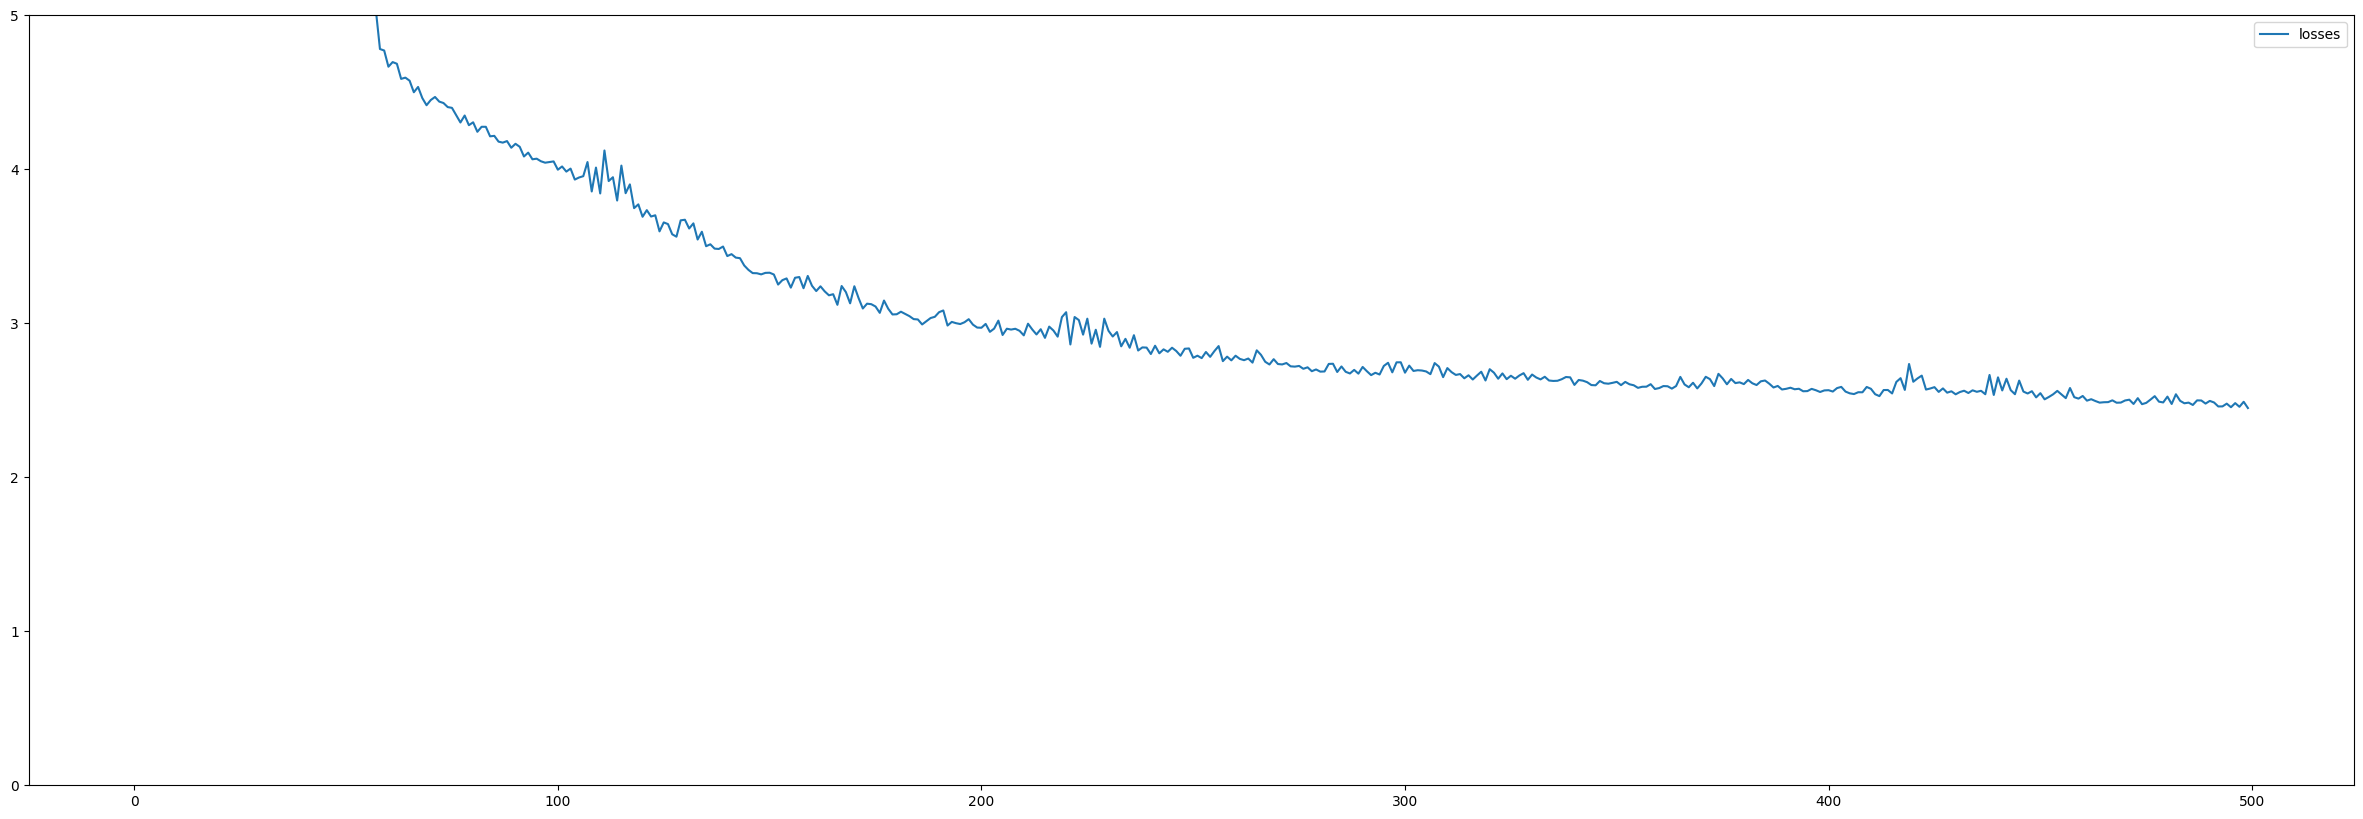

In [ ]:
plot_loss({ "losses": losses }, ylim=5)